In [1]:
import sys
sys.path.append("./modules")

from modules.data_utils import load_data, extract_xy_from_loader, sample_batch, PCAEncoder, data_scaler, dataset_dataloaders
from modules.plot_utils import visualize_umap, show_images_batch, data_variance_plot, feature_heatmap, plot_metric_with_std, plot_confusion_matrix, plot_auroc, plot_prec, plot_reconstructed_heatmaps_with_predictions, plot_noise_comparison, reliability_diagram_multi
from modules.model_utils import cv_qcnn, QuantumLinear, gradcam_model, ClassicalModel, dv_qcnn, DVQuantumLinear, get_cv_qcnn_qnode, get_dv_qcnn_qnode, compute_ece, brier_score
from modules.training_validating import run_kfold_training, evaluate_v2, noise_robustness_validation

import torch
from torch.utils.data import DataLoader, Subset
from torch.utils.data import TensorDataset
from pennylane import draw_mpl
import torch.optim as optim
import torch.nn as nn

import pickle
import json
import umap
import joblib

import matplotlib.pyplot as plt

/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_flag = "breastmnist"
# train_raw_loader, train_raw_dataset, val_raw_loader, val_raw_dataset, test_raw_loader, test_raw_dataset = load_data(data_flag, batch_size=32, train_fraction=0.1)
train_raw_loader, train_raw_dataset, val_raw_loader, val_raw_dataset, test_raw_loader, test_raw_dataset = load_data(data_flag, batch_size=32, train_fraction=1.0)

In [3]:
# encoder = PCAEncoder(n_components=4)
# encoder.fit(train_raw_loader)

#load once trained
encoder = PCAEncoder(n_components=4)
# encoder.pca = joblib.load("/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/pca_encoder_breast.pkl")
encoder.pca = joblib.load("/home/dalopezm/gaussian-qnns/model_checkpoints/pca_encoder_breast.pkl")
encoder.fitted = True


x_train_encoded, y_train_tensor = encoder.transform(train_raw_loader)
x_val_encoded, y_val_tensor = encoder.transform(val_raw_loader)
x_test_encoded, y_test_tensor = encoder.transform(test_raw_loader)

In [4]:
# joblib.dump(encoder.pca, "/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/pca_encoder_breast.pkl")
joblib.dump(encoder.pca, "/home/dalopezm/gaussian-qnns/model_checkpoints/pca_encoder_breast.pkl")

['/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/pca_encoder_breast.pkl']

/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


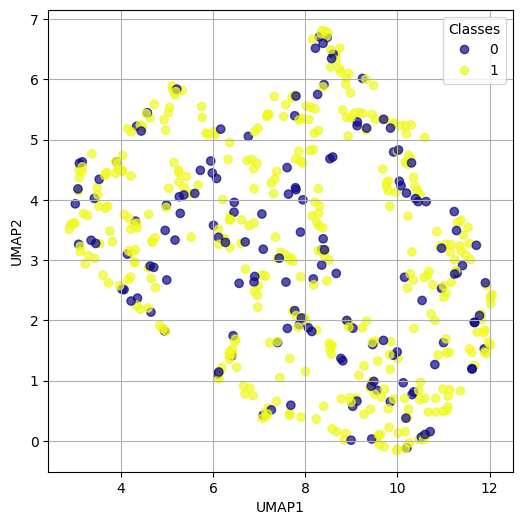

In [5]:
y_train = torch.cat([y for _, y in train_raw_loader], dim=0)

visualize_umap(x_train_encoded.numpy(), y_train.numpy())

/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


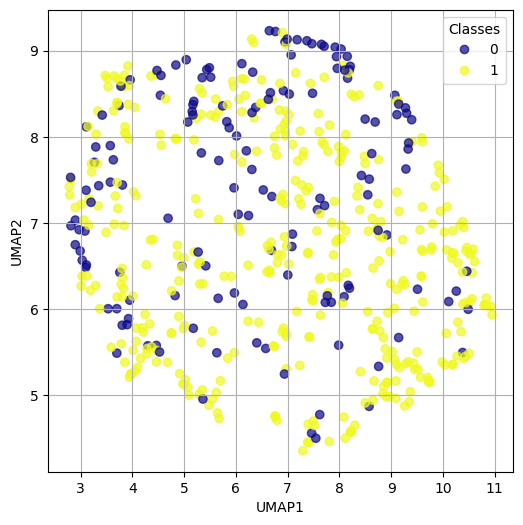

In [6]:
x_train_raw, y_train_raw = extract_xy_from_loader(train_raw_loader)

visualize_umap(x_train_raw.numpy(), y_train_raw.numpy())

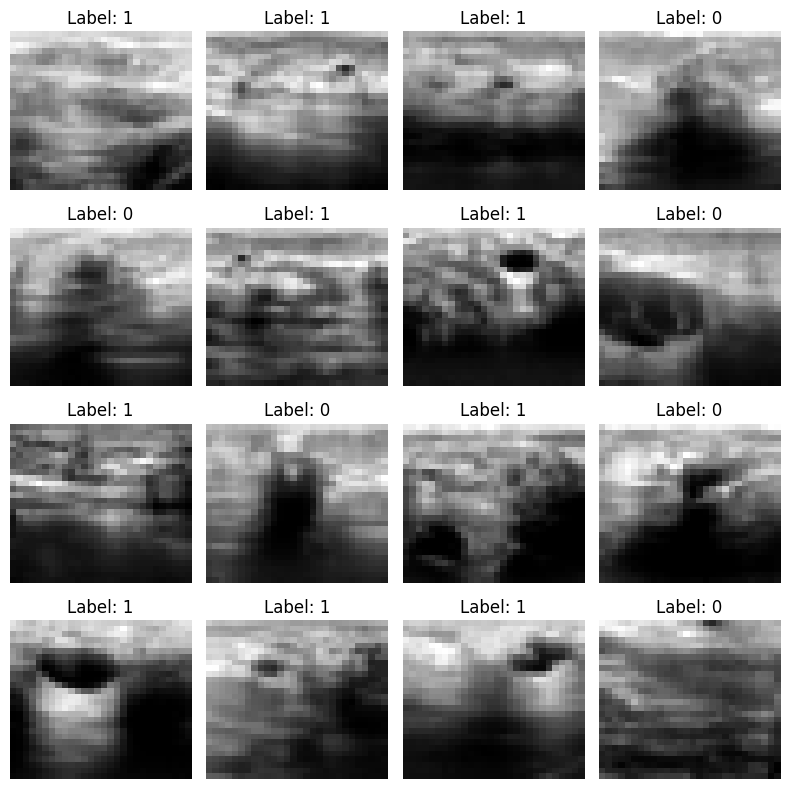

In [7]:
x_batch, y_batch = sample_batch(train_raw_loader, n_samples=16)
show_images_batch(x_batch.view(-1, 1, 28, 28), y_batch)

/tmp/ipykernel_94791/214262766.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_reconstructed = torch.tensor(x_reconstructed).view(-1, 1, 28, 28)


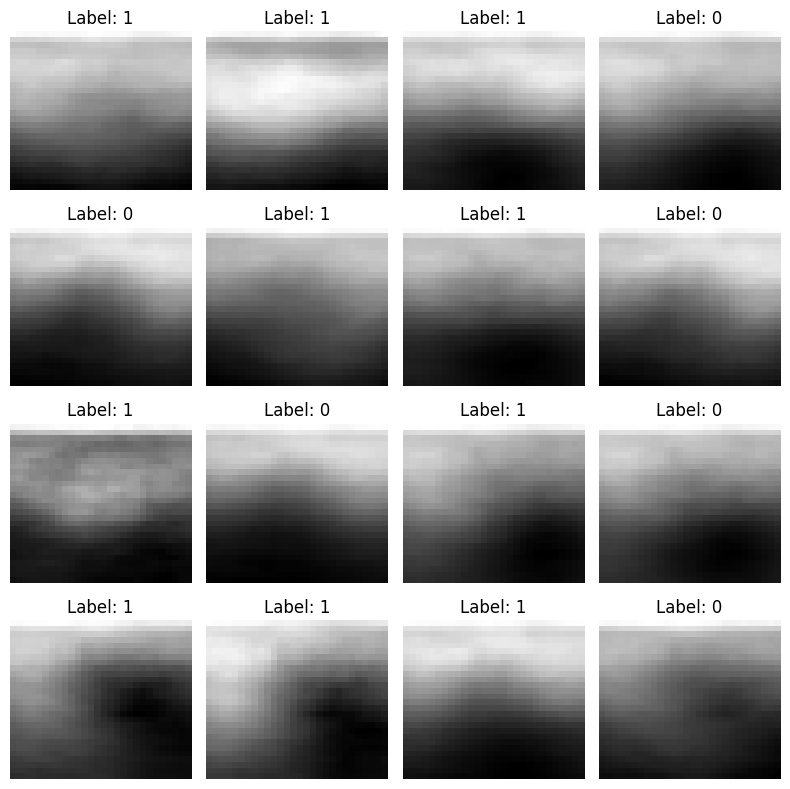

In [8]:
temp_dataset = TensorDataset(x_batch, y_batch)
temp_loader = DataLoader(temp_dataset, batch_size=16, shuffle=False)

x_encoded, y_encoded = encoder.transform(temp_loader)
x_reconstructed = encoder.pca.inverse_transform(x_encoded)

x_reconstructed = torch.tensor(x_reconstructed).view(-1, 1, 28, 28)

show_images_batch(x_reconstructed, y_batch)

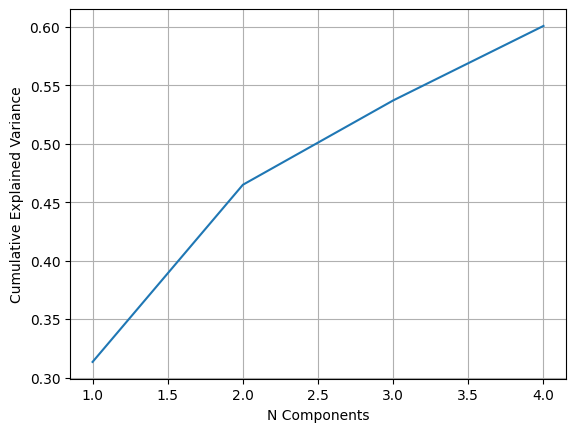

In [9]:
data_variance_plot(encoder)

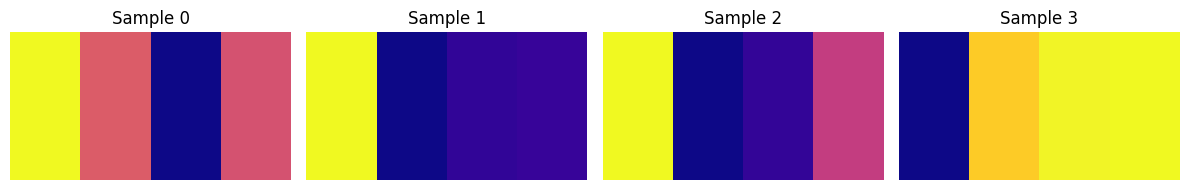

In [10]:
feature_heatmap(x_train_encoded)

## CONTINUOUS VARIABLE MODEL

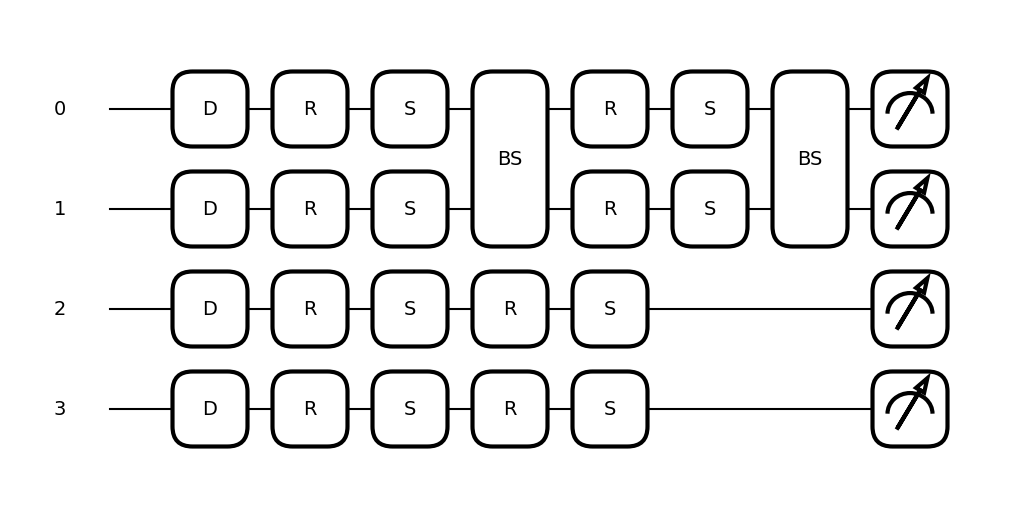

In [11]:
n_qumodes = 4
# dummy_inputs = torch.zeros(n_qumodes)
# dummy_weights = torch.zeros((2, n_qumodes, 4))
# fig, ax = draw_mpl(cv_qcnn)(dummy_inputs, dummy_weights, n_qumodes)

dummy_inputs = torch.zeros(n_qumodes)
dummy_weights = torch.zeros((2, n_qumodes, 4))

cv_qcnn_qnode = get_cv_qcnn_qnode(n_qumodes)
fig, ax = draw_mpl(cv_qcnn_qnode)(dummy_inputs, dummy_weights)
fig.show()

In [12]:
save_database_name = "breast"

#run once to train
x_train_tensor, x_val_tensor, x_test_tensor = data_scaler(x_train_encoded, x_val_encoded, x_test_encoded, save_database_name=save_database_name)

In [13]:
# x_train_tensor, x_val_tensor, x_test_tensor = data_scaler(x_train_encoded, x_val_encoded, x_test_encoded)

#load once trained
# scaler = joblib.load(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/pca_scaler_{save_database_name}.pkl")
scaler = joblib.load(f"/home/dalopezm/gaussian-qnns/model_checkpoints/pca_scaler_{save_database_name}.pkl")

x_train_scaled = scaler.transform(x_train_encoded)
x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)

x_val_scaled = scaler.transform(x_val_encoded)
x_val_tensor = torch.tensor(x_val_scaled, dtype=torch.float32)

x_test_scaled = scaler.transform(x_test_encoded)
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)

In [14]:
train_dataset, train_loader = dataset_dataloaders(x_train_tensor, y_train_tensor.squeeze())
val_dataset, val_loader = dataset_dataloaders(x_val_tensor, y_val_tensor)
test_dataset, test_loader = dataset_dataloaders(x_test_tensor, y_test_tensor)

In [15]:
x_train_pca, y_train_pca = extract_xy_from_loader(train_loader)

In [16]:
x_train_pca_sample, y_train_pca_sample = train_dataset[0]

In [17]:
print(y_train_pca_sample.shape, y_train_pca_sample)
print(y_train_pca_sample.dtype)

torch.Size([]) tensor(0)
torch.int64


In [18]:
print(y_train_pca.shape, y_train_pca)
print(y_train_pca.dtype)
n_classes = len(y_train_pca.unique())
print(n_classes)

torch.Size([546]) tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1,

In [19]:
epochs = 50
device = "cpu"
cv_model = QuantumLinear(n_qumodes=4, n_classes=2).to(device)

optimizer = torch.optim.Adam(cv_model.parameters(), lr=1e-3)
# optimizer = torch.optim.Adam(cv_model.parameters(), lr=3e-3)
criterion = nn.CrossEntropyLoss()

In [20]:
from torchinfo import summary
summary(cv_model)

Layer (type:depth-idx)                   Param #
QuantumLinear                            --
├─TorchLayer: 1-1                        32
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       10
Total params: 42
Trainable params: 42
Non-trainable params: 0

In [21]:
model_name = "cv_breast"

In [19]:
run_kfold_training(QuantumLinear, train_dataset, optimizer, criterion, n_classes, model_name, device=device, classical=False, k=3, num_epochs=epochs, seed=42)


 Fold 1/3
 
Epoch 1/50 (fold 1)


Training | Fold 1 | Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:15<00:00,  1.32s/it, loss=37.8887, acc=0.4396]
Training | Fold 1 | Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.11it/s, loss=27.9125, acc=0.4780]


Train loss: 37.8887 | Train acc: 0.4396 | Train rec: 0.4396 | Train prec: 0.5438 | Train f1: 0.4712
Val loss: 27.9125 | Val acc: 0.4780 | Val rec: 0.4780 | Val prec: 0.5773 | Val f1: 0.4780
 
Epoch 2/50 (fold 1)


Training | Fold 1 | Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:16<00:00,  1.36s/it, loss=24.1636, acc=0.4423]
Training | Fold 1 | Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.31it/s, loss=16.7710, acc=0.4670]


Train loss: 24.1636 | Train acc: 0.4423 | Train rec: 0.4423 | Train prec: 0.5432 | Train f1: 0.4738
Val loss: 16.7710 | Val acc: 0.4670 | Val rec: 0.4670 | Val prec: 0.5712 | Val f1: 0.4670
 
Epoch 3/50 (fold 1)


Training | Fold 1 | Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:17<00:00,  1.49s/it, loss=13.5872, acc=0.4396]
Training | Fold 1 | Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.11it/s, loss=8.0064, acc=0.4615]


Train loss: 13.5872 | Train acc: 0.4396 | Train rec: 0.4396 | Train prec: 0.5461 | Train f1: 0.4711
Val loss: 8.0064 | Val acc: 0.4615 | Val rec: 0.4615 | Val prec: 0.5680 | Val f1: 0.4615
 
Epoch 4/50 (fold 1)


Training | Fold 1 | Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:22<00:00,  1.88s/it, loss=5.4215, acc=0.4423]
Training | Fold 1 | Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.09it/s, loss=1.9031, acc=0.4231]


Train loss: 5.4215 | Train acc: 0.4423 | Train rec: 0.4423 | Train prec: 0.5545 | Train f1: 0.4734
Val loss: 1.9031 | Val acc: 0.4231 | Val rec: 0.4231 | Val prec: 0.5736 | Val f1: 0.4231
 
Epoch 5/50 (fold 1)


Training | Fold 1 | Epoch 5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.94s/it, loss=1.9991, acc=0.5330]
Training | Fold 1 | Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.21it/s, loss=2.3032, acc=0.5330]


Train loss: 1.9991 | Train acc: 0.5330 | Train rec: 0.5330 | Train prec: 0.6624 | Train f1: 0.5578
Val loss: 2.3032 | Val acc: 0.5330 | Val rec: 0.5330 | Val prec: 0.6783 | Val f1: 0.5330
 
Epoch 6/50 (fold 1)


Training | Fold 1 | Epoch 6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.94s/it, loss=1.7000, acc=0.5604]
Training | Fold 1 | Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.19it/s, loss=1.4466, acc=0.4341]


Train loss: 1.7000 | Train acc: 0.5604 | Train rec: 0.5604 | Train prec: 0.6944 | Train f1: 0.5835
Val loss: 1.4466 | Val acc: 0.4341 | Val rec: 0.4341 | Val prec: 0.6162 | Val f1: 0.4341
 
Epoch 7/50 (fold 1)


Training | Fold 1 | Epoch 7: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=1.2003, acc=0.4505]
Training | Fold 1 | Epoch 7: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.11it/s, loss=1.2990, acc=0.4560]


Train loss: 1.2003 | Train acc: 0.4505 | Train rec: 0.4505 | Train prec: 0.5834 | Train f1: 0.4786
Val loss: 1.2990 | Val acc: 0.4560 | Val rec: 0.4560 | Val prec: 0.6371 | Val f1: 0.4560
 
Epoch 8/50 (fold 1)


Training | Fold 1 | Epoch 8: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.96s/it, loss=1.0326, acc=0.5027]
Training | Fold 1 | Epoch 8: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.03it/s, loss=1.2015, acc=0.4835]


Train loss: 1.0326 | Train acc: 0.5027 | Train rec: 0.5027 | Train prec: 0.6379 | Train f1: 0.5283
Val loss: 1.2015 | Val acc: 0.4835 | Val rec: 0.4835 | Val prec: 0.6600 | Val f1: 0.4835
 
Epoch 9/50 (fold 1)


Training | Fold 1 | Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.92s/it, loss=0.9580, acc=0.5082]
Training | Fold 1 | Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.37it/s, loss=1.0973, acc=0.4505]


Train loss: 0.9580 | Train acc: 0.5082 | Train rec: 0.5082 | Train prec: 0.6626 | Train f1: 0.5308
Val loss: 1.0973 | Val acc: 0.4505 | Val rec: 0.4505 | Val prec: 0.6409 | Val f1: 0.4505
 
Epoch 10/50 (fold 1)


Training | Fold 1 | Epoch 10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.93s/it, loss=0.8858, acc=0.5220]
Training | Fold 1 | Epoch 10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.25it/s, loss=1.0361, acc=0.4341]


Train loss: 0.8858 | Train acc: 0.5220 | Train rec: 0.5220 | Train prec: 0.6763 | Train f1: 0.5442
Val loss: 1.0361 | Val acc: 0.4341 | Val rec: 0.4341 | Val prec: 0.6231 | Val f1: 0.4341
 
Epoch 11/50 (fold 1)


Training | Fold 1 | Epoch 11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.94s/it, loss=0.8447, acc=0.5110]
Training | Fold 1 | Epoch 11: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.24it/s, loss=0.9820, acc=0.4560]


Train loss: 0.8447 | Train acc: 0.5110 | Train rec: 0.5110 | Train prec: 0.6779 | Train f1: 0.5314
Val loss: 0.9820 | Val acc: 0.4560 | Val rec: 0.4560 | Val prec: 0.6519 | Val f1: 0.4560
 
Epoch 12/50 (fold 1)


Training | Fold 1 | Epoch 12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.94s/it, loss=0.8161, acc=0.5275]
Training | Fold 1 | Epoch 12: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.17it/s, loss=0.9343, acc=0.4286]


Train loss: 0.8161 | Train acc: 0.5275 | Train rec: 0.5275 | Train prec: 0.6932 | Train f1: 0.5478
Val loss: 0.9343 | Val acc: 0.4286 | Val rec: 0.4286 | Val prec: 0.6267 | Val f1: 0.4286
 
Epoch 13/50 (fold 1)


Training | Fold 1 | Epoch 13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=0.7972, acc=0.5275]
Training | Fold 1 | Epoch 13: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.91it/s, loss=0.9096, acc=0.5000]


Train loss: 0.7972 | Train acc: 0.5275 | Train rec: 0.5275 | Train prec: 0.6970 | Train f1: 0.5472
Val loss: 0.9096 | Val acc: 0.5000 | Val rec: 0.5000 | Val prec: 0.6919 | Val f1: 0.5000
 
Epoch 14/50 (fold 1)


Training | Fold 1 | Epoch 14: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.94s/it, loss=0.7802, acc=0.5357]
Training | Fold 1 | Epoch 14: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.31it/s, loss=0.8792, acc=0.4396]


Train loss: 0.7802 | Train acc: 0.5357 | Train rec: 0.5357 | Train prec: 0.7125 | Train f1: 0.5542
Val loss: 0.8792 | Val acc: 0.4396 | Val rec: 0.4396 | Val prec: 0.6267 | Val f1: 0.4396
 
Epoch 15/50 (fold 1)


Training | Fold 1 | Epoch 15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.92s/it, loss=0.7632, acc=0.5549]
Training | Fold 1 | Epoch 15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.43it/s, loss=0.8659, acc=0.4505]


Train loss: 0.7632 | Train acc: 0.5549 | Train rec: 0.5549 | Train prec: 0.7208 | Train f1: 0.5746
Val loss: 0.8659 | Val acc: 0.4505 | Val rec: 0.4505 | Val prec: 0.6486 | Val f1: 0.4505
 
Epoch 16/50 (fold 1)


Training | Fold 1 | Epoch 16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.92s/it, loss=0.7493, acc=0.5659]
Training | Fold 1 | Epoch 16: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.27it/s, loss=0.8435, acc=0.4670]


Train loss: 0.7493 | Train acc: 0.5659 | Train rec: 0.5659 | Train prec: 0.7178 | Train f1: 0.5870
Val loss: 0.8435 | Val acc: 0.4670 | Val rec: 0.4670 | Val prec: 0.6583 | Val f1: 0.4670
 
Epoch 17/50 (fold 1)


Training | Fold 1 | Epoch 17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.93s/it, loss=0.7403, acc=0.5632]
Training | Fold 1 | Epoch 17: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.37it/s, loss=0.8279, acc=0.4890]


Train loss: 0.7403 | Train acc: 0.5632 | Train rec: 0.5632 | Train prec: 0.7242 | Train f1: 0.5833
Val loss: 0.8279 | Val acc: 0.4890 | Val rec: 0.4890 | Val prec: 0.6864 | Val f1: 0.4890
 
Epoch 18/50 (fold 1)


Training | Fold 1 | Epoch 18: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.92s/it, loss=0.7229, acc=0.5632]
Training | Fold 1 | Epoch 18: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.15it/s, loss=0.8048, acc=0.4451]


Train loss: 0.7229 | Train acc: 0.5632 | Train rec: 0.5632 | Train prec: 0.7204 | Train f1: 0.5837
Val loss: 0.8048 | Val acc: 0.4451 | Val rec: 0.4451 | Val prec: 0.6303 | Val f1: 0.4451
 
Epoch 19/50 (fold 1)


Training | Fold 1 | Epoch 19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.97s/it, loss=0.7196, acc=0.5632]
Training | Fold 1 | Epoch 19: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.72it/s, loss=0.8000, acc=0.4945]


Train loss: 0.7196 | Train acc: 0.5632 | Train rec: 0.5632 | Train prec: 0.7094 | Train f1: 0.5850
Val loss: 0.8000 | Val acc: 0.4945 | Val rec: 0.4945 | Val prec: 0.6810 | Val f1: 0.4945
 
Epoch 20/50 (fold 1)


Training | Fold 1 | Epoch 20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=0.7054, acc=0.5659]
Training | Fold 1 | Epoch 20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.80it/s, loss=0.7877, acc=0.4451]


Train loss: 0.7054 | Train acc: 0.5659 | Train rec: 0.5659 | Train prec: 0.7070 | Train f1: 0.5881
Val loss: 0.7877 | Val acc: 0.4451 | Val rec: 0.4451 | Val prec: 0.6234 | Val f1: 0.4451
 
Epoch 21/50 (fold 1)


Training | Fold 1 | Epoch 21: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.97s/it, loss=0.7013, acc=0.5824]
Training | Fold 1 | Epoch 21: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.02it/s, loss=0.7792, acc=0.4780]


Train loss: 0.7013 | Train acc: 0.5824 | Train rec: 0.5824 | Train prec: 0.7176 | Train f1: 0.6044
Val loss: 0.7792 | Val acc: 0.4780 | Val rec: 0.4780 | Val prec: 0.6431 | Val f1: 0.4780
 
Epoch 22/50 (fold 1)


Training | Fold 1 | Epoch 22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.96s/it, loss=0.6948, acc=0.5879]
Training | Fold 1 | Epoch 22: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.05it/s, loss=0.7670, acc=0.4560]


Train loss: 0.6948 | Train acc: 0.5879 | Train rec: 0.5879 | Train prec: 0.7200 | Train f1: 0.6098
Val loss: 0.7670 | Val acc: 0.4560 | Val rec: 0.4560 | Val prec: 0.6174 | Val f1: 0.4560
 
Epoch 23/50 (fold 1)


Training | Fold 1 | Epoch 23: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.98s/it, loss=0.6923, acc=0.5687]
Training | Fold 1 | Epoch 23: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.26it/s, loss=0.7678, acc=0.5110]


Train loss: 0.6923 | Train acc: 0.5687 | Train rec: 0.5687 | Train prec: 0.7082 | Train f1: 0.5909
Val loss: 0.7678 | Val acc: 0.5110 | Val rec: 0.5110 | Val prec: 0.6674 | Val f1: 0.5110
 
Epoch 24/50 (fold 1)


Training | Fold 1 | Epoch 24: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.93s/it, loss=0.6835, acc=0.5962]
Training | Fold 1 | Epoch 24: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.97it/s, loss=0.7735, acc=0.4121]


Train loss: 0.6835 | Train acc: 0.5962 | Train rec: 0.5962 | Train prec: 0.7235 | Train f1: 0.6180
Val loss: 0.7735 | Val acc: 0.4121 | Val rec: 0.4121 | Val prec: 0.5943 | Val f1: 0.4121
 
Epoch 25/50 (fold 1)


Training | Fold 1 | Epoch 25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:22<00:00,  1.91s/it, loss=0.6870, acc=0.5797]
Training | Fold 1 | Epoch 25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.91it/s, loss=0.7691, acc=0.5055]


Train loss: 0.6870 | Train acc: 0.5797 | Train rec: 0.5797 | Train prec: 0.6968 | Train f1: 0.6029
Val loss: 0.7691 | Val acc: 0.5055 | Val rec: 0.5055 | Val prec: 0.6515 | Val f1: 0.5055
 
Epoch 26/50 (fold 1)


Training | Fold 1 | Epoch 26: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.93s/it, loss=0.6746, acc=0.5797]
Training | Fold 1 | Epoch 26: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.31it/s, loss=0.7351, acc=0.5165]


Train loss: 0.6746 | Train acc: 0.5797 | Train rec: 0.5797 | Train prec: 0.7031 | Train f1: 0.6026
Val loss: 0.7351 | Val acc: 0.5165 | Val rec: 0.5165 | Val prec: 0.6572 | Val f1: 0.5165
 
Epoch 27/50 (fold 1)


Training | Fold 1 | Epoch 27: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.92s/it, loss=0.6797, acc=0.5962]
Training | Fold 1 | Epoch 27: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.44it/s, loss=0.7441, acc=0.4341]


Train loss: 0.6797 | Train acc: 0.5962 | Train rec: 0.5962 | Train prec: 0.7235 | Train f1: 0.6180
Val loss: 0.7441 | Val acc: 0.4341 | Val rec: 0.4341 | Val prec: 0.5862 | Val f1: 0.4341
 
Epoch 28/50 (fold 1)


Training | Fold 1 | Epoch 28: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.92s/it, loss=0.6690, acc=0.5824]
Training | Fold 1 | Epoch 28: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.28it/s, loss=0.7266, acc=0.5549]


Train loss: 0.6690 | Train acc: 0.5824 | Train rec: 0.5824 | Train prec: 0.7109 | Train f1: 0.6049
Val loss: 0.7266 | Val acc: 0.5549 | Val rec: 0.5549 | Val prec: 0.6886 | Val f1: 0.5549
 
Epoch 29/50 (fold 1)


Training | Fold 1 | Epoch 29: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.93s/it, loss=0.6592, acc=0.6016]
Training | Fold 1 | Epoch 29: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.36it/s, loss=0.7247, acc=0.5549]


Train loss: 0.6592 | Train acc: 0.6016 | Train rec: 0.6016 | Train prec: 0.7066 | Train f1: 0.6241
Val loss: 0.7247 | Val acc: 0.5549 | Val rec: 0.5549 | Val prec: 0.6886 | Val f1: 0.5549
 
Epoch 30/50 (fold 1)


Training | Fold 1 | Epoch 30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.93s/it, loss=0.6480, acc=0.6264]
Training | Fold 1 | Epoch 30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.34it/s, loss=0.7086, acc=0.5495]


Train loss: 0.6480 | Train acc: 0.6264 | Train rec: 0.6264 | Train prec: 0.7177 | Train f1: 0.6474
Val loss: 0.7086 | Val acc: 0.5495 | Val rec: 0.5495 | Val prec: 0.6796 | Val f1: 0.5495
 
Epoch 31/50 (fold 1)


Training | Fold 1 | Epoch 31: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.92s/it, loss=0.6565, acc=0.5907]
Training | Fold 1 | Epoch 31: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.98it/s, loss=0.6968, acc=0.5220]


Train loss: 0.6565 | Train acc: 0.5907 | Train rec: 0.5907 | Train prec: 0.6987 | Train f1: 0.6137
Val loss: 0.6968 | Val acc: 0.5220 | Val rec: 0.5220 | Val prec: 0.6259 | Val f1: 0.5220
 
Epoch 32/50 (fold 1)


Training | Fold 1 | Epoch 32: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:22<00:00,  1.91s/it, loss=0.6381, acc=0.6401]
Training | Fold 1 | Epoch 32: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.01it/s, loss=0.6941, acc=0.5330]


Train loss: 0.6381 | Train acc: 0.6401 | Train rec: 0.6401 | Train prec: 0.7238 | Train f1: 0.6601
Val loss: 0.6941 | Val acc: 0.5330 | Val rec: 0.5330 | Val prec: 0.6315 | Val f1: 0.5330
 
Epoch 33/50 (fold 1)


Training | Fold 1 | Epoch 33: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.96s/it, loss=0.6464, acc=0.6126]
Training | Fold 1 | Epoch 33: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.01it/s, loss=0.6869, acc=0.5549]


Train loss: 0.6464 | Train acc: 0.6126 | Train rec: 0.6126 | Train prec: 0.7057 | Train f1: 0.6345
Val loss: 0.6869 | Val acc: 0.5549 | Val rec: 0.5549 | Val prec: 0.6532 | Val f1: 0.5549
 
Epoch 34/50 (fold 1)


Training | Fold 1 | Epoch 34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.97s/it, loss=0.6259, acc=0.6484]
Training | Fold 1 | Epoch 34: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.27it/s, loss=0.7004, acc=0.5549]


Train loss: 0.6259 | Train acc: 0.6484 | Train rec: 0.6484 | Train prec: 0.7192 | Train f1: 0.6672
Val loss: 0.7004 | Val acc: 0.5549 | Val rec: 0.5549 | Val prec: 0.6643 | Val f1: 0.5549
 
Epoch 35/50 (fold 1)


Training | Fold 1 | Epoch 35: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=0.6273, acc=0.6264]
Training | Fold 1 | Epoch 35: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.17it/s, loss=0.6767, acc=0.5769]


Train loss: 0.6273 | Train acc: 0.6264 | Train rec: 0.6264 | Train prec: 0.7063 | Train f1: 0.6470
Val loss: 0.6767 | Val acc: 0.5769 | Val rec: 0.5769 | Val prec: 0.6586 | Val f1: 0.5769
 
Epoch 36/50 (fold 1)


Training | Fold 1 | Epoch 36: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.94s/it, loss=0.6400, acc=0.6154]
Training | Fold 1 | Epoch 36: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.01it/s, loss=0.6954, acc=0.4780]


Train loss: 0.6400 | Train acc: 0.6154 | Train rec: 0.6154 | Train prec: 0.6930 | Train f1: 0.6364
Val loss: 0.6954 | Val acc: 0.4780 | Val rec: 0.4780 | Val prec: 0.6021 | Val f1: 0.4780
 
Epoch 37/50 (fold 1)


Training | Fold 1 | Epoch 37: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:22<00:00,  1.91s/it, loss=0.6222, acc=0.6538]
Training | Fold 1 | Epoch 37: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.91it/s, loss=0.6695, acc=0.6154]


Train loss: 0.6222 | Train acc: 0.6538 | Train rec: 0.6538 | Train prec: 0.7245 | Train f1: 0.6724
Val loss: 0.6695 | Val acc: 0.6154 | Val rec: 0.6154 | Val prec: 0.6774 | Val f1: 0.6154
 
Epoch 38/50 (fold 1)


Training | Fold 1 | Epoch 38: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.94s/it, loss=0.6109, acc=0.6593]
Training | Fold 1 | Epoch 38: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.12it/s, loss=0.6761, acc=0.6264]


Train loss: 0.6109 | Train acc: 0.6593 | Train rec: 0.6593 | Train prec: 0.7115 | Train f1: 0.6756
Val loss: 0.6761 | Val acc: 0.6264 | Val rec: 0.6264 | Val prec: 0.6930 | Val f1: 0.6264
 
Epoch 39/50 (fold 1)


Training | Fold 1 | Epoch 39: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.94s/it, loss=0.6174, acc=0.6511]
Training | Fold 1 | Epoch 39: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.45it/s, loss=0.6850, acc=0.5275]


Train loss: 0.6174 | Train acc: 0.6511 | Train rec: 0.6511 | Train prec: 0.7100 | Train f1: 0.6686
Val loss: 0.6850 | Val acc: 0.5275 | Val rec: 0.5275 | Val prec: 0.6340 | Val f1: 0.5275
 
Epoch 40/50 (fold 1)


Training | Fold 1 | Epoch 40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.94s/it, loss=0.6365, acc=0.6566]
Training | Fold 1 | Epoch 40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.27it/s, loss=0.6671, acc=0.6209]


Train loss: 0.6365 | Train acc: 0.6566 | Train rec: 0.6566 | Train prec: 0.7053 | Train f1: 0.6724
Val loss: 0.6671 | Val acc: 0.6209 | Val rec: 0.6209 | Val prec: 0.6852 | Val f1: 0.6209
 
Epoch 41/50 (fold 1)


Training | Fold 1 | Epoch 41: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.96s/it, loss=0.6220, acc=0.6456]
Training | Fold 1 | Epoch 41: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.16it/s, loss=0.6873, acc=0.6154]


Train loss: 0.6220 | Train acc: 0.6456 | Train rec: 0.6456 | Train prec: 0.6949 | Train f1: 0.6619
Val loss: 0.6873 | Val acc: 0.6154 | Val rec: 0.6154 | Val prec: 0.6930 | Val f1: 0.6154
 
Epoch 42/50 (fold 1)


Training | Fold 1 | Epoch 42: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.94s/it, loss=0.6047, acc=0.6648]
Training | Fold 1 | Epoch 42: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.43it/s, loss=0.6571, acc=0.5879]


Train loss: 0.6047 | Train acc: 0.6648 | Train rec: 0.6648 | Train prec: 0.7143 | Train f1: 0.6804
Val loss: 0.6571 | Val acc: 0.5879 | Val rec: 0.5879 | Val prec: 0.6539 | Val f1: 0.5879
 
Epoch 43/50 (fold 1)


Training | Fold 1 | Epoch 43: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.96s/it, loss=0.5959, acc=0.6841]
Training | Fold 1 | Epoch 43: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.73it/s, loss=0.6470, acc=0.6538]


Train loss: 0.5959 | Train acc: 0.6841 | Train rec: 0.6841 | Train prec: 0.7240 | Train f1: 0.6973
Val loss: 0.6470 | Val acc: 0.6538 | Val rec: 0.6538 | Val prec: 0.6966 | Val f1: 0.6538
 
Epoch 44/50 (fold 1)


Training | Fold 1 | Epoch 44: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.93s/it, loss=0.5903, acc=0.6731]
Training | Fold 1 | Epoch 44: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.79it/s, loss=0.6500, acc=0.6264]


Train loss: 0.5903 | Train acc: 0.6731 | Train rec: 0.6731 | Train prec: 0.7113 | Train f1: 0.6863
Val loss: 0.6500 | Val acc: 0.6264 | Val rec: 0.6264 | Val prec: 0.6779 | Val f1: 0.6264
 
Epoch 45/50 (fold 1)


Training | Fold 1 | Epoch 45: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.97s/it, loss=0.5883, acc=0.6758]
Training | Fold 1 | Epoch 45: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.00it/s, loss=0.6347, acc=0.6484]


Train loss: 0.5883 | Train acc: 0.6758 | Train rec: 0.6758 | Train prec: 0.7058 | Train f1: 0.6871
Val loss: 0.6347 | Val acc: 0.6484 | Val rec: 0.6484 | Val prec: 0.6844 | Val f1: 0.6484
 
Epoch 46/50 (fold 1)


Training | Fold 1 | Epoch 46: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.96s/it, loss=0.5859, acc=0.7005]
Training | Fold 1 | Epoch 46: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.25it/s, loss=0.6509, acc=0.6264]


Train loss: 0.5859 | Train acc: 0.7005 | Train rec: 0.7005 | Train prec: 0.7282 | Train f1: 0.7107
Val loss: 0.6509 | Val acc: 0.6264 | Val rec: 0.6264 | Val prec: 0.6829 | Val f1: 0.6264
 
Epoch 47/50 (fold 1)


Training | Fold 1 | Epoch 47: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.94s/it, loss=0.5794, acc=0.6978]
Training | Fold 1 | Epoch 47: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.28it/s, loss=0.6355, acc=0.6319]


Train loss: 0.5794 | Train acc: 0.6978 | Train rec: 0.6978 | Train prec: 0.7381 | Train f1: 0.7107
Val loss: 0.6355 | Val acc: 0.6319 | Val rec: 0.6319 | Val prec: 0.6712 | Val f1: 0.6319
 
Epoch 48/50 (fold 1)


Training | Fold 1 | Epoch 48: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.94s/it, loss=0.5814, acc=0.6978]
Training | Fold 1 | Epoch 48: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.91it/s, loss=0.6286, acc=0.6429]


Train loss: 0.5814 | Train acc: 0.6978 | Train rec: 0.6978 | Train prec: 0.7245 | Train f1: 0.7077
Val loss: 0.6286 | Val acc: 0.6429 | Val rec: 0.6429 | Val prec: 0.6816 | Val f1: 0.6429
 
Epoch 49/50 (fold 1)


Training | Fold 1 | Epoch 49: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.93s/it, loss=0.5780, acc=0.6951]
Training | Fold 1 | Epoch 49: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.88it/s, loss=0.6186, acc=0.6648]


Train loss: 0.5780 | Train acc: 0.6951 | Train rec: 0.6951 | Train prec: 0.7165 | Train f1: 0.7035
Val loss: 0.6186 | Val acc: 0.6648 | Val rec: 0.6648 | Val prec: 0.6932 | Val f1: 0.6648
 
Epoch 50/50 (fold 1)


Training | Fold 1 | Epoch 50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=0.5834, acc=0.6731]
Training | Fold 1 | Epoch 50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.21it/s, loss=0.6384, acc=0.6209]


Train loss: 0.5834 | Train acc: 0.6731 | Train rec: 0.6731 | Train prec: 0.7066 | Train f1: 0.6853
Val loss: 0.6384 | Val acc: 0.6209 | Val rec: 0.6209 | Val prec: 0.6514 | Val f1: 0.6209

 Fold 2/3
 
Epoch 1/50 (fold 2)


Training | Fold 2 | Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:16<00:00,  1.38s/it, loss=13.4749, acc=0.4698]
Training | Fold 2 | Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.13it/s, loss=10.3211, acc=0.5495]


Train loss: 13.4749 | Train acc: 0.4698 | Train rec: 0.4698 | Train prec: 0.5681 | Train f1: 0.4997
Val loss: 10.3211 | Val acc: 0.5495 | Val rec: 0.5495 | Val prec: 0.6796 | Val f1: 0.5495
 
Epoch 2/50 (fold 2)


Training | Fold 2 | Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:19<00:00,  1.64s/it, loss=8.2678, acc=0.4615]
Training | Fold 2 | Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.78it/s, loss=7.7249, acc=0.4121]


Train loss: 8.2678 | Train acc: 0.4615 | Train rec: 0.4615 | Train prec: 0.5497 | Train f1: 0.4914
Val loss: 7.7249 | Val acc: 0.4121 | Val rec: 0.4121 | Val prec: 0.5422 | Val f1: 0.4121
 
Epoch 3/50 (fold 2)


Training | Fold 2 | Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:22<00:00,  1.83s/it, loss=5.9648, acc=0.4396]
Training | Fold 2 | Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.86it/s, loss=6.1778, acc=0.3846]


Train loss: 5.9648 | Train acc: 0.4396 | Train rec: 0.4396 | Train prec: 0.5438 | Train f1: 0.4712
Val loss: 6.1778 | Val acc: 0.3846 | Val rec: 0.3846 | Val prec: 0.5230 | Val f1: 0.3846
 
Epoch 4/50 (fold 2)


Training | Fold 2 | Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:22<00:00,  1.90s/it, loss=4.2960, acc=0.4560]
Training | Fold 2 | Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.86it/s, loss=4.0295, acc=0.4451]


Train loss: 4.2960 | Train acc: 0.4560 | Train rec: 0.4560 | Train prec: 0.5580 | Train f1: 0.4867
Val loss: 4.0295 | Val acc: 0.4451 | Val rec: 0.4451 | Val prec: 0.5775 | Val f1: 0.4451
 
Epoch 5/50 (fold 2)


Training | Fold 2 | Epoch 5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.94s/it, loss=3.0448, acc=0.4451]
Training | Fold 2 | Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.30it/s, loss=2.6994, acc=0.4231]


Train loss: 3.0448 | Train acc: 0.4451 | Train rec: 0.4451 | Train prec: 0.5471 | Train f1: 0.4764
Val loss: 2.6994 | Val acc: 0.4231 | Val rec: 0.4231 | Val prec: 0.5635 | Val f1: 0.4231
 
Epoch 6/50 (fold 2)


Training | Fold 2 | Epoch 6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=1.9376, acc=0.4286]
Training | Fold 2 | Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.25it/s, loss=1.6562, acc=0.3956]


Train loss: 1.9376 | Train acc: 0.4286 | Train rec: 0.4286 | Train prec: 0.5439 | Train f1: 0.4601
Val loss: 1.6562 | Val acc: 0.3956 | Val rec: 0.3956 | Val prec: 0.5491 | Val f1: 0.3956
 
Epoch 7/50 (fold 2)


Training | Fold 2 | Epoch 7: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=1.2167, acc=0.4121]
Training | Fold 2 | Epoch 7: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.02it/s, loss=0.9403, acc=0.2967]


Train loss: 1.2167 | Train acc: 0.4121 | Train rec: 0.4121 | Train prec: 0.5467 | Train f1: 0.4411
Val loss: 0.9403 | Val acc: 0.2967 | Val rec: 0.2967 | Val prec: 0.5053 | Val f1: 0.2967
 
Epoch 8/50 (fold 2)


Training | Fold 2 | Epoch 8: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.97s/it, loss=0.8639, acc=0.3352]
Training | Fold 2 | Epoch 8: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.14it/s, loss=0.7888, acc=0.5385]


Train loss: 0.8639 | Train acc: 0.3352 | Train rec: 0.3352 | Train prec: 0.5999 | Train f1: 0.2877
Val loss: 0.7888 | Val acc: 0.5385 | Val rec: 0.5385 | Val prec: 0.7263 | Val f1: 0.5385
 
Epoch 9/50 (fold 2)


Training | Fold 2 | Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.97s/it, loss=0.8828, acc=0.4698]
Training | Fold 2 | Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.73it/s, loss=0.8395, acc=0.4451]


Train loss: 0.8828 | Train acc: 0.4698 | Train rec: 0.4698 | Train prec: 0.7100 | Train f1: 0.4730
Val loss: 0.8395 | Val acc: 0.4451 | Val rec: 0.4451 | Val prec: 0.6168 | Val f1: 0.4451
 
Epoch 10/50 (fold 2)


Training | Fold 2 | Epoch 10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.97s/it, loss=0.8535, acc=0.4670]
Training | Fold 2 | Epoch 10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.33it/s, loss=0.7681, acc=0.5440]


Train loss: 0.8535 | Train acc: 0.4670 | Train rec: 0.4670 | Train prec: 0.7141 | Train f1: 0.4684
Val loss: 0.7681 | Val acc: 0.5440 | Val rec: 0.5440 | Val prec: 0.7285 | Val f1: 0.5440
 
Epoch 11/50 (fold 2)


Training | Fold 2 | Epoch 11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.93s/it, loss=0.8195, acc=0.4286]
Training | Fold 2 | Epoch 11: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.29it/s, loss=0.7754, acc=0.4066]


Train loss: 0.8195 | Train acc: 0.4286 | Train rec: 0.4286 | Train prec: 0.7059 | Train f1: 0.4158
Val loss: 0.7754 | Val acc: 0.4066 | Val rec: 0.4066 | Val prec: 0.6787 | Val f1: 0.4066
 
Epoch 12/50 (fold 2)


Training | Fold 2 | Epoch 12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.92s/it, loss=0.8170, acc=0.4341]
Training | Fold 2 | Epoch 12: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.27it/s, loss=0.7744, acc=0.3956]


Train loss: 0.8170 | Train acc: 0.4341 | Train rec: 0.4341 | Train prec: 0.6965 | Train f1: 0.4265
Val loss: 0.7744 | Val acc: 0.3956 | Val rec: 0.3956 | Val prec: 0.6705 | Val f1: 0.3956
 
Epoch 13/50 (fold 2)


Training | Fold 2 | Epoch 13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.94s/it, loss=0.8043, acc=0.4066]
Training | Fold 2 | Epoch 13: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.17it/s, loss=0.7354, acc=0.5220]


Train loss: 0.8043 | Train acc: 0.4066 | Train rec: 0.4066 | Train prec: 0.7070 | Train f1: 0.3819
Val loss: 0.7354 | Val acc: 0.5220 | Val rec: 0.5220 | Val prec: 0.7285 | Val f1: 0.5220
 
Epoch 14/50 (fold 2)


Training | Fold 2 | Epoch 14: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.96s/it, loss=0.7990, acc=0.4121]
Training | Fold 2 | Epoch 14: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.71it/s, loss=0.7321, acc=0.5275]


Train loss: 0.7990 | Train acc: 0.4121 | Train rec: 0.4121 | Train prec: 0.7029 | Train f1: 0.3916
Val loss: 0.7321 | Val acc: 0.5275 | Val rec: 0.5275 | Val prec: 0.7130 | Val f1: 0.5275
 
Epoch 15/50 (fold 2)


Training | Fold 2 | Epoch 15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.96s/it, loss=0.7866, acc=0.3956]
Training | Fold 2 | Epoch 15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.87it/s, loss=0.7228, acc=0.5000]


Train loss: 0.7866 | Train acc: 0.3956 | Train rec: 0.3956 | Train prec: 0.6842 | Train f1: 0.3704
Val loss: 0.7228 | Val acc: 0.5000 | Val rec: 0.5000 | Val prec: 0.7190 | Val f1: 0.5000
 
Epoch 16/50 (fold 2)


Training | Fold 2 | Epoch 16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=0.7655, acc=0.4093]
Training | Fold 2 | Epoch 16: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.10it/s, loss=0.7079, acc=0.5385]


Train loss: 0.7655 | Train acc: 0.4093 | Train rec: 0.4093 | Train prec: 0.7011 | Train f1: 0.3877
Val loss: 0.7079 | Val acc: 0.5385 | Val rec: 0.5385 | Val prec: 0.7178 | Val f1: 0.5385
 
Epoch 17/50 (fold 2)


Training | Fold 2 | Epoch 17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.97s/it, loss=0.7789, acc=0.5137]
Training | Fold 2 | Epoch 17: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.96it/s, loss=0.8840, acc=0.4066]


Train loss: 0.7789 | Train acc: 0.5137 | Train rec: 0.5137 | Train prec: 0.7157 | Train f1: 0.5278
Val loss: 0.8840 | Val acc: 0.4066 | Val rec: 0.4066 | Val prec: 0.5341 | Val f1: 0.4066
 
Epoch 18/50 (fold 2)


Training | Fold 2 | Epoch 18: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.96s/it, loss=0.8361, acc=0.4533]
Training | Fold 2 | Epoch 18: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.20it/s, loss=0.7078, acc=0.5549]


Train loss: 0.8361 | Train acc: 0.4533 | Train rec: 0.4533 | Train prec: 0.6464 | Train f1: 0.4671
Val loss: 0.7078 | Val acc: 0.5549 | Val rec: 0.5549 | Val prec: 0.7094 | Val f1: 0.5549
 
Epoch 19/50 (fold 2)


Training | Fold 2 | Epoch 19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.96s/it, loss=0.7626, acc=0.4451]
Training | Fold 2 | Epoch 19: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.72it/s, loss=0.6880, acc=0.5549]


Train loss: 0.7626 | Train acc: 0.4451 | Train rec: 0.4451 | Train prec: 0.6532 | Train f1: 0.4541
Val loss: 0.6880 | Val acc: 0.5549 | Val rec: 0.5549 | Val prec: 0.7247 | Val f1: 0.5549
 
Epoch 20/50 (fold 2)


Training | Fold 2 | Epoch 20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=0.7400, acc=0.4808]
Training | Fold 2 | Epoch 20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.23it/s, loss=0.7552, acc=0.4066]


Train loss: 0.7400 | Train acc: 0.4808 | Train rec: 0.4808 | Train prec: 0.7101 | Train f1: 0.4875
Val loss: 0.7552 | Val acc: 0.4066 | Val rec: 0.4066 | Val prec: 0.5430 | Val f1: 0.4066
 
Epoch 21/50 (fold 2)


Training | Fold 2 | Epoch 21: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=0.7503, acc=0.4808]
Training | Fold 2 | Epoch 21: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.15it/s, loss=0.6792, acc=0.5769]


Train loss: 0.7503 | Train acc: 0.4808 | Train rec: 0.4808 | Train prec: 0.6738 | Train f1: 0.4958
Val loss: 0.6792 | Val acc: 0.5769 | Val rec: 0.5769 | Val prec: 0.7261 | Val f1: 0.5769
 
Epoch 22/50 (fold 2)


Training | Fold 2 | Epoch 22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.94s/it, loss=0.7295, acc=0.4588]
Training | Fold 2 | Epoch 22: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.27it/s, loss=0.6719, acc=0.5879]


Train loss: 0.7295 | Train acc: 0.4588 | Train rec: 0.4588 | Train prec: 0.6887 | Train f1: 0.4634
Val loss: 0.6719 | Val acc: 0.5879 | Val rec: 0.5879 | Val prec: 0.7306 | Val f1: 0.5879
 
Epoch 23/50 (fold 2)


Training | Fold 2 | Epoch 23: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.92s/it, loss=0.7277, acc=0.5082]
Training | Fold 2 | Epoch 23: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.35it/s, loss=0.7120, acc=0.4560]


Train loss: 0.7277 | Train acc: 0.5082 | Train rec: 0.5082 | Train prec: 0.7043 | Train f1: 0.5233
Val loss: 0.7120 | Val acc: 0.4560 | Val rec: 0.4560 | Val prec: 0.6000 | Val f1: 0.4560
 
Epoch 24/50 (fold 2)


Training | Fold 2 | Epoch 24: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:22<00:00,  1.91s/it, loss=0.7134, acc=0.5055]
Training | Fold 2 | Epoch 24: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.31it/s, loss=0.6602, acc=0.5824]


Train loss: 0.7134 | Train acc: 0.5055 | Train rec: 0.5055 | Train prec: 0.7030 | Train f1: 0.5202
Val loss: 0.6602 | Val acc: 0.5824 | Val rec: 0.5824 | Val prec: 0.7283 | Val f1: 0.5824
 
Epoch 25/50 (fold 2)


Training | Fold 2 | Epoch 25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.92s/it, loss=0.7030, acc=0.5055]
Training | Fold 2 | Epoch 25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.35it/s, loss=0.6579, acc=0.6154]


Train loss: 0.7030 | Train acc: 0.5055 | Train rec: 0.5055 | Train prec: 0.7074 | Train f1: 0.5193
Val loss: 0.6579 | Val acc: 0.6154 | Val rec: 0.6154 | Val prec: 0.7417 | Val f1: 0.6154
 
Epoch 26/50 (fold 2)


Training | Fold 2 | Epoch 26: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:22<00:00,  1.91s/it, loss=0.7049, acc=0.5027]
Training | Fold 2 | Epoch 26: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.00it/s, loss=0.6525, acc=0.5934]


Train loss: 0.7049 | Train acc: 0.5027 | Train rec: 0.5027 | Train prec: 0.6932 | Train f1: 0.5188
Val loss: 0.6525 | Val acc: 0.5934 | Val rec: 0.5934 | Val prec: 0.7257 | Val f1: 0.5934
 
Epoch 27/50 (fold 2)


Training | Fold 2 | Epoch 27: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.94s/it, loss=0.6930, acc=0.5412]
Training | Fold 2 | Epoch 27: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.22it/s, loss=0.7120, acc=0.4615]


Train loss: 0.6930 | Train acc: 0.5412 | Train rec: 0.5412 | Train prec: 0.7109 | Train f1: 0.5607
Val loss: 0.7120 | Val acc: 0.4615 | Val rec: 0.4615 | Val prec: 0.5634 | Val f1: 0.4615
 
Epoch 28/50 (fold 2)


Training | Fold 2 | Epoch 28: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=0.6952, acc=0.4945]
Training | Fold 2 | Epoch 28: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.13it/s, loss=0.6406, acc=0.6429]


Train loss: 0.6952 | Train acc: 0.4945 | Train rec: 0.4945 | Train prec: 0.6695 | Train f1: 0.5136
Val loss: 0.6406 | Val acc: 0.6429 | Val rec: 0.6429 | Val prec: 0.7461 | Val f1: 0.6429
 
Epoch 29/50 (fold 2)


Training | Fold 2 | Epoch 29: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.96s/it, loss=0.6910, acc=0.5522]
Training | Fold 2 | Epoch 29: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.01it/s, loss=0.6344, acc=0.6099]


Train loss: 0.6910 | Train acc: 0.5522 | Train rec: 0.5522 | Train prec: 0.6974 | Train f1: 0.5745
Val loss: 0.6344 | Val acc: 0.6099 | Val rec: 0.6099 | Val prec: 0.7259 | Val f1: 0.6099
 
Epoch 30/50 (fold 2)


Training | Fold 2 | Epoch 30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.98s/it, loss=0.6925, acc=0.5440]
Training | Fold 2 | Epoch 30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.12it/s, loss=0.6482, acc=0.6154]


Train loss: 0.6925 | Train acc: 0.5440 | Train rec: 0.5440 | Train prec: 0.6868 | Train f1: 0.5669
Val loss: 0.6482 | Val acc: 0.6154 | Val rec: 0.6154 | Val prec: 0.6930 | Val f1: 0.6154
 
Epoch 31/50 (fold 2)


Training | Fold 2 | Epoch 31: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.97s/it, loss=0.6724, acc=0.5824]
Training | Fold 2 | Epoch 31: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.01it/s, loss=0.6243, acc=0.6264]


Train loss: 0.6724 | Train acc: 0.5824 | Train rec: 0.5824 | Train prec: 0.6980 | Train f1: 0.6056
Val loss: 0.6243 | Val acc: 0.6264 | Val rec: 0.6264 | Val prec: 0.7266 | Val f1: 0.6264
 
Epoch 32/50 (fold 2)


Training | Fold 2 | Epoch 32: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.97s/it, loss=0.6729, acc=0.5934]
Training | Fold 2 | Epoch 32: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.02it/s, loss=0.6246, acc=0.6429]


Train loss: 0.6729 | Train acc: 0.5934 | Train rec: 0.5934 | Train prec: 0.7124 | Train f1: 0.6158
Val loss: 0.6246 | Val acc: 0.6429 | Val rec: 0.6429 | Val prec: 0.7222 | Val f1: 0.6429
 
Epoch 33/50 (fold 2)


Training | Fold 2 | Epoch 33: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.98s/it, loss=0.6681, acc=0.6099]
Training | Fold 2 | Epoch 33: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.74it/s, loss=0.6206, acc=0.6429]


Train loss: 0.6681 | Train acc: 0.6099 | Train rec: 0.6099 | Train prec: 0.7133 | Train f1: 0.6319
Val loss: 0.6206 | Val acc: 0.6429 | Val rec: 0.6429 | Val prec: 0.7279 | Val f1: 0.6429
 
Epoch 34/50 (fold 2)


Training | Fold 2 | Epoch 34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.98s/it, loss=0.6605, acc=0.6071]
Training | Fold 2 | Epoch 34: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.01it/s, loss=0.6196, acc=0.6648]


Train loss: 0.6605 | Train acc: 0.6071 | Train rec: 0.6071 | Train prec: 0.6974 | Train f1: 0.6292
Val loss: 0.6196 | Val acc: 0.6648 | Val rec: 0.6648 | Val prec: 0.7322 | Val f1: 0.6648
 
Epoch 35/50 (fold 2)


Training | Fold 2 | Epoch 35: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.98s/it, loss=0.6579, acc=0.6154]
Training | Fold 2 | Epoch 35: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.28it/s, loss=0.6301, acc=0.6703]


Train loss: 0.6579 | Train acc: 0.6154 | Train rec: 0.6154 | Train prec: 0.7128 | Train f1: 0.6371
Val loss: 0.6301 | Val acc: 0.6703 | Val rec: 0.6703 | Val prec: 0.7006 | Val f1: 0.6703
 
Epoch 36/50 (fold 2)


Training | Fold 2 | Epoch 36: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=0.6584, acc=0.5852]
Training | Fold 2 | Epoch 36: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.22it/s, loss=0.6205, acc=0.6209]


Train loss: 0.6584 | Train acc: 0.5852 | Train rec: 0.5852 | Train prec: 0.6733 | Train f1: 0.6084
Val loss: 0.6205 | Val acc: 0.6209 | Val rec: 0.6209 | Val prec: 0.7123 | Val f1: 0.6209
 
Epoch 37/50 (fold 2)


Training | Fold 2 | Epoch 37: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=0.6747, acc=0.5989]
Training | Fold 2 | Epoch 37: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.22it/s, loss=0.6318, acc=0.6868]


Train loss: 0.6747 | Train acc: 0.5989 | Train rec: 0.5989 | Train prec: 0.6745 | Train f1: 0.6206
Val loss: 0.6318 | Val acc: 0.6868 | Val rec: 0.6868 | Val prec: 0.6929 | Val f1: 0.6868
 
Epoch 38/50 (fold 2)


Training | Fold 2 | Epoch 38: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=0.6632, acc=0.6099]
Training | Fold 2 | Epoch 38: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.24it/s, loss=0.7219, acc=0.4945]


Train loss: 0.6632 | Train acc: 0.6099 | Train rec: 0.6099 | Train prec: 0.6825 | Train f1: 0.6308
Val loss: 0.7219 | Val acc: 0.4945 | Val rec: 0.4945 | Val prec: 0.5390 | Val f1: 0.4945
 
Epoch 39/50 (fold 2)


Training | Fold 2 | Epoch 39: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=0.7132, acc=0.5687]
Training | Fold 2 | Epoch 39: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.20it/s, loss=0.6051, acc=0.6429]


Train loss: 0.7132 | Train acc: 0.5687 | Train rec: 0.5687 | Train prec: 0.6319 | Train f1: 0.5903
Val loss: 0.6051 | Val acc: 0.6429 | Val rec: 0.6429 | Val prec: 0.7167 | Val f1: 0.6429
 
Epoch 40/50 (fold 2)


Training | Fold 2 | Epoch 40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=0.6630, acc=0.5989]
Training | Fold 2 | Epoch 40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.78it/s, loss=0.6029, acc=0.6429]


Train loss: 0.6630 | Train acc: 0.5989 | Train rec: 0.5989 | Train prec: 0.6772 | Train f1: 0.6208
Val loss: 0.6029 | Val acc: 0.6429 | Val rec: 0.6429 | Val prec: 0.7167 | Val f1: 0.6429
 
Epoch 41/50 (fold 2)


Training | Fold 2 | Epoch 41: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.96s/it, loss=0.6644, acc=0.6154]
Training | Fold 2 | Epoch 41: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.23it/s, loss=0.6657, acc=0.5549]


Train loss: 0.6644 | Train acc: 0.6154 | Train rec: 0.6154 | Train prec: 0.6749 | Train f1: 0.6345
Val loss: 0.6657 | Val acc: 0.5549 | Val rec: 0.5549 | Val prec: 0.5739 | Val f1: 0.5549
 
Epoch 42/50 (fold 2)


Training | Fold 2 | Epoch 42: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=0.6377, acc=0.6319]
Training | Fold 2 | Epoch 42: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.16it/s, loss=0.5952, acc=0.7088]


Train loss: 0.6377 | Train acc: 0.6319 | Train rec: 0.6319 | Train prec: 0.6831 | Train f1: 0.6490
Val loss: 0.5952 | Val acc: 0.7088 | Val rec: 0.7088 | Val prec: 0.7184 | Val f1: 0.7088
 
Epoch 43/50 (fold 2)


Training | Fold 2 | Epoch 43: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=0.6277, acc=0.6538]
Training | Fold 2 | Epoch 43: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.23it/s, loss=0.6378, acc=0.6429]


Train loss: 0.6277 | Train acc: 0.6538 | Train rec: 0.6538 | Train prec: 0.6943 | Train f1: 0.6681
Val loss: 0.6378 | Val acc: 0.6429 | Val rec: 0.6429 | Val prec: 0.6159 | Val f1: 0.6429
 
Epoch 44/50 (fold 2)


Training | Fold 2 | Epoch 44: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.96s/it, loss=0.6285, acc=0.6676]
Training | Fold 2 | Epoch 44: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.03it/s, loss=0.5882, acc=0.6703]


Train loss: 0.6285 | Train acc: 0.6676 | Train rec: 0.6676 | Train prec: 0.6969 | Train f1: 0.6788
Val loss: 0.5882 | Val acc: 0.6703 | Val rec: 0.6703 | Val prec: 0.7244 | Val f1: 0.6703
 
Epoch 45/50 (fold 2)


Training | Fold 2 | Epoch 45: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.97s/it, loss=0.6308, acc=0.6456]
Training | Fold 2 | Epoch 45: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.71it/s, loss=0.5845, acc=0.7143]


Train loss: 0.6308 | Train acc: 0.6456 | Train rec: 0.6456 | Train prec: 0.6603 | Train f1: 0.6522
Val loss: 0.5845 | Val acc: 0.7143 | Val rec: 0.7143 | Val prec: 0.7218 | Val f1: 0.7143
 
Epoch 46/50 (fold 2)


Training | Fold 2 | Epoch 46: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=0.6263, acc=0.6566]
Training | Fold 2 | Epoch 46: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.87it/s, loss=0.6080, acc=0.7033]


Train loss: 0.6263 | Train acc: 0.6566 | Train rec: 0.6566 | Train prec: 0.6865 | Train f1: 0.6682
Val loss: 0.6080 | Val acc: 0.7033 | Val rec: 0.7033 | Val prec: 0.6920 | Val f1: 0.7033
 
Epoch 47/50 (fold 2)


Training | Fold 2 | Epoch 47: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=0.6235, acc=0.6566]
Training | Fold 2 | Epoch 47: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.28it/s, loss=0.5933, acc=0.6978]


Train loss: 0.6235 | Train acc: 0.6566 | Train rec: 0.6566 | Train prec: 0.6753 | Train f1: 0.6646
Val loss: 0.5933 | Val acc: 0.6978 | Val rec: 0.6978 | Val prec: 0.6882 | Val f1: 0.6978
 
Epoch 48/50 (fold 2)


Training | Fold 2 | Epoch 48: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.94s/it, loss=0.6151, acc=0.6868]
Training | Fold 2 | Epoch 48: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.21it/s, loss=0.5901, acc=0.7363]


Train loss: 0.6151 | Train acc: 0.6868 | Train rec: 0.6868 | Train prec: 0.7033 | Train f1: 0.6938
Val loss: 0.5901 | Val acc: 0.7363 | Val rec: 0.7363 | Val prec: 0.7125 | Val f1: 0.7363
 
Epoch 49/50 (fold 2)


Training | Fold 2 | Epoch 49: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=0.6113, acc=0.6951]
Training | Fold 2 | Epoch 49: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.23it/s, loss=0.6095, acc=0.6868]


Train loss: 0.6113 | Train acc: 0.6951 | Train rec: 0.6951 | Train prec: 0.6980 | Train f1: 0.6965
Val loss: 0.6095 | Val acc: 0.6868 | Val rec: 0.6868 | Val prec: 0.6000 | Val f1: 0.6868
 
Epoch 50/50 (fold 2)


Training | Fold 2 | Epoch 50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.93s/it, loss=0.6116, acc=0.6786]
Training | Fold 2 | Epoch 50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.33it/s, loss=0.5711, acc=0.7198]


Train loss: 0.6116 | Train acc: 0.6786 | Train rec: 0.6786 | Train prec: 0.6755 | Train f1: 0.6770
Val loss: 0.5711 | Val acc: 0.7198 | Val rec: 0.7198 | Val prec: 0.7145 | Val f1: 0.7198

 Fold 3/3
 
Epoch 1/50 (fold 3)


Training | Fold 3 | Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:11<00:00,  1.03it/s, loss=41.3664, acc=0.5632]
Training | Fold 3 | Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.94it/s, loss=38.2203, acc=0.5604]


Train loss: 41.3664 | Train acc: 0.5632 | Train rec: 0.5632 | Train prec: 0.6957 | Train f1: 0.5863
Val loss: 38.2203 | Val acc: 0.5604 | Val rec: 0.5604 | Val prec: 0.6669 | Val f1: 0.5604
 
Epoch 2/50 (fold 3)


Training | Fold 3 | Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:11<00:00,  1.05it/s, loss=37.2731, acc=0.5632]
Training | Fold 3 | Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.92it/s, loss=34.3641, acc=0.5495]


Train loss: 37.2731 | Train acc: 0.5632 | Train rec: 0.5632 | Train prec: 0.6957 | Train f1: 0.5863
Val loss: 34.3641 | Val acc: 0.5495 | Val rec: 0.5495 | Val prec: 0.6616 | Val f1: 0.5495
 
Epoch 3/50 (fold 3)


Training | Fold 3 | Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:11<00:00,  1.02it/s, loss=33.4711, acc=0.5604]
Training | Fold 3 | Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.30it/s, loss=30.8735, acc=0.5495]


Train loss: 33.4711 | Train acc: 0.5604 | Train rec: 0.5604 | Train prec: 0.6944 | Train f1: 0.5835
Val loss: 30.8735 | Val acc: 0.5495 | Val rec: 0.5495 | Val prec: 0.6616 | Val f1: 0.5495
 
Epoch 4/50 (fold 3)


Training | Fold 3 | Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:11<00:00,  1.02it/s, loss=30.1248, acc=0.5632]
Training | Fold 3 | Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.37it/s, loss=27.7228, acc=0.5495]


Train loss: 30.1248 | Train acc: 0.5632 | Train rec: 0.5632 | Train prec: 0.6924 | Train f1: 0.5865
Val loss: 27.7228 | Val acc: 0.5495 | Val rec: 0.5495 | Val prec: 0.6616 | Val f1: 0.5495
 
Epoch 5/50 (fold 3)


Training | Fold 3 | Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:11<00:00,  1.01it/s, loss=27.1501, acc=0.5632]
Training | Fold 3 | Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.34it/s, loss=24.9108, acc=0.5440]


Train loss: 27.1501 | Train acc: 0.5632 | Train rec: 0.5632 | Train prec: 0.6924 | Train f1: 0.5865
Val loss: 24.9108 | Val acc: 0.5440 | Val rec: 0.5440 | Val prec: 0.6589 | Val f1: 0.5440
 
Epoch 6/50 (fold 3)


Training | Fold 3 | Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:12<00:00,  1.01s/it, loss=24.4912, acc=0.5632]
Training | Fold 3 | Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.94it/s, loss=22.4293, acc=0.5440]


Train loss: 24.4912 | Train acc: 0.5632 | Train rec: 0.5632 | Train prec: 0.6924 | Train f1: 0.5865
Val loss: 22.4293 | Val acc: 0.5440 | Val rec: 0.5440 | Val prec: 0.6589 | Val f1: 0.5440
 
Epoch 7/50 (fold 3)


Training | Fold 3 | Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:12<00:00,  1.01s/it, loss=22.2272, acc=0.5604]
Training | Fold 3 | Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.29it/s, loss=20.2549, acc=0.5440]


Train loss: 22.2272 | Train acc: 0.5604 | Train rec: 0.5604 | Train prec: 0.6912 | Train f1: 0.5838
Val loss: 20.2549 | Val acc: 0.5440 | Val rec: 0.5440 | Val prec: 0.6589 | Val f1: 0.5440
 
Epoch 8/50 (fold 3)


Training | Fold 3 | Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:12<00:00,  1.02s/it, loss=20.0998, acc=0.5604]
Training | Fold 3 | Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.41it/s, loss=18.3586, acc=0.5440]


Train loss: 20.0998 | Train acc: 0.5604 | Train rec: 0.5604 | Train prec: 0.6912 | Train f1: 0.5838
Val loss: 18.3586 | Val acc: 0.5440 | Val rec: 0.5440 | Val prec: 0.6589 | Val f1: 0.5440
 
Epoch 9/50 (fold 3)


Training | Fold 3 | Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:12<00:00,  1.05s/it, loss=18.1875, acc=0.5632]
Training | Fold 3 | Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.34it/s, loss=16.7115, acc=0.5440]


Train loss: 18.1875 | Train acc: 0.5632 | Train rec: 0.5632 | Train prec: 0.6924 | Train f1: 0.5865
Val loss: 16.7115 | Val acc: 0.5440 | Val rec: 0.5440 | Val prec: 0.6589 | Val f1: 0.5440
 
Epoch 10/50 (fold 3)


Training | Fold 3 | Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:12<00:00,  1.06s/it, loss=16.5533, acc=0.5632]
Training | Fold 3 | Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.95it/s, loss=15.1172, acc=0.5440]


Train loss: 16.5533 | Train acc: 0.5632 | Train rec: 0.5632 | Train prec: 0.6924 | Train f1: 0.5865
Val loss: 15.1172 | Val acc: 0.5440 | Val rec: 0.5440 | Val prec: 0.6589 | Val f1: 0.5440
 
Epoch 11/50 (fold 3)


Training | Fold 3 | Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:13<00:00,  1.09s/it, loss=14.9955, acc=0.5632]
Training | Fold 3 | Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.10it/s, loss=13.7100, acc=0.5440]


Train loss: 14.9955 | Train acc: 0.5632 | Train rec: 0.5632 | Train prec: 0.6924 | Train f1: 0.5865
Val loss: 13.7100 | Val acc: 0.5440 | Val rec: 0.5440 | Val prec: 0.6589 | Val f1: 0.5440
 
Epoch 12/50 (fold 3)


Training | Fold 3 | Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:13<00:00,  1.15s/it, loss=13.6584, acc=0.5632]
Training | Fold 3 | Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.23it/s, loss=12.4332, acc=0.5440]


Train loss: 13.6584 | Train acc: 0.5632 | Train rec: 0.5632 | Train prec: 0.6924 | Train f1: 0.5865
Val loss: 12.4332 | Val acc: 0.5440 | Val rec: 0.5440 | Val prec: 0.6589 | Val f1: 0.5440
 
Epoch 13/50 (fold 3)


Training | Fold 3 | Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:13<00:00,  1.13s/it, loss=12.3978, acc=0.5632]
Training | Fold 3 | Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.90it/s, loss=11.3375, acc=0.5385]


Train loss: 12.3978 | Train acc: 0.5632 | Train rec: 0.5632 | Train prec: 0.6924 | Train f1: 0.5865
Val loss: 11.3375 | Val acc: 0.5385 | Val rec: 0.5385 | Val prec: 0.6562 | Val f1: 0.5385
 
Epoch 14/50 (fold 3)


Training | Fold 3 | Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:13<00:00,  1.15s/it, loss=11.3129, acc=0.5604]
Training | Fold 3 | Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.18it/s, loss=10.3425, acc=0.5440]


Train loss: 11.3129 | Train acc: 0.5604 | Train rec: 0.5604 | Train prec: 0.6912 | Train f1: 0.5838
Val loss: 10.3425 | Val acc: 0.5440 | Val rec: 0.5440 | Val prec: 0.6589 | Val f1: 0.5440
 
Epoch 15/50 (fold 3)


Training | Fold 3 | Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:14<00:00,  1.18s/it, loss=10.3312, acc=0.5604]
Training | Fold 3 | Epoch 15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.17it/s, loss=9.4360, acc=0.5440]


Train loss: 10.3312 | Train acc: 0.5604 | Train rec: 0.5604 | Train prec: 0.6912 | Train f1: 0.5838
Val loss: 9.4360 | Val acc: 0.5440 | Val rec: 0.5440 | Val prec: 0.6589 | Val f1: 0.5440
 
Epoch 16/50 (fold 3)


Training | Fold 3 | Epoch 16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:14<00:00,  1.21s/it, loss=9.4270, acc=0.5604]
Training | Fold 3 | Epoch 16: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.19it/s, loss=8.6159, acc=0.5440]


Train loss: 9.4270 | Train acc: 0.5604 | Train rec: 0.5604 | Train prec: 0.6912 | Train f1: 0.5838
Val loss: 8.6159 | Val acc: 0.5440 | Val rec: 0.5440 | Val prec: 0.6589 | Val f1: 0.5440
 
Epoch 17/50 (fold 3)


Training | Fold 3 | Epoch 17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:14<00:00,  1.25s/it, loss=8.6185, acc=0.5632]
Training | Fold 3 | Epoch 17: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.91it/s, loss=7.8411, acc=0.5440]


Train loss: 8.6185 | Train acc: 0.5632 | Train rec: 0.5632 | Train prec: 0.6924 | Train f1: 0.5865
Val loss: 7.8411 | Val acc: 0.5440 | Val rec: 0.5440 | Val prec: 0.6589 | Val f1: 0.5440
 
Epoch 18/50 (fold 3)


Training | Fold 3 | Epoch 18: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:14<00:00,  1.23s/it, loss=7.8442, acc=0.5604]
Training | Fold 3 | Epoch 18: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.86it/s, loss=7.1547, acc=0.5495]


Train loss: 7.8442 | Train acc: 0.5604 | Train rec: 0.5604 | Train prec: 0.6912 | Train f1: 0.5838
Val loss: 7.1547 | Val acc: 0.5495 | Val rec: 0.5495 | Val prec: 0.6616 | Val f1: 0.5495
 
Epoch 19/50 (fold 3)


Training | Fold 3 | Epoch 19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:15<00:00,  1.26s/it, loss=7.1768, acc=0.5604]
Training | Fold 3 | Epoch 19: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.24it/s, loss=6.5221, acc=0.5495]


Train loss: 7.1768 | Train acc: 0.5604 | Train rec: 0.5604 | Train prec: 0.6912 | Train f1: 0.5838
Val loss: 6.5221 | Val acc: 0.5495 | Val rec: 0.5495 | Val prec: 0.6616 | Val f1: 0.5495
 
Epoch 20/50 (fold 3)


Training | Fold 3 | Epoch 20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:15<00:00,  1.30s/it, loss=6.5224, acc=0.5604]
Training | Fold 3 | Epoch 20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.02it/s, loss=5.9664, acc=0.5549]


Train loss: 6.5224 | Train acc: 0.5604 | Train rec: 0.5604 | Train prec: 0.6912 | Train f1: 0.5838
Val loss: 5.9664 | Val acc: 0.5549 | Val rec: 0.5549 | Val prec: 0.6643 | Val f1: 0.5549
 
Epoch 21/50 (fold 3)


Training | Fold 3 | Epoch 21: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:15<00:00,  1.30s/it, loss=5.9541, acc=0.5604]
Training | Fold 3 | Epoch 21: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.32it/s, loss=5.4552, acc=0.5549]


Train loss: 5.9541 | Train acc: 0.5604 | Train rec: 0.5604 | Train prec: 0.6912 | Train f1: 0.5838
Val loss: 5.4552 | Val acc: 0.5549 | Val rec: 0.5549 | Val prec: 0.6643 | Val f1: 0.5549
 
Epoch 22/50 (fold 3)


Training | Fold 3 | Epoch 22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:16<00:00,  1.34s/it, loss=5.4351, acc=0.5604]
Training | Fold 3 | Epoch 22: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.32it/s, loss=4.9632, acc=0.5549]


Train loss: 5.4351 | Train acc: 0.5604 | Train rec: 0.5604 | Train prec: 0.6912 | Train f1: 0.5838
Val loss: 4.9632 | Val acc: 0.5549 | Val rec: 0.5549 | Val prec: 0.6643 | Val f1: 0.5549
 
Epoch 23/50 (fold 3)


Training | Fold 3 | Epoch 23: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:16<00:00,  1.38s/it, loss=4.9424, acc=0.5632]
Training | Fold 3 | Epoch 23: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.10it/s, loss=4.5107, acc=0.5440]


Train loss: 4.9424 | Train acc: 0.5632 | Train rec: 0.5632 | Train prec: 0.6924 | Train f1: 0.5865
Val loss: 4.5107 | Val acc: 0.5440 | Val rec: 0.5440 | Val prec: 0.6589 | Val f1: 0.5440
 
Epoch 24/50 (fold 3)


Training | Fold 3 | Epoch 24: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:17<00:00,  1.47s/it, loss=4.4890, acc=0.5632]
Training | Fold 3 | Epoch 24: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.02it/s, loss=4.0861, acc=0.5440]


Train loss: 4.4890 | Train acc: 0.5632 | Train rec: 0.5632 | Train prec: 0.6924 | Train f1: 0.5865
Val loss: 4.0861 | Val acc: 0.5440 | Val rec: 0.5440 | Val prec: 0.6589 | Val f1: 0.5440
 
Epoch 25/50 (fold 3)


Training | Fold 3 | Epoch 25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:18<00:00,  1.52s/it, loss=4.0631, acc=0.5659]
Training | Fold 3 | Epoch 25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.34it/s, loss=3.7041, acc=0.5495]


Train loss: 4.0631 | Train acc: 0.5659 | Train rec: 0.5659 | Train prec: 0.6937 | Train f1: 0.5893
Val loss: 3.7041 | Val acc: 0.5495 | Val rec: 0.5495 | Val prec: 0.6616 | Val f1: 0.5495
 
Epoch 26/50 (fold 3)


Training | Fold 3 | Epoch 26: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:19<00:00,  1.59s/it, loss=3.6744, acc=0.5687]
Training | Fold 3 | Epoch 26: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.82it/s, loss=3.3558, acc=0.5440]


Train loss: 3.6744 | Train acc: 0.5687 | Train rec: 0.5687 | Train prec: 0.6949 | Train f1: 0.5920
Val loss: 3.3558 | Val acc: 0.5440 | Val rec: 0.5440 | Val prec: 0.6589 | Val f1: 0.5440
 
Epoch 27/50 (fold 3)


Training | Fold 3 | Epoch 27: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:19<00:00,  1.65s/it, loss=3.3179, acc=0.5687]
Training | Fold 3 | Epoch 27: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.18it/s, loss=3.0106, acc=0.5440]


Train loss: 3.3179 | Train acc: 0.5687 | Train rec: 0.5687 | Train prec: 0.6949 | Train f1: 0.5920
Val loss: 3.0106 | Val acc: 0.5440 | Val rec: 0.5440 | Val prec: 0.6589 | Val f1: 0.5440
 
Epoch 28/50 (fold 3)


Training | Fold 3 | Epoch 28: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:20<00:00,  1.70s/it, loss=2.9689, acc=0.5742]
Training | Fold 3 | Epoch 28: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.89it/s, loss=2.6983, acc=0.5440]


Train loss: 2.9689 | Train acc: 0.5742 | Train rec: 0.5742 | Train prec: 0.6974 | Train f1: 0.5974
Val loss: 2.6983 | Val acc: 0.5440 | Val rec: 0.5440 | Val prec: 0.6589 | Val f1: 0.5440
 
Epoch 29/50 (fold 3)


Training | Fold 3 | Epoch 29: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:20<00:00,  1.74s/it, loss=2.6509, acc=0.5769]
Training | Fold 3 | Epoch 29: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.32it/s, loss=2.4076, acc=0.5440]


Train loss: 2.6509 | Train acc: 0.5769 | Train rec: 0.5769 | Train prec: 0.6987 | Train f1: 0.6001
Val loss: 2.4076 | Val acc: 0.5440 | Val rec: 0.5440 | Val prec: 0.6589 | Val f1: 0.5440
 
Epoch 30/50 (fold 3)


Training | Fold 3 | Epoch 30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:22<00:00,  1.84s/it, loss=2.3670, acc=0.5769]
Training | Fold 3 | Epoch 30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.34it/s, loss=2.1431, acc=0.5495]


Train loss: 2.3670 | Train acc: 0.5769 | Train rec: 0.5769 | Train prec: 0.6987 | Train f1: 0.6001
Val loss: 2.1431 | Val acc: 0.5495 | Val rec: 0.5495 | Val prec: 0.6616 | Val f1: 0.5495
 
Epoch 31/50 (fold 3)


Training | Fold 3 | Epoch 31: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:22<00:00,  1.89s/it, loss=2.0930, acc=0.5824]
Training | Fold 3 | Epoch 31: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.17it/s, loss=1.8979, acc=0.5604]


Train loss: 2.0930 | Train acc: 0.5824 | Train rec: 0.5824 | Train prec: 0.6980 | Train f1: 0.6056
Val loss: 1.8979 | Val acc: 0.5604 | Val rec: 0.5604 | Val prec: 0.6727 | Val f1: 0.5604
 
Epoch 32/50 (fold 3)


Training | Fold 3 | Epoch 32: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:22<00:00,  1.91s/it, loss=1.8492, acc=0.5934]
Training | Fold 3 | Epoch 32: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.25it/s, loss=1.6613, acc=0.5714]


Train loss: 1.8492 | Train acc: 0.5934 | Train rec: 0.5934 | Train prec: 0.7029 | Train f1: 0.6162
Val loss: 1.6613 | Val acc: 0.5714 | Val rec: 0.5714 | Val prec: 0.6779 | Val f1: 0.5714
 
Epoch 33/50 (fold 3)


Training | Fold 3 | Epoch 33: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.94s/it, loss=1.6066, acc=0.5934]
Training | Fold 3 | Epoch 33: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.15it/s, loss=1.4488, acc=0.5769]


Train loss: 1.6066 | Train acc: 0.5934 | Train rec: 0.5934 | Train prec: 0.6999 | Train f1: 0.6163
Val loss: 1.4488 | Val acc: 0.5769 | Val rec: 0.5769 | Val prec: 0.6805 | Val f1: 0.5769
 
Epoch 34/50 (fold 3)


Training | Fold 3 | Epoch 34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.94s/it, loss=1.3918, acc=0.5989]
Training | Fold 3 | Epoch 34: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.89it/s, loss=1.2558, acc=0.5934]


Train loss: 1.3918 | Train acc: 0.5989 | Train rec: 0.5989 | Train prec: 0.7024 | Train f1: 0.6215
Val loss: 1.2558 | Val acc: 0.5934 | Val rec: 0.5934 | Val prec: 0.6882 | Val f1: 0.5934
 
Epoch 35/50 (fold 3)


Training | Fold 3 | Epoch 35: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.92s/it, loss=1.1972, acc=0.6099]
Training | Fold 3 | Epoch 35: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.91it/s, loss=1.0761, acc=0.5824]


Train loss: 1.1972 | Train acc: 0.6099 | Train rec: 0.6099 | Train prec: 0.7073 | Train f1: 0.6319
Val loss: 1.0761 | Val acc: 0.5824 | Val rec: 0.5824 | Val prec: 0.6775 | Val f1: 0.5824
 
Epoch 36/50 (fold 3)


Training | Fold 3 | Epoch 36: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.93s/it, loss=1.0146, acc=0.6099]
Training | Fold 3 | Epoch 36: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.90it/s, loss=0.9183, acc=0.5879]


Train loss: 1.0146 | Train acc: 0.6099 | Train rec: 0.6099 | Train prec: 0.7044 | Train f1: 0.6319
Val loss: 0.9183 | Val acc: 0.5879 | Val rec: 0.5879 | Val prec: 0.6746 | Val f1: 0.5879
 
Epoch 37/50 (fold 3)


Training | Fold 3 | Epoch 37: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.97s/it, loss=0.8619, acc=0.6374]
Training | Fold 3 | Epoch 37: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.09it/s, loss=0.7884, acc=0.6209]


Train loss: 0.8619 | Train acc: 0.6374 | Train rec: 0.6374 | Train prec: 0.7226 | Train f1: 0.6576
Val loss: 0.7884 | Val acc: 0.6209 | Val rec: 0.6209 | Val prec: 0.6852 | Val f1: 0.6209
 
Epoch 38/50 (fold 3)


Training | Fold 3 | Epoch 38: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.96s/it, loss=0.7369, acc=0.6676]
Training | Fold 3 | Epoch 38: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.23it/s, loss=0.6946, acc=0.6209]


Train loss: 0.7369 | Train acc: 0.6676 | Train rec: 0.6676 | Train prec: 0.7390 | Train f1: 0.6855
Val loss: 0.6946 | Val acc: 0.6209 | Val rec: 0.6209 | Val prec: 0.6801 | Val f1: 0.6209
 
Epoch 39/50 (fold 3)


Training | Fold 3 | Epoch 39: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=0.6551, acc=0.6813]
Training | Fold 3 | Epoch 39: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.23it/s, loss=0.6254, acc=0.6758]


Train loss: 0.6551 | Train acc: 0.6813 | Train rec: 0.6813 | Train prec: 0.7374 | Train f1: 0.6972
Val loss: 0.6254 | Val acc: 0.6758 | Val rec: 0.6758 | Val prec: 0.7222 | Val f1: 0.6758
 
Epoch 40/50 (fold 3)


Training | Fold 3 | Epoch 40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=0.5947, acc=0.7033]
Training | Fold 3 | Epoch 40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.25it/s, loss=0.5864, acc=0.7033]


Train loss: 0.5947 | Train acc: 0.7033 | Train rec: 0.7033 | Train prec: 0.7457 | Train f1: 0.7164
Val loss: 0.5864 | Val acc: 0.7033 | Val rec: 0.7033 | Val prec: 0.7319 | Val f1: 0.7033
 
Epoch 41/50 (fold 3)


Training | Fold 3 | Epoch 41: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=0.5638, acc=0.7088]
Training | Fold 3 | Epoch 41: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.23it/s, loss=0.5649, acc=0.7033]


Train loss: 0.5638 | Train acc: 0.7088 | Train rec: 0.7088 | Train prec: 0.7349 | Train f1: 0.7184
Val loss: 0.5649 | Val acc: 0.7033 | Val rec: 0.7033 | Val prec: 0.7191 | Val f1: 0.7033
 
Epoch 42/50 (fold 3)


Training | Fold 3 | Epoch 42: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.97s/it, loss=0.5474, acc=0.7143]
Training | Fold 3 | Epoch 42: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.75it/s, loss=0.5547, acc=0.7143]


Train loss: 0.5474 | Train acc: 0.7143 | Train rec: 0.7143 | Train prec: 0.7317 | Train f1: 0.7213
Val loss: 0.5547 | Val acc: 0.7143 | Val rec: 0.7143 | Val prec: 0.7218 | Val f1: 0.7143
 
Epoch 43/50 (fold 3)


Training | Fold 3 | Epoch 43: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=0.5423, acc=0.7170]
Training | Fold 3 | Epoch 43: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.22it/s, loss=0.5497, acc=0.7363]


Train loss: 0.5423 | Train acc: 0.7170 | Train rec: 0.7170 | Train prec: 0.7255 | Train f1: 0.7208
Val loss: 0.5497 | Val acc: 0.7363 | Val rec: 0.7363 | Val prec: 0.7363 | Val f1: 0.7363
 
Epoch 44/50 (fold 3)


Training | Fold 3 | Epoch 44: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=0.5405, acc=0.7198]
Training | Fold 3 | Epoch 44: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.24it/s, loss=0.5465, acc=0.7253]


Train loss: 0.5405 | Train acc: 0.7198 | Train rec: 0.7198 | Train prec: 0.7234 | Train f1: 0.7215
Val loss: 0.5465 | Val acc: 0.7253 | Val rec: 0.7253 | Val prec: 0.7253 | Val f1: 0.7253
 
Epoch 45/50 (fold 3)


Training | Fold 3 | Epoch 45: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=0.5387, acc=0.7170]
Training | Fold 3 | Epoch 45: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.19it/s, loss=0.5447, acc=0.7253]


Train loss: 0.5387 | Train acc: 0.7170 | Train rec: 0.7170 | Train prec: 0.7198 | Train f1: 0.7184
Val loss: 0.5447 | Val acc: 0.7253 | Val rec: 0.7253 | Val prec: 0.7253 | Val f1: 0.7253
 
Epoch 46/50 (fold 3)


Training | Fold 3 | Epoch 46: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=0.5375, acc=0.7225]
Training | Fold 3 | Epoch 46: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.20it/s, loss=0.5434, acc=0.7253]


Train loss: 0.5375 | Train acc: 0.7225 | Train rec: 0.7225 | Train prec: 0.7234 | Train f1: 0.7230
Val loss: 0.5434 | Val acc: 0.7253 | Val rec: 0.7253 | Val prec: 0.7218 | Val f1: 0.7253
 
Epoch 47/50 (fold 3)


Training | Fold 3 | Epoch 47: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=0.5368, acc=0.7198]
Training | Fold 3 | Epoch 47: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.85it/s, loss=0.5419, acc=0.7198]


Train loss: 0.5368 | Train acc: 0.7198 | Train rec: 0.7198 | Train prec: 0.7198 | Train f1: 0.7198
Val loss: 0.5419 | Val acc: 0.7198 | Val rec: 0.7198 | Val prec: 0.7145 | Val f1: 0.7198
 
Epoch 48/50 (fold 3)


Training | Fold 3 | Epoch 48: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.93s/it, loss=0.5352, acc=0.7225]
Training | Fold 3 | Epoch 48: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.90it/s, loss=0.5414, acc=0.7143]


Train loss: 0.5352 | Train acc: 0.7225 | Train rec: 0.7225 | Train prec: 0.7199 | Train f1: 0.7211
Val loss: 0.5414 | Val acc: 0.7143 | Val rec: 0.7143 | Val prec: 0.7035 | Val f1: 0.7143
 
Epoch 49/50 (fold 3)


Training | Fold 3 | Epoch 49: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=0.5340, acc=0.7225]
Training | Fold 3 | Epoch 49: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.19it/s, loss=0.5407, acc=0.7198]


Train loss: 0.5340 | Train acc: 0.7225 | Train rec: 0.7225 | Train prec: 0.7199 | Train f1: 0.7211
Val loss: 0.5407 | Val acc: 0.7198 | Val rec: 0.7198 | Val prec: 0.7076 | Val f1: 0.7198
 
Epoch 50/50 (fold 3)


Training | Fold 3 | Epoch 50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it, loss=0.5332, acc=0.7225]
Training | Fold 3 | Epoch 50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.16it/s, loss=0.5404, acc=0.7308]

Train loss: 0.5332 | Train acc: 0.7225 | Train rec: 0.7225 | Train prec: 0.7181 | Train f1: 0.7202
Val loss: 0.5404 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.7161 | Val f1: 0.7308


In [22]:
n_folds = 3
train_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1":[]}
val_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1": []}


for fold in range(n_folds):
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_fold_{fold+1}_metrics.pkl", "rb") as f:
    
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
    with open(f"/home/dalopezm/gaussian-qnns/model_checkpoints/{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
        
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    for key in train_metrics:
        train_metrics_folds[key].append(train_metrics[key])
        val_metrics_folds[key].append(val_metrics[key])

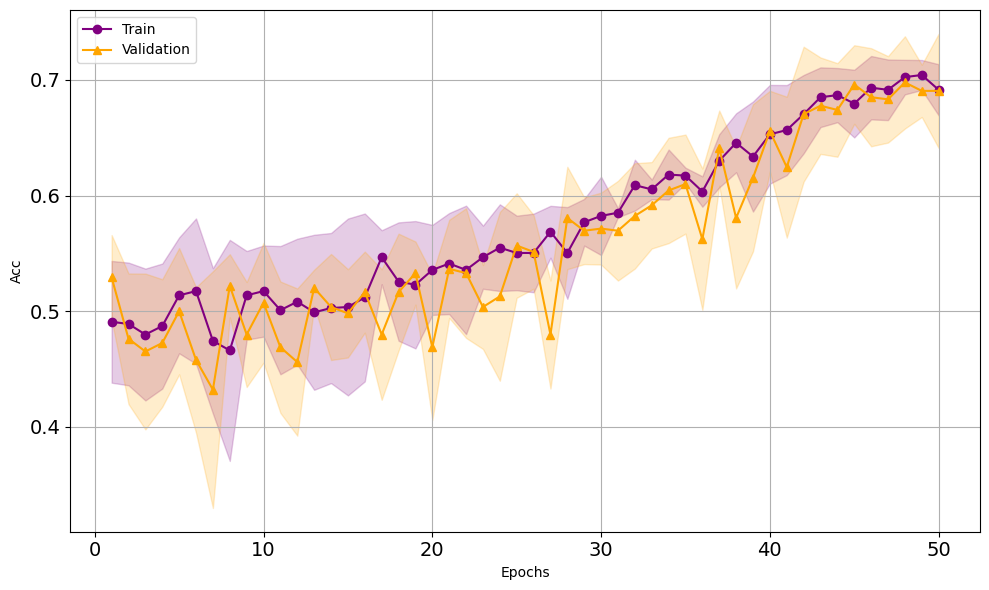

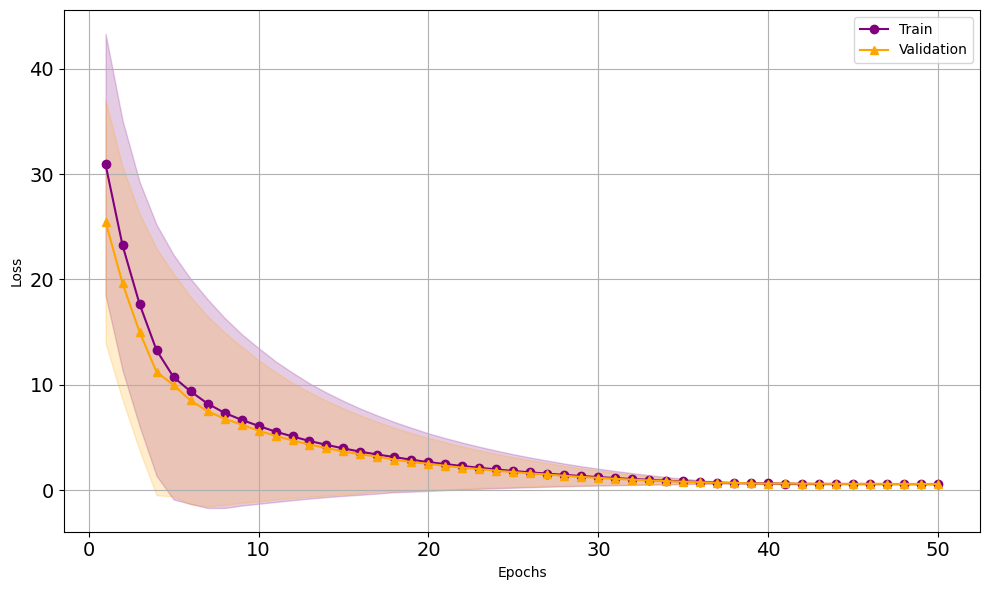

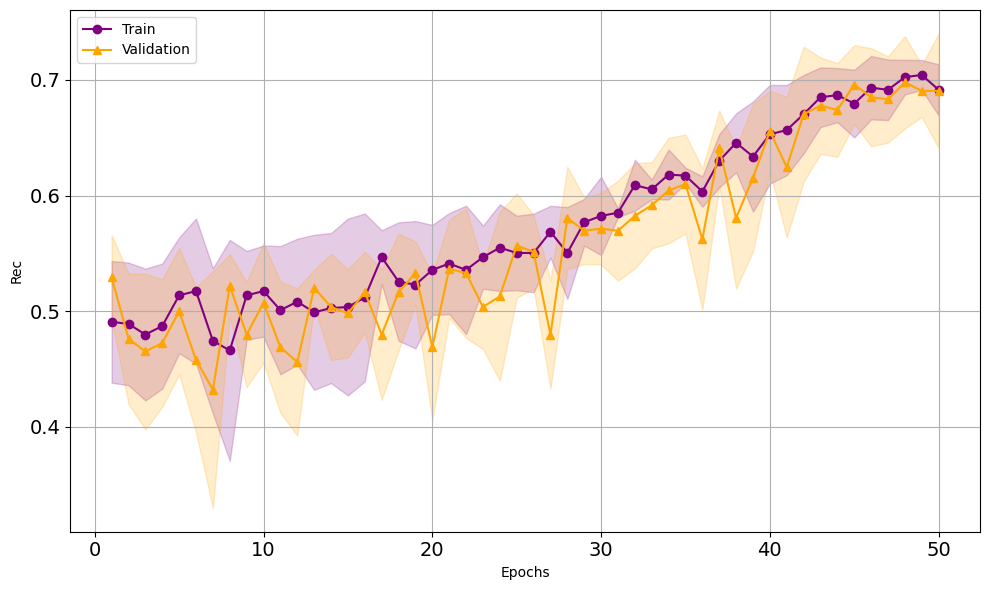

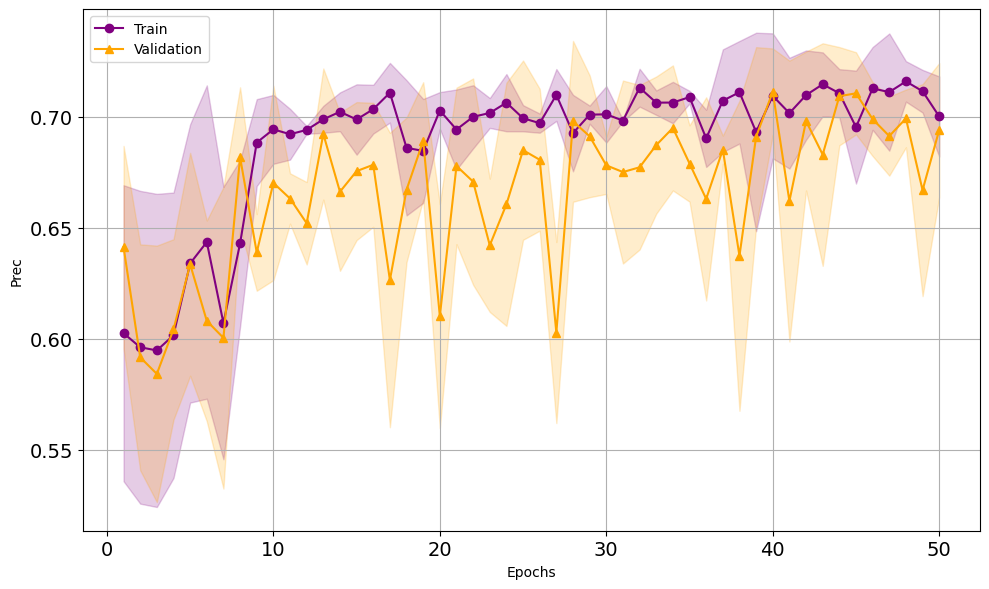

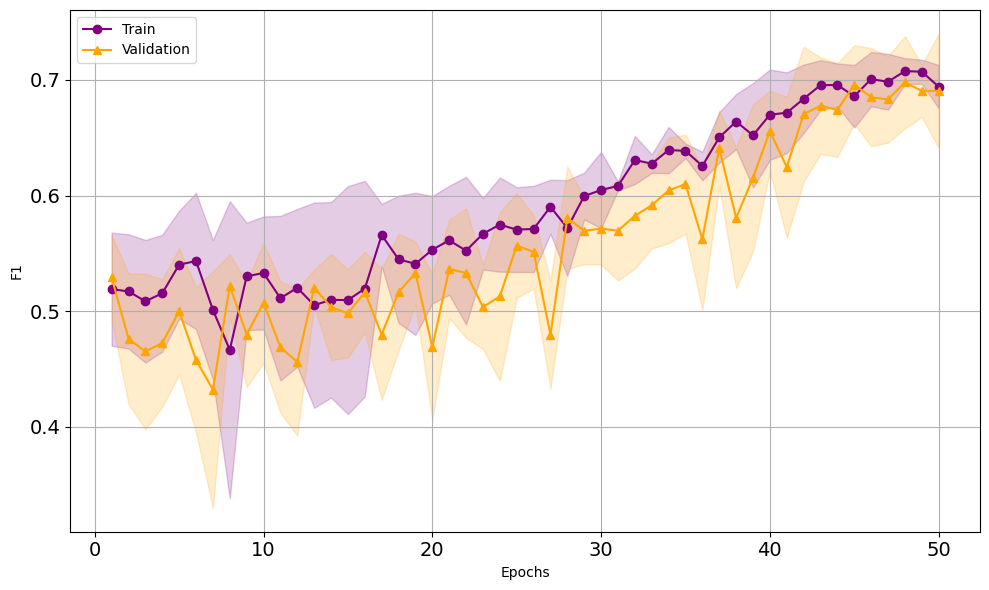

In [21]:
epochs_range = list(range(1, len(train_metrics_folds["acc"][0]) + 1))

metrics_summary = {}

for metric in ["acc", "loss", "rec", "prec", "f1"]:
    summary = plot_metric_with_std(metric, train_metrics_folds, val_metrics_folds, epochs_range,  classical=False, save_name=f"{model_name}_mean_{metric}_curve")
    metrics_summary[metric] = summary

# with open(f"/home/dalopezm/quantum-studies/quantum-cv/results/{model_name}_means_stds_metrics.json", "w") as f:
with open(f"/home/dalopezm/gaussian-qnns/results/{model_name}_means_stds_metrics.json", "w") as f:
    json.dump(metrics_summary, f, indent=4)

In [23]:
best_fold = -1
best_val_f1 = -1

for fold in range(1, n_folds+1):
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/{model_name}_fold_{fold}_metrics.pkl", "rb") as f:
    with open(f"/home/dalopezm/gaussian-qnns/model_checkpoints/{model_name}_fold_{fold}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    last_val_f1 = val_metrics["f1"][-1]

    if last_val_f1 > best_val_f1:
        best_val_f1 = last_val_f1
        best_fold = fold

print(f"Best fold: {best_fold} with val_f1 = {best_val_f1:.4f}")

Best fold: 3 with val_f1 = 0.7308


In [24]:
device = "cpu"
test_cv_model = QuantumLinear(n_qumodes=4, n_classes=2).to(device)

# test_cv_model.load_state_dict(torch.load(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/{model_name}_fold_{best_fold}_best.pth"))
test_cv_model.load_state_dict(torch.load(f"/home/dalopezm/gaussian-qnns/model_checkpoints/{model_name}_fold_{best_fold}_best.pth"))
test_cv_model.to(device)

test_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

test_loss, test_acc, test_prec, test_rec, test_f1, test_report, test_preds, cv_test_probs, cv_test_labels = evaluate_v2(test_cv_model, test_loader, optimizer, criterion, device)

test_metrics["acc"].append(test_acc)
test_metrics["loss"].append(test_loss)
test_metrics["rec"].append(test_rec)
test_metrics["prec"].append(test_prec)
test_metrics["f1"].append(test_f1)

print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f} | Test rec: {test_rec:.4f} | Test prec: {test_prec:.4f} | Test f1: {test_f1:.4f}")

# with open(f"/home/dalopezm/quantum-studies/quantum-cv/results/{model_name}_test_metrics.json", "w") as f:
with open(f"/home/dalopezm/gaussian-qnns/results/{model_name}_test_metrics.json", "w") as f:
    json.dump(test_metrics, f, indent=4)

Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 10.85it/s, loss=0.5133, acc=0.7

Test loss: 0.5133 | Test acc: 0.7756 | Test rec: 0.7756 | Test prec: 0.7613 | Test f1: 0.7756


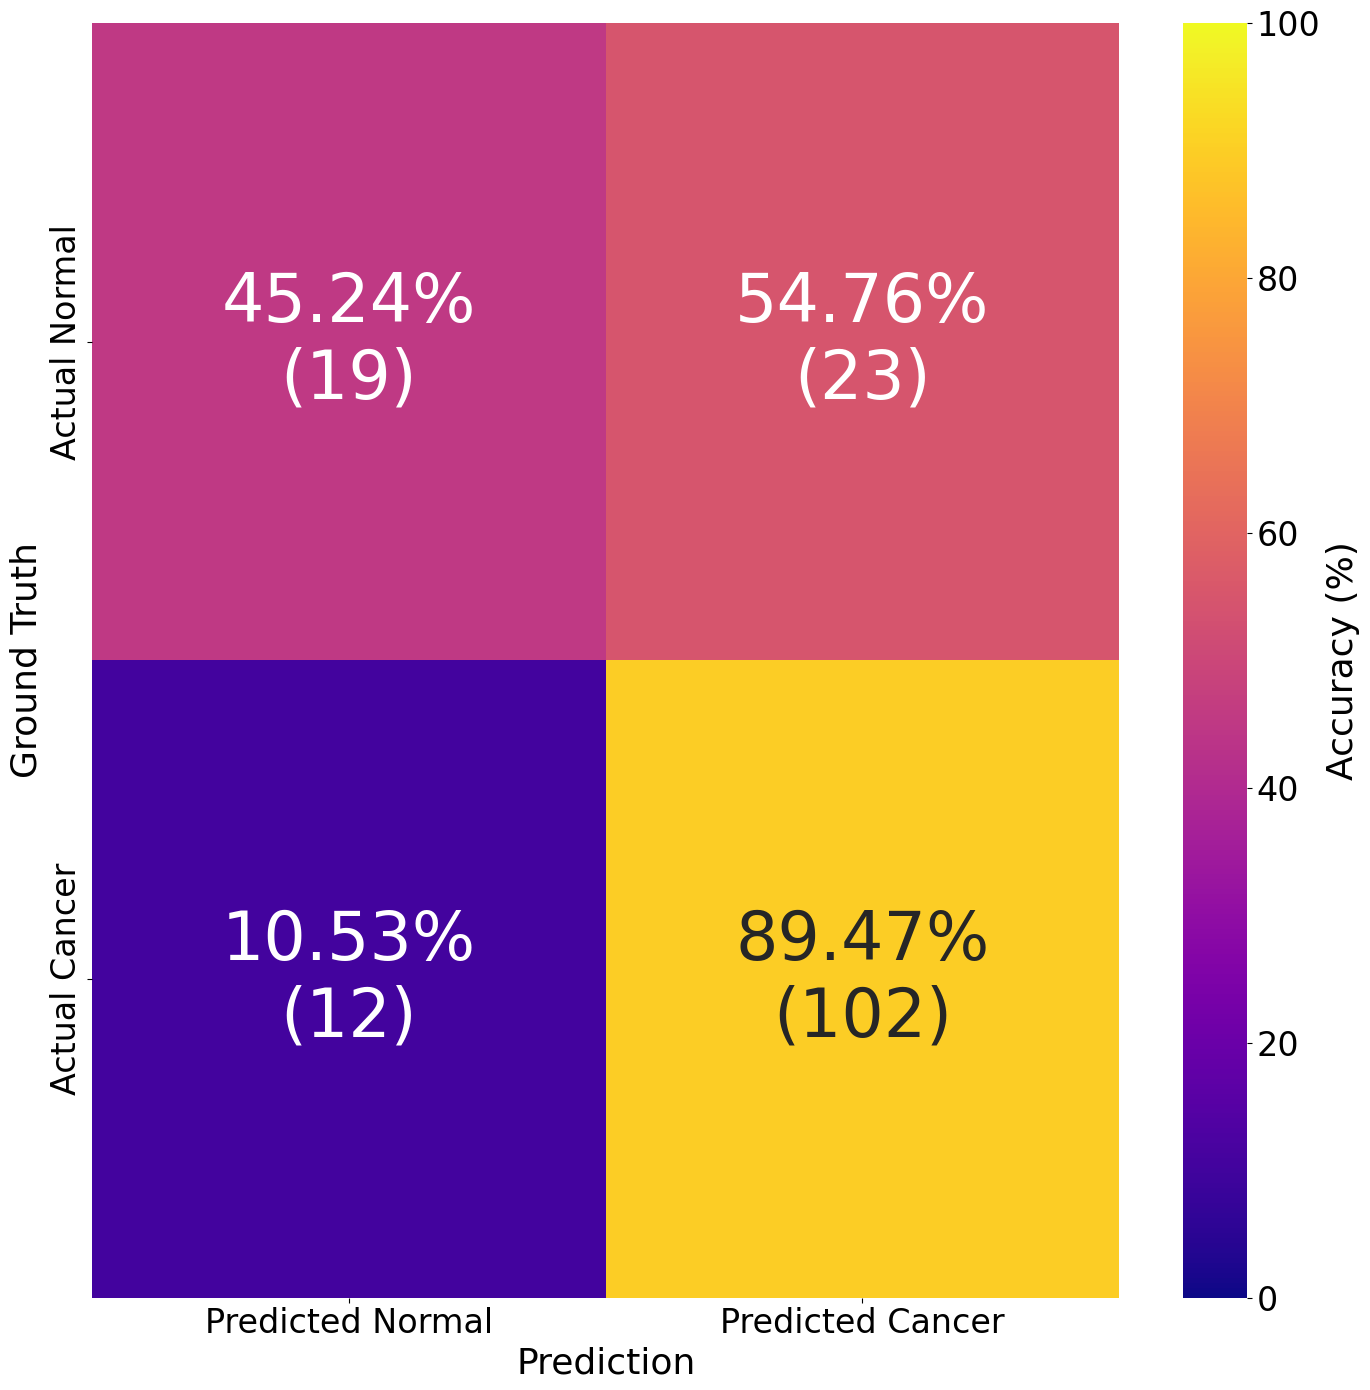

In [24]:
label_names = ["Normal", "Cancer"]

plot_confusion_matrix(cv_test_labels, test_preds, label_names, model_name, binary=True)

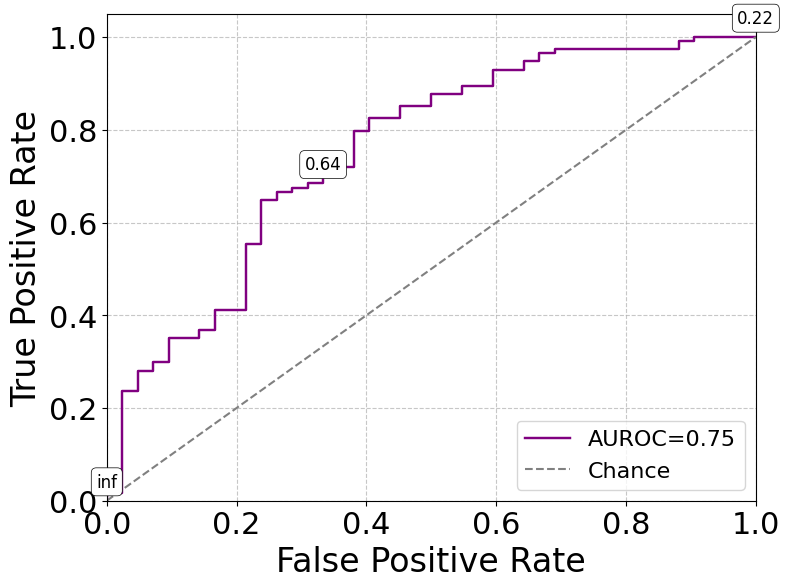

In [25]:
plot_auroc(cv_test_labels, cv_test_probs, model_name, binary=True)

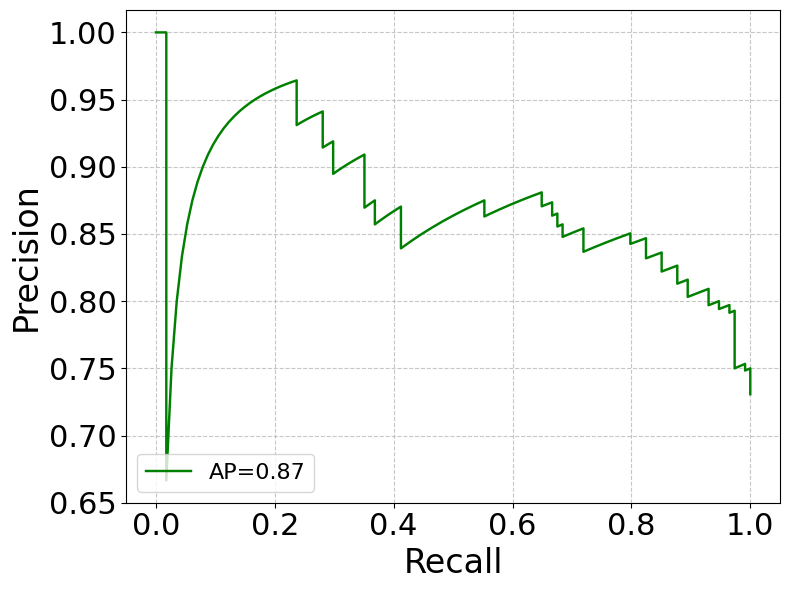

In [26]:
plot_prec(cv_test_labels, cv_test_probs, model_name, binary=True)

In [27]:
cam, outputs, predictions = gradcam_model(test_cv_model, x_test_tensor[0:16], quantum=True)
print(cam.shape)

torch.Size([16, 4])


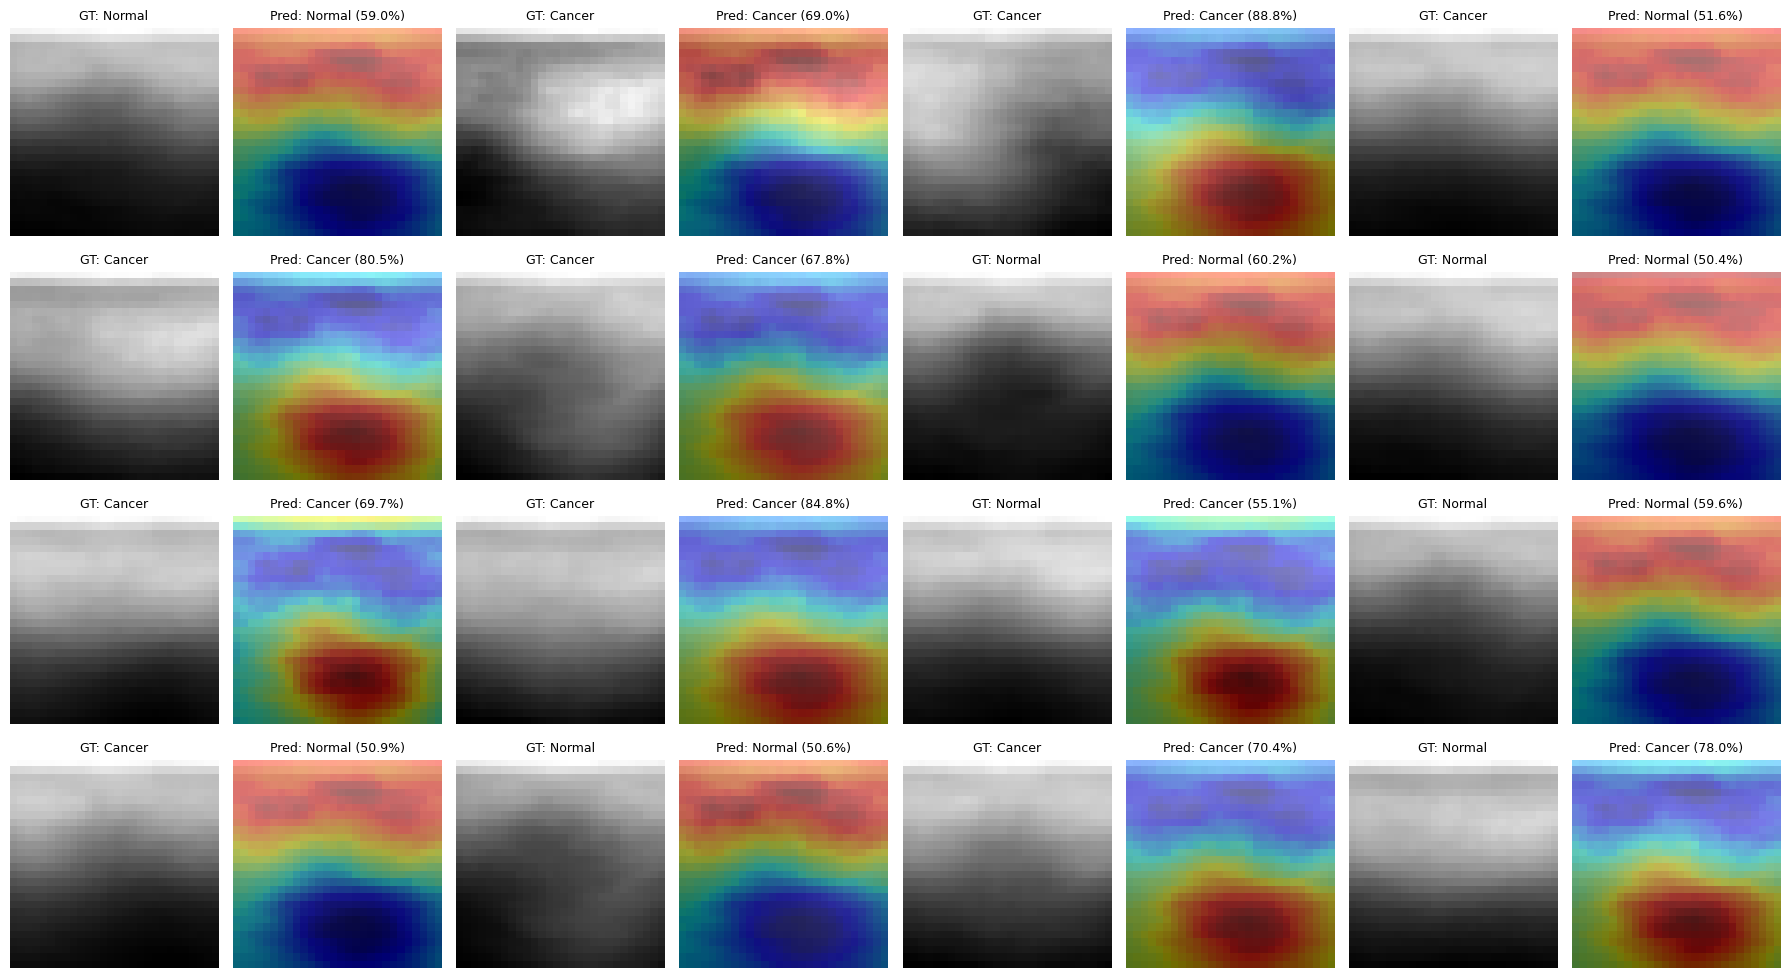

In [28]:
plot_reconstructed_heatmaps_with_predictions(
    samples = x_test_tensor[0:16].to(device),
    cam = cam,
    preds = predictions,
    probs = outputs,
    labels = y_test_tensor[0:16].to(device),
    encoder = encoder,
    class_names = label_names,
)

## DISCRETE VARIABLE

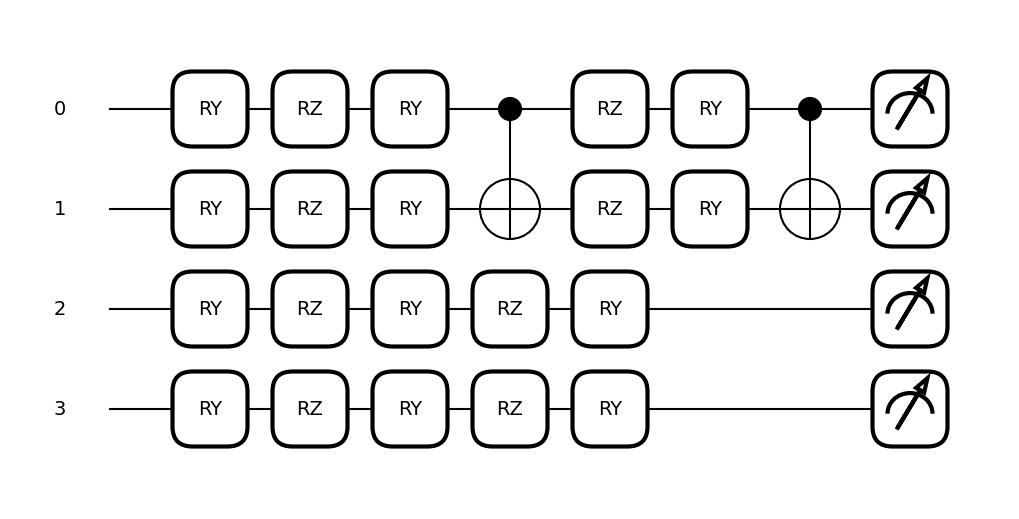

In [25]:
n_qubits = 4
# dummy_inputs = torch.zeros(n_qubits)
# dummy_weights = torch.zeros((2, n_qubits, 4))

# fig, ax = draw_mpl(dv_qcnn)(dummy_inputs, dummy_weights, n_qubits)

dummy_inputs = torch.zeros(n_qubits)
dummy_weights = torch.zeros((2, n_qubits, 4))

dv_qcnn_qnode = get_dv_qcnn_qnode(n_qubits)
fig, ax = draw_mpl(dv_qcnn_qnode)(dummy_inputs, dummy_weights)
fig.show()

In [26]:
epochs = 50
device = "cpu"
dv_model = DVQuantumLinear(n_qubits=4, n_classes=2).to(device)

# optimizer = torch.optim.Adam(dv_model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(dv_model.parameters(), lr=3e-3)
criterion = nn.CrossEntropyLoss()

from torchinfo import summary
summary(dv_model)

Layer (type:depth-idx)                   Param #
DVQuantumLinear                          --
├─TorchLayer: 1-1                        32
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       10
Total params: 42
Trainable params: 42
Non-trainable params: 0

In [27]:
model_name = "dv_breast"

In [32]:
run_kfold_training(DVQuantumLinear, train_dataset, optimizer, criterion, n_classes, model_name, device=device, classical=False, k=3, num_epochs=epochs, seed=42)


 Fold 1/3
 
Epoch 1/50 (fold 1)


Training | Fold 1 | Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.6683, acc=0.6648]
Training | Fold 1 | Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.01it/s, loss=0.6706, acc=0.6538]


Train loss: 0.6683 | Train acc: 0.6648 | Train rec: 0.6648 | Train prec: 0.6472 | Train f1: 0.6548
Val loss: 0.6706 | Val acc: 0.6538 | Val rec: 0.6538 | Val prec: 0.5915 | Val f1: 0.6538
 
Epoch 2/50 (fold 1)


Training | Fold 1 | Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.6600, acc=0.6951]
Training | Fold 1 | Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.96it/s, loss=0.6628, acc=0.7253]


Train loss: 0.6600 | Train acc: 0.6951 | Train rec: 0.6951 | Train prec: 0.6414 | Train f1: 0.6548
Val loss: 0.6628 | Val acc: 0.7253 | Val rec: 0.7253 | Val prec: 0.6651 | Val f1: 0.7253
 
Epoch 3/50 (fold 1)


Training | Fold 1 | Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.6525, acc=0.7060]
Training | Fold 1 | Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.97it/s, loss=0.6552, acc=0.7253]


Train loss: 0.6525 | Train acc: 0.7060 | Train rec: 0.7060 | Train prec: 0.6275 | Train f1: 0.6399
Val loss: 0.6552 | Val acc: 0.7253 | Val rec: 0.7253 | Val prec: 0.6246 | Val f1: 0.7253
 
Epoch 4/50 (fold 1)


Training | Fold 1 | Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.6450, acc=0.7198]
Training | Fold 1 | Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.97it/s, loss=0.6482, acc=0.7253]


Train loss: 0.6450 | Train acc: 0.7198 | Train rec: 0.7198 | Train prec: 0.6327 | Train f1: 0.6338
Val loss: 0.6482 | Val acc: 0.7253 | Val rec: 0.7253 | Val prec: 0.5329 | Val f1: 0.7253
 
Epoch 5/50 (fold 1)


Training | Fold 1 | Epoch 5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.6379, acc=0.7253]
Training | Fold 1 | Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.97it/s, loss=0.6417, acc=0.7308]


Train loss: 0.6379 | Train acc: 0.7253 | Train rec: 0.7253 | Train prec: 0.6367 | Train f1: 0.6285
Val loss: 0.6417 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 6/50 (fold 1)


Training | Fold 1 | Epoch 6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.6311, acc=0.7253]
Training | Fold 1 | Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.97it/s, loss=0.6353, acc=0.7308]


Train loss: 0.6311 | Train acc: 0.7253 | Train rec: 0.7253 | Train prec: 0.6012 | Train f1: 0.6193
Val loss: 0.6353 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 7/50 (fold 1)


Training | Fold 1 | Epoch 7: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.6244, acc=0.7308]
Training | Fold 1 | Epoch 7: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.97it/s, loss=0.6292, acc=0.7308]


Train loss: 0.6244 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.6696 | Train f1: 0.6221
Val loss: 0.6292 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 8/50 (fold 1)


Training | Fold 1 | Epoch 8: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.6185, acc=0.7335]
Training | Fold 1 | Epoch 8: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.96it/s, loss=0.6228, acc=0.7308]


Train loss: 0.6185 | Train acc: 0.7335 | Train rec: 0.7335 | Train prec: 0.8047 | Train f1: 0.6235
Val loss: 0.6228 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 9/50 (fold 1)


Training | Fold 1 | Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.6117, acc=0.7308]
Training | Fold 1 | Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.96it/s, loss=0.6174, acc=0.7308]


Train loss: 0.6117 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.6696 | Train f1: 0.6221
Val loss: 0.6174 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 10/50 (fold 1)


Training | Fold 1 | Epoch 10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.6060, acc=0.7335]
Training | Fold 1 | Epoch 10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.96it/s, loss=0.6116, acc=0.7308]


Train loss: 0.6060 | Train acc: 0.7335 | Train rec: 0.7335 | Train prec: 0.7159 | Train f1: 0.6284
Val loss: 0.6116 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 11/50 (fold 1)


Training | Fold 1 | Epoch 11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.6002, acc=0.7308]
Training | Fold 1 | Epoch 11: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.96it/s, loss=0.6063, acc=0.7308]


Train loss: 0.6002 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.6705 | Train f1: 0.6269
Val loss: 0.6063 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 12/50 (fold 1)


Training | Fold 1 | Epoch 12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.5946, acc=0.7308]
Training | Fold 1 | Epoch 12: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.96it/s, loss=0.6015, acc=0.7308]


Train loss: 0.5946 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.6705 | Train f1: 0.6269
Val loss: 0.6015 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 13/50 (fold 1)


Training | Fold 1 | Epoch 13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.5893, acc=0.7335]
Training | Fold 1 | Epoch 13: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.96it/s, loss=0.5969, acc=0.7308]


Train loss: 0.5893 | Train acc: 0.7335 | Train rec: 0.7335 | Train prec: 0.6989 | Train f1: 0.6330
Val loss: 0.5969 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 14/50 (fold 1)


Training | Fold 1 | Epoch 14: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.5840, acc=0.7335]
Training | Fold 1 | Epoch 14: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.96it/s, loss=0.5925, acc=0.7308]


Train loss: 0.5840 | Train acc: 0.7335 | Train rec: 0.7335 | Train prec: 0.6989 | Train f1: 0.6330
Val loss: 0.5925 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 15/50 (fold 1)


Training | Fold 1 | Epoch 15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.5794, acc=0.7335]
Training | Fold 1 | Epoch 15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.96it/s, loss=0.5880, acc=0.7308]


Train loss: 0.5794 | Train acc: 0.7335 | Train rec: 0.7335 | Train prec: 0.6989 | Train f1: 0.6330
Val loss: 0.5880 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 16/50 (fold 1)


Training | Fold 1 | Epoch 16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.5745, acc=0.7335]
Training | Fold 1 | Epoch 16: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.59it/s, loss=0.5840, acc=0.7308]


Train loss: 0.5745 | Train acc: 0.7335 | Train rec: 0.7335 | Train prec: 0.6989 | Train f1: 0.6330
Val loss: 0.5840 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 17/50 (fold 1)


Training | Fold 1 | Epoch 17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.5703, acc=0.7363]
Training | Fold 1 | Epoch 17: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.95it/s, loss=0.5801, acc=0.7308]


Train loss: 0.5703 | Train acc: 0.7363 | Train rec: 0.7363 | Train prec: 0.7184 | Train f1: 0.6391
Val loss: 0.5801 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 18/50 (fold 1)


Training | Fold 1 | Epoch 18: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.13it/s, loss=0.5661, acc=0.7363]
Training | Fold 1 | Epoch 18: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.98it/s, loss=0.5768, acc=0.7308]


Train loss: 0.5661 | Train acc: 0.7363 | Train rec: 0.7363 | Train prec: 0.7184 | Train f1: 0.6391
Val loss: 0.5768 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 19/50 (fold 1)


Training | Fold 1 | Epoch 19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.13it/s, loss=0.5624, acc=0.7363]
Training | Fold 1 | Epoch 19: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.00it/s, loss=0.5738, acc=0.7363]


Train loss: 0.5624 | Train acc: 0.7363 | Train rec: 0.7363 | Train prec: 0.7184 | Train f1: 0.6391
Val loss: 0.5738 | Val acc: 0.7363 | Val rec: 0.7363 | Val prec: 0.8062 | Val f1: 0.7363
 
Epoch 20/50 (fold 1)


Training | Fold 1 | Epoch 20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.13it/s, loss=0.5592, acc=0.7390]
Training | Fold 1 | Epoch 20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.96it/s, loss=0.5710, acc=0.7363]


Train loss: 0.5592 | Train acc: 0.7390 | Train rec: 0.7390 | Train prec: 0.7327 | Train f1: 0.6450
Val loss: 0.5710 | Val acc: 0.7363 | Val rec: 0.7363 | Val prec: 0.8062 | Val f1: 0.7363
 
Epoch 21/50 (fold 1)


Training | Fold 1 | Epoch 21: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.5561, acc=0.7390]
Training | Fold 1 | Epoch 21: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.99it/s, loss=0.5685, acc=0.7363]


Train loss: 0.5561 | Train acc: 0.7390 | Train rec: 0.7390 | Train prec: 0.7327 | Train f1: 0.6450
Val loss: 0.5685 | Val acc: 0.7363 | Val rec: 0.7363 | Val prec: 0.8062 | Val f1: 0.7363
 
Epoch 22/50 (fold 1)


Training | Fold 1 | Epoch 22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.13it/s, loss=0.5531, acc=0.7390]
Training | Fold 1 | Epoch 22: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.97it/s, loss=0.5664, acc=0.7363]


Train loss: 0.5531 | Train acc: 0.7390 | Train rec: 0.7390 | Train prec: 0.7209 | Train f1: 0.6492
Val loss: 0.5664 | Val acc: 0.7363 | Val rec: 0.7363 | Val prec: 0.8062 | Val f1: 0.7363
 
Epoch 23/50 (fold 1)


Training | Fold 1 | Epoch 23: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.5506, acc=0.7418]
Training | Fold 1 | Epoch 23: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.93it/s, loss=0.5644, acc=0.7363]


Train loss: 0.5506 | Train acc: 0.7418 | Train rec: 0.7418 | Train prec: 0.7314 | Train f1: 0.6549
Val loss: 0.5644 | Val acc: 0.7363 | Val rec: 0.7363 | Val prec: 0.8062 | Val f1: 0.7363
 
Epoch 24/50 (fold 1)


Training | Fold 1 | Epoch 24: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.5481, acc=0.7418]
Training | Fold 1 | Epoch 24: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.99it/s, loss=0.5628, acc=0.7363]


Train loss: 0.5481 | Train acc: 0.7418 | Train rec: 0.7418 | Train prec: 0.7234 | Train f1: 0.6588
Val loss: 0.5628 | Val acc: 0.7363 | Val rec: 0.7363 | Val prec: 0.8062 | Val f1: 0.7363
 
Epoch 25/50 (fold 1)


Training | Fold 1 | Epoch 25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.13it/s, loss=0.5460, acc=0.7445]
Training | Fold 1 | Epoch 25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.99it/s, loss=0.5611, acc=0.7363]


Train loss: 0.5460 | Train acc: 0.7445 | Train rec: 0.7445 | Train prec: 0.7319 | Train f1: 0.6643
Val loss: 0.5611 | Val acc: 0.7363 | Val rec: 0.7363 | Val prec: 0.8062 | Val f1: 0.7363
 
Epoch 26/50 (fold 1)


Training | Fold 1 | Epoch 26: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.13it/s, loss=0.5441, acc=0.7445]
Training | Fold 1 | Epoch 26: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.99it/s, loss=0.5598, acc=0.7363]


Train loss: 0.5441 | Train acc: 0.7445 | Train rec: 0.7445 | Train prec: 0.7319 | Train f1: 0.6643
Val loss: 0.5598 | Val acc: 0.7363 | Val rec: 0.7363 | Val prec: 0.8062 | Val f1: 0.7363
 
Epoch 27/50 (fold 1)


Training | Fold 1 | Epoch 27: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.5422, acc=0.7500]
Training | Fold 1 | Epoch 27: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.95it/s, loss=0.5585, acc=0.7363]


Train loss: 0.5422 | Train acc: 0.7500 | Train rec: 0.7500 | Train prec: 0.7460 | Train f1: 0.6751
Val loss: 0.5585 | Val acc: 0.7363 | Val rec: 0.7363 | Val prec: 0.8062 | Val f1: 0.7363
 
Epoch 28/50 (fold 1)


Training | Fold 1 | Epoch 28: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.5408, acc=0.7500]
Training | Fold 1 | Epoch 28: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.95it/s, loss=0.5575, acc=0.7363]


Train loss: 0.5408 | Train acc: 0.7500 | Train rec: 0.7500 | Train prec: 0.7460 | Train f1: 0.6751
Val loss: 0.5575 | Val acc: 0.7363 | Val rec: 0.7363 | Val prec: 0.8062 | Val f1: 0.7363
 
Epoch 29/50 (fold 1)


Training | Fold 1 | Epoch 29: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.5392, acc=0.7500]
Training | Fold 1 | Epoch 29: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.95it/s, loss=0.5566, acc=0.7363]


Train loss: 0.5392 | Train acc: 0.7500 | Train rec: 0.7500 | Train prec: 0.7460 | Train f1: 0.6751
Val loss: 0.5566 | Val acc: 0.7363 | Val rec: 0.7363 | Val prec: 0.8062 | Val f1: 0.7363
 
Epoch 30/50 (fold 1)


Training | Fold 1 | Epoch 30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.5380, acc=0.7500]
Training | Fold 1 | Epoch 30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.96it/s, loss=0.5557, acc=0.7363]


Train loss: 0.5380 | Train acc: 0.7500 | Train rec: 0.7500 | Train prec: 0.7460 | Train f1: 0.6751
Val loss: 0.5557 | Val acc: 0.7363 | Val rec: 0.7363 | Val prec: 0.8062 | Val f1: 0.7363
 
Epoch 31/50 (fold 1)


Training | Fold 1 | Epoch 31: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.08it/s, loss=0.5367, acc=0.7500]
Training | Fold 1 | Epoch 31: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.90it/s, loss=0.5549, acc=0.7308]


Train loss: 0.5367 | Train acc: 0.7500 | Train rec: 0.7500 | Train prec: 0.7460 | Train f1: 0.6751
Val loss: 0.5549 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.6705 | Val f1: 0.7308
 
Epoch 32/50 (fold 1)


Training | Fold 1 | Epoch 32: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:06<00:00,  2.00it/s, loss=0.5355, acc=0.7473]
Training | Fold 1 | Epoch 32: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.90it/s, loss=0.5542, acc=0.7308]


Train loss: 0.5355 | Train acc: 0.7473 | Train rec: 0.7473 | Train prec: 0.7332 | Train f1: 0.6732
Val loss: 0.5542 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.6705 | Val f1: 0.7308
 
Epoch 33/50 (fold 1)


Training | Fold 1 | Epoch 33: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.08it/s, loss=0.5345, acc=0.7473]
Training | Fold 1 | Epoch 33: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.90it/s, loss=0.5535, acc=0.7308]


Train loss: 0.5345 | Train acc: 0.7473 | Train rec: 0.7473 | Train prec: 0.7332 | Train f1: 0.6732
Val loss: 0.5535 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.6705 | Val f1: 0.7308
 
Epoch 34/50 (fold 1)


Training | Fold 1 | Epoch 34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.08it/s, loss=0.5334, acc=0.7500]
Training | Fold 1 | Epoch 34: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.93it/s, loss=0.5530, acc=0.7308]


Train loss: 0.5334 | Train acc: 0.7500 | Train rec: 0.7500 | Train prec: 0.7397 | Train f1: 0.6785
Val loss: 0.5530 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.6705 | Val f1: 0.7308
 
Epoch 35/50 (fold 1)


Training | Fold 1 | Epoch 35: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.5326, acc=0.7527]
Training | Fold 1 | Epoch 35: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.97it/s, loss=0.5524, acc=0.7308]


Train loss: 0.5326 | Train acc: 0.7527 | Train rec: 0.7527 | Train prec: 0.7457 | Train f1: 0.6836
Val loss: 0.5524 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.6705 | Val f1: 0.7308
 
Epoch 36/50 (fold 1)


Training | Fold 1 | Epoch 36: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.5318, acc=0.7527]
Training | Fold 1 | Epoch 36: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.98it/s, loss=0.5521, acc=0.7198]


Train loss: 0.5318 | Train acc: 0.7527 | Train rec: 0.7527 | Train prec: 0.7457 | Train f1: 0.6836
Val loss: 0.5521 | Val acc: 0.7198 | Val rec: 0.7198 | Val prec: 0.6010 | Val f1: 0.7198
 
Epoch 37/50 (fold 1)


Training | Fold 1 | Epoch 37: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.13it/s, loss=0.5311, acc=0.7473]
Training | Fold 1 | Epoch 37: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.98it/s, loss=0.5517, acc=0.7308]


Train loss: 0.5311 | Train acc: 0.7473 | Train rec: 0.7473 | Train prec: 0.7252 | Train f1: 0.6799
Val loss: 0.5517 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.6744 | Val f1: 0.7308
 
Epoch 38/50 (fold 1)


Training | Fold 1 | Epoch 38: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.5303, acc=0.7473]
Training | Fold 1 | Epoch 38: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.97it/s, loss=0.5513, acc=0.7308]


Train loss: 0.5303 | Train acc: 0.7473 | Train rec: 0.7473 | Train prec: 0.7252 | Train f1: 0.6799
Val loss: 0.5513 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.6744 | Val f1: 0.7308
 
Epoch 39/50 (fold 1)


Training | Fold 1 | Epoch 39: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.5295, acc=0.7473]
Training | Fold 1 | Epoch 39: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.98it/s, loss=0.5509, acc=0.7308]


Train loss: 0.5295 | Train acc: 0.7473 | Train rec: 0.7473 | Train prec: 0.7252 | Train f1: 0.6799
Val loss: 0.5509 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.6744 | Val f1: 0.7308
 
Epoch 40/50 (fold 1)


Training | Fold 1 | Epoch 40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.5289, acc=0.7473]
Training | Fold 1 | Epoch 40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.98it/s, loss=0.5505, acc=0.7308]


Train loss: 0.5289 | Train acc: 0.7473 | Train rec: 0.7473 | Train prec: 0.7252 | Train f1: 0.6799
Val loss: 0.5505 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.6744 | Val f1: 0.7308
 
Epoch 41/50 (fold 1)


Training | Fold 1 | Epoch 41: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.5284, acc=0.7418]
Training | Fold 1 | Epoch 41: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.98it/s, loss=0.5501, acc=0.7308]


Train loss: 0.5284 | Train acc: 0.7418 | Train rec: 0.7418 | Train prec: 0.7082 | Train f1: 0.6761
Val loss: 0.5501 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.6744 | Val f1: 0.7308
 
Epoch 42/50 (fold 1)


Training | Fold 1 | Epoch 42: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.13it/s, loss=0.5276, acc=0.7418]
Training | Fold 1 | Epoch 42: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.00it/s, loss=0.5499, acc=0.7363]


Train loss: 0.5276 | Train acc: 0.7418 | Train rec: 0.7418 | Train prec: 0.7082 | Train f1: 0.6761
Val loss: 0.5499 | Val acc: 0.7363 | Val rec: 0.7363 | Val prec: 0.6967 | Val f1: 0.7363
 
Epoch 43/50 (fold 1)


Training | Fold 1 | Epoch 43: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.14it/s, loss=0.5272, acc=0.7418]
Training | Fold 1 | Epoch 43: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.95it/s, loss=0.5496, acc=0.7363]


Train loss: 0.5272 | Train acc: 0.7418 | Train rec: 0.7418 | Train prec: 0.7073 | Train f1: 0.6792
Val loss: 0.5496 | Val acc: 0.7363 | Val rec: 0.7363 | Val prec: 0.6967 | Val f1: 0.7363
 
Epoch 44/50 (fold 1)


Training | Fold 1 | Epoch 44: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.5267, acc=0.7445]
Training | Fold 1 | Epoch 44: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.94it/s, loss=0.5493, acc=0.7363]


Train loss: 0.5267 | Train acc: 0.7445 | Train rec: 0.7445 | Train prec: 0.7134 | Train f1: 0.6841
Val loss: 0.5493 | Val acc: 0.7363 | Val rec: 0.7363 | Val prec: 0.6967 | Val f1: 0.7363
 
Epoch 45/50 (fold 1)


Training | Fold 1 | Epoch 45: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.5262, acc=0.7445]
Training | Fold 1 | Epoch 45: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.95it/s, loss=0.5490, acc=0.7363]


Train loss: 0.5262 | Train acc: 0.7445 | Train rec: 0.7445 | Train prec: 0.7134 | Train f1: 0.6841
Val loss: 0.5490 | Val acc: 0.7363 | Val rec: 0.7363 | Val prec: 0.6967 | Val f1: 0.7363
 
Epoch 46/50 (fold 1)


Training | Fold 1 | Epoch 46: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.5258, acc=0.7473]
Training | Fold 1 | Epoch 46: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.95it/s, loss=0.5488, acc=0.7363]


Train loss: 0.5258 | Train acc: 0.7473 | Train rec: 0.7473 | Train prec: 0.7192 | Train f1: 0.6889
Val loss: 0.5488 | Val acc: 0.7363 | Val rec: 0.7363 | Val prec: 0.6967 | Val f1: 0.7363
 
Epoch 47/50 (fold 1)


Training | Fold 1 | Epoch 47: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.5254, acc=0.7473]
Training | Fold 1 | Epoch 47: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.65it/s, loss=0.5486, acc=0.7363]


Train loss: 0.5254 | Train acc: 0.7473 | Train rec: 0.7473 | Train prec: 0.7192 | Train f1: 0.6889
Val loss: 0.5486 | Val acc: 0.7363 | Val rec: 0.7363 | Val prec: 0.6967 | Val f1: 0.7363
 
Epoch 48/50 (fold 1)


Training | Fold 1 | Epoch 48: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.5249, acc=0.7473]
Training | Fold 1 | Epoch 48: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.95it/s, loss=0.5483, acc=0.7418]


Train loss: 0.5249 | Train acc: 0.7473 | Train rec: 0.7473 | Train prec: 0.7192 | Train f1: 0.6889
Val loss: 0.5483 | Val acc: 0.7418 | Val rec: 0.7418 | Val prec: 0.7142 | Val f1: 0.7418
 
Epoch 49/50 (fold 1)


Training | Fold 1 | Epoch 49: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.5247, acc=0.7473]
Training | Fold 1 | Epoch 49: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.96it/s, loss=0.5481, acc=0.7418]


Train loss: 0.5247 | Train acc: 0.7473 | Train rec: 0.7473 | Train prec: 0.7192 | Train f1: 0.6889
Val loss: 0.5481 | Val acc: 0.7418 | Val rec: 0.7418 | Val prec: 0.7142 | Val f1: 0.7418
 
Epoch 50/50 (fold 1)


Training | Fold 1 | Epoch 50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.5241, acc=0.7473]
Training | Fold 1 | Epoch 50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.95it/s, loss=0.5480, acc=0.7418]


Train loss: 0.5241 | Train acc: 0.7473 | Train rec: 0.7473 | Train prec: 0.7192 | Train f1: 0.6889
Val loss: 0.5480 | Val acc: 0.7418 | Val rec: 0.7418 | Val prec: 0.7142 | Val f1: 0.7418

 Fold 2/3
 
Epoch 1/50 (fold 2)


Training | Fold 2 | Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.6159, acc=0.7308]
Training | Fold 2 | Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.92it/s, loss=0.6146, acc=0.7308]


Train loss: 0.6159 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.6146 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 2/50 (fold 2)


Training | Fold 2 | Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.6118, acc=0.7308]
Training | Fold 2 | Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.94it/s, loss=0.6095, acc=0.7308]


Train loss: 0.6118 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.6095 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 3/50 (fold 2)


Training | Fold 2 | Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.6079, acc=0.7308]
Training | Fold 2 | Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.98it/s, loss=0.6057, acc=0.7308]


Train loss: 0.6079 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.6057 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 4/50 (fold 2)


Training | Fold 2 | Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.6050, acc=0.7308]
Training | Fold 2 | Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.98it/s, loss=0.6020, acc=0.7308]


Train loss: 0.6050 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.6020 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 5/50 (fold 2)


Training | Fold 2 | Epoch 5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.13it/s, loss=0.6015, acc=0.7308]
Training | Fold 2 | Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.98it/s, loss=0.5987, acc=0.7308]


Train loss: 0.6015 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5987 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 6/50 (fold 2)


Training | Fold 2 | Epoch 6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.5988, acc=0.7308]
Training | Fold 2 | Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.93it/s, loss=0.5953, acc=0.7308]


Train loss: 0.5988 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5953 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 7/50 (fold 2)


Training | Fold 2 | Epoch 7: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.5961, acc=0.7308]
Training | Fold 2 | Epoch 7: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.98it/s, loss=0.5922, acc=0.7308]


Train loss: 0.5961 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5922 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 8/50 (fold 2)


Training | Fold 2 | Epoch 8: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.5938, acc=0.7308]
Training | Fold 2 | Epoch 8: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.94it/s, loss=0.5893, acc=0.7308]


Train loss: 0.5938 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5893 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 9/50 (fold 2)


Training | Fold 2 | Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.5915, acc=0.7308]
Training | Fold 2 | Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.98it/s, loss=0.5864, acc=0.7308]


Train loss: 0.5915 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5864 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 10/50 (fold 2)


Training | Fold 2 | Epoch 10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.13it/s, loss=0.5894, acc=0.7308]
Training | Fold 2 | Epoch 10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.97it/s, loss=0.5837, acc=0.7308]


Train loss: 0.5894 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5837 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 11/50 (fold 2)


Training | Fold 2 | Epoch 11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.13it/s, loss=0.5873, acc=0.7308]
Training | Fold 2 | Epoch 11: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.97it/s, loss=0.5815, acc=0.7308]


Train loss: 0.5873 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5815 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 12/50 (fold 2)


Training | Fold 2 | Epoch 12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.13it/s, loss=0.5856, acc=0.7308]
Training | Fold 2 | Epoch 12: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.97it/s, loss=0.5794, acc=0.7308]


Train loss: 0.5856 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5794 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 13/50 (fold 2)


Training | Fold 2 | Epoch 13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.04it/s, loss=0.5838, acc=0.7308]
Training | Fold 2 | Epoch 13: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.97it/s, loss=0.5771, acc=0.7308]


Train loss: 0.5838 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5771 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 14/50 (fold 2)


Training | Fold 2 | Epoch 14: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.5822, acc=0.7308]
Training | Fold 2 | Epoch 14: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.99it/s, loss=0.5746, acc=0.7308]


Train loss: 0.5822 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5746 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 15/50 (fold 2)


Training | Fold 2 | Epoch 15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.5805, acc=0.7308]
Training | Fold 2 | Epoch 15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.96it/s, loss=0.5728, acc=0.7308]


Train loss: 0.5805 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5728 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 16/50 (fold 2)


Training | Fold 2 | Epoch 16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.5789, acc=0.7308]
Training | Fold 2 | Epoch 16: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.97it/s, loss=0.5709, acc=0.7308]


Train loss: 0.5789 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5709 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 17/50 (fold 2)


Training | Fold 2 | Epoch 17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.5774, acc=0.7308]
Training | Fold 2 | Epoch 17: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.99it/s, loss=0.5691, acc=0.7308]


Train loss: 0.5774 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5691 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 18/50 (fold 2)


Training | Fold 2 | Epoch 18: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.13it/s, loss=0.5759, acc=0.7308]
Training | Fold 2 | Epoch 18: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  3.00it/s, loss=0.5671, acc=0.7308]


Train loss: 0.5759 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5671 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 19/50 (fold 2)


Training | Fold 2 | Epoch 19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.13it/s, loss=0.5744, acc=0.7308]
Training | Fold 2 | Epoch 19: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.97it/s, loss=0.5653, acc=0.7308]


Train loss: 0.5744 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5653 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 20/50 (fold 2)


Training | Fold 2 | Epoch 20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.5731, acc=0.7308]
Training | Fold 2 | Epoch 20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.97it/s, loss=0.5632, acc=0.7308]


Train loss: 0.5731 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5632 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 21/50 (fold 2)


Training | Fold 2 | Epoch 21: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.5716, acc=0.7308]
Training | Fold 2 | Epoch 21: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.97it/s, loss=0.5616, acc=0.7308]


Train loss: 0.5716 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5616 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 22/50 (fold 2)


Training | Fold 2 | Epoch 22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.5702, acc=0.7308]
Training | Fold 2 | Epoch 22: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.97it/s, loss=0.5599, acc=0.7308]


Train loss: 0.5702 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5599 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 23/50 (fold 2)


Training | Fold 2 | Epoch 23: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.5687, acc=0.7308]
Training | Fold 2 | Epoch 23: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.94it/s, loss=0.5585, acc=0.7308]


Train loss: 0.5687 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5585 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 24/50 (fold 2)


Training | Fold 2 | Epoch 24: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.5673, acc=0.7308]
Training | Fold 2 | Epoch 24: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.00it/s, loss=0.5569, acc=0.7308]


Train loss: 0.5673 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5569 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 25/50 (fold 2)


Training | Fold 2 | Epoch 25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.14it/s, loss=0.5660, acc=0.7308]
Training | Fold 2 | Epoch 25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.00it/s, loss=0.5559, acc=0.7308]


Train loss: 0.5660 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5559 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 26/50 (fold 2)


Training | Fold 2 | Epoch 26: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.14it/s, loss=0.5646, acc=0.7308]
Training | Fold 2 | Epoch 26: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  3.00it/s, loss=0.5542, acc=0.7308]


Train loss: 0.5646 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5542 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 27/50 (fold 2)


Training | Fold 2 | Epoch 27: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.14it/s, loss=0.5631, acc=0.7308]
Training | Fold 2 | Epoch 27: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.98it/s, loss=0.5528, acc=0.7308]


Train loss: 0.5631 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5528 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 28/50 (fold 2)


Training | Fold 2 | Epoch 28: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.13it/s, loss=0.5619, acc=0.7308]
Training | Fold 2 | Epoch 28: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.69it/s, loss=0.5510, acc=0.7308]


Train loss: 0.5619 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5510 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 29/50 (fold 2)


Training | Fold 2 | Epoch 29: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.13it/s, loss=0.5605, acc=0.7308]
Training | Fold 2 | Epoch 29: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.00it/s, loss=0.5498, acc=0.7308]


Train loss: 0.5605 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5498 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 30/50 (fold 2)


Training | Fold 2 | Epoch 30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.14it/s, loss=0.5591, acc=0.7308]
Training | Fold 2 | Epoch 30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  3.00it/s, loss=0.5484, acc=0.7308]


Train loss: 0.5591 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5484 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 31/50 (fold 2)


Training | Fold 2 | Epoch 31: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.14it/s, loss=0.5579, acc=0.7308]
Training | Fold 2 | Epoch 31: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  3.00it/s, loss=0.5468, acc=0.7308]


Train loss: 0.5579 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5468 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 32/50 (fold 2)


Training | Fold 2 | Epoch 32: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.13it/s, loss=0.5566, acc=0.7308]
Training | Fold 2 | Epoch 32: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.97it/s, loss=0.5455, acc=0.7308]


Train loss: 0.5566 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5455 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 33/50 (fold 2)


Training | Fold 2 | Epoch 33: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.5554, acc=0.7308]
Training | Fold 2 | Epoch 33: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.99it/s, loss=0.5441, acc=0.7308]


Train loss: 0.5554 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5441 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 34/50 (fold 2)


Training | Fold 2 | Epoch 34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.14it/s, loss=0.5545, acc=0.7308]
Training | Fold 2 | Epoch 34: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.98it/s, loss=0.5424, acc=0.7308]


Train loss: 0.5545 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5424 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 35/50 (fold 2)


Training | Fold 2 | Epoch 35: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.5531, acc=0.7308]
Training | Fold 2 | Epoch 35: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.97it/s, loss=0.5415, acc=0.7308]


Train loss: 0.5531 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5415 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 36/50 (fold 2)


Training | Fold 2 | Epoch 36: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.5522, acc=0.7308]
Training | Fold 2 | Epoch 36: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.98it/s, loss=0.5404, acc=0.7308]


Train loss: 0.5522 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5404 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 37/50 (fold 2)


Training | Fold 2 | Epoch 37: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.5512, acc=0.7308]
Training | Fold 2 | Epoch 37: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.96it/s, loss=0.5391, acc=0.7308]


Train loss: 0.5512 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5391 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 38/50 (fold 2)


Training | Fold 2 | Epoch 38: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.5503, acc=0.7308]
Training | Fold 2 | Epoch 38: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.97it/s, loss=0.5385, acc=0.7308]


Train loss: 0.5503 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5385 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 39/50 (fold 2)


Training | Fold 2 | Epoch 39: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.5497, acc=0.7308]
Training | Fold 2 | Epoch 39: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.98it/s, loss=0.5376, acc=0.7308]


Train loss: 0.5497 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5376 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 40/50 (fold 2)


Training | Fold 2 | Epoch 40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.5485, acc=0.7308]
Training | Fold 2 | Epoch 40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.94it/s, loss=0.5367, acc=0.7308]


Train loss: 0.5485 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5367 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 41/50 (fold 2)


Training | Fold 2 | Epoch 41: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.5478, acc=0.7308]
Training | Fold 2 | Epoch 41: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.97it/s, loss=0.5359, acc=0.7308]


Train loss: 0.5478 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5359 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 42/50 (fold 2)


Training | Fold 2 | Epoch 42: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.5471, acc=0.7308]
Training | Fold 2 | Epoch 42: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.97it/s, loss=0.5352, acc=0.7308]


Train loss: 0.5471 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5352 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 43/50 (fold 2)


Training | Fold 2 | Epoch 43: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, loss=0.5463, acc=0.7308]
Training | Fold 2 | Epoch 43: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.97it/s, loss=0.5345, acc=0.7308]


Train loss: 0.5463 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5345 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 44/50 (fold 2)


Training | Fold 2 | Epoch 44: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.13it/s, loss=0.5455, acc=0.7308]
Training | Fold 2 | Epoch 44: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  3.00it/s, loss=0.5338, acc=0.7308]


Train loss: 0.5455 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5338 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 45/50 (fold 2)


Training | Fold 2 | Epoch 45: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.5449, acc=0.7308]
Training | Fold 2 | Epoch 45: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.94it/s, loss=0.5331, acc=0.7308]


Train loss: 0.5449 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5331 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 46/50 (fold 2)


Training | Fold 2 | Epoch 46: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.5442, acc=0.7308]
Training | Fold 2 | Epoch 46: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.94it/s, loss=0.5325, acc=0.7308]


Train loss: 0.5442 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5325 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 47/50 (fold 2)


Training | Fold 2 | Epoch 47: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.5437, acc=0.7308]
Training | Fold 2 | Epoch 47: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.94it/s, loss=0.5321, acc=0.7308]


Train loss: 0.5437 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5321 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 48/50 (fold 2)


Training | Fold 2 | Epoch 48: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.5432, acc=0.7308]
Training | Fold 2 | Epoch 48: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.88it/s, loss=0.5314, acc=0.7308]


Train loss: 0.5432 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5314 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 49/50 (fold 2)


Training | Fold 2 | Epoch 49: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.03it/s, loss=0.5425, acc=0.7308]
Training | Fold 2 | Epoch 49: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.95it/s, loss=0.5309, acc=0.7308]


Train loss: 0.5425 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5309 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308
 
Epoch 50/50 (fold 2)


Training | Fold 2 | Epoch 50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.5419, acc=0.7308]
Training | Fold 2 | Epoch 50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.94it/s, loss=0.5302, acc=0.7308]


Train loss: 0.5419 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5302 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308

 Fold 3/3
 
Epoch 1/50 (fold 3)


Training | Fold 3 | Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.9253, acc=0.2720]
Training | Fold 3 | Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.94it/s, loss=0.9214, acc=0.2692]


Train loss: 0.9253 | Train acc: 0.2720 | Train rec: 0.2720 | Train prec: 0.8035 | Train f1: 0.1199
Val loss: 0.9214 | Val acc: 0.2692 | Val rec: 0.2692 | Val prec: 0.0725 | Val f1: 0.2692
 
Epoch 2/50 (fold 3)


Training | Fold 3 | Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.8999, acc=0.2747]
Training | Fold 3 | Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.94it/s, loss=0.8965, acc=0.2692]


Train loss: 0.8999 | Train acc: 0.2747 | Train rec: 0.2747 | Train prec: 0.8037 | Train f1: 0.1256
Val loss: 0.8965 | Val acc: 0.2692 | Val rec: 0.2692 | Val prec: 0.0725 | Val f1: 0.2692
 
Epoch 3/50 (fold 3)


Training | Fold 3 | Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.8751, acc=0.2802]
Training | Fold 3 | Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.94it/s, loss=0.8736, acc=0.2692]


Train loss: 0.8751 | Train acc: 0.2802 | Train rec: 0.2802 | Train prec: 0.8041 | Train f1: 0.1369
Val loss: 0.8736 | Val acc: 0.2692 | Val rec: 0.2692 | Val prec: 0.0725 | Val f1: 0.2692
 
Epoch 4/50 (fold 3)


Training | Fold 3 | Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.8527, acc=0.2885]
Training | Fold 3 | Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.94it/s, loss=0.8519, acc=0.2747]


Train loss: 0.8527 | Train acc: 0.2885 | Train rec: 0.2885 | Train prec: 0.8047 | Train f1: 0.1535
Val loss: 0.8519 | Val acc: 0.2747 | Val rec: 0.2747 | Val prec: 0.8037 | Val f1: 0.2747
 
Epoch 5/50 (fold 3)


Training | Fold 3 | Epoch 5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.8312, acc=0.3022]
Training | Fold 3 | Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.93it/s, loss=0.8311, acc=0.2747]


Train loss: 0.8312 | Train acc: 0.3022 | Train rec: 0.3022 | Train prec: 0.8057 | Train f1: 0.1804
Val loss: 0.8311 | Val acc: 0.2747 | Val rec: 0.2747 | Val prec: 0.8037 | Val f1: 0.2747
 
Epoch 6/50 (fold 3)


Training | Fold 3 | Epoch 6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.09it/s, loss=0.8108, acc=0.3187]
Training | Fold 3 | Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.92it/s, loss=0.8119, acc=0.2747]


Train loss: 0.8108 | Train acc: 0.3187 | Train rec: 0.3187 | Train prec: 0.7701 | Train f1: 0.2153
Val loss: 0.8119 | Val acc: 0.2747 | Val rec: 0.2747 | Val prec: 0.5594 | Val f1: 0.2747
 
Epoch 7/50 (fold 3)


Training | Fold 3 | Epoch 7: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.13it/s, loss=0.7922, acc=0.3379]
Training | Fold 3 | Epoch 7: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.95it/s, loss=0.7940, acc=0.2692]


Train loss: 0.7922 | Train acc: 0.3379 | Train rec: 0.3379 | Train prec: 0.7575 | Train f1: 0.2531
Val loss: 0.7940 | Val acc: 0.2692 | Val rec: 0.2692 | Val prec: 0.4365 | Val f1: 0.2692
 
Epoch 8/50 (fold 3)


Training | Fold 3 | Epoch 8: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.7748, acc=0.3516]
Training | Fold 3 | Epoch 8: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.96it/s, loss=0.7774, acc=0.2802]


Train loss: 0.7748 | Train acc: 0.3516 | Train rec: 0.3516 | Train prec: 0.7661 | Train f1: 0.2767
Val loss: 0.7774 | Val acc: 0.2802 | Val rec: 0.2802 | Val prec: 0.5279 | Val f1: 0.2802
 
Epoch 9/50 (fold 3)


Training | Fold 3 | Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.7580, acc=0.3736]
Training | Fold 3 | Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.96it/s, loss=0.7623, acc=0.3077]


Train loss: 0.7580 | Train acc: 0.3736 | Train rec: 0.3736 | Train prec: 0.7007 | Train f1: 0.3289
Val loss: 0.7623 | Val acc: 0.3077 | Val rec: 0.3077 | Val prec: 0.6084 | Val f1: 0.3077
 
Epoch 10/50 (fold 3)


Training | Fold 3 | Epoch 10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.7436, acc=0.3819]
Training | Fold 3 | Epoch 10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.96it/s, loss=0.7478, acc=0.3516]


Train loss: 0.7436 | Train acc: 0.3819 | Train rec: 0.3819 | Train prec: 0.6733 | Train f1: 0.3507
Val loss: 0.7478 | Val acc: 0.3516 | Val rec: 0.3516 | Val prec: 0.6431 | Val f1: 0.3516
 
Epoch 11/50 (fold 3)


Training | Fold 3 | Epoch 11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.7295, acc=0.4121]
Training | Fold 3 | Epoch 11: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.96it/s, loss=0.7350, acc=0.3626]


Train loss: 0.7295 | Train acc: 0.4121 | Train rec: 0.4121 | Train prec: 0.6825 | Train f1: 0.3972
Val loss: 0.7350 | Val acc: 0.3626 | Val rec: 0.3626 | Val prec: 0.6277 | Val f1: 0.3626
 
Epoch 12/50 (fold 3)


Training | Fold 3 | Epoch 12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.7173, acc=0.4313]
Training | Fold 3 | Epoch 12: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.96it/s, loss=0.7228, acc=0.3901]


Train loss: 0.7173 | Train acc: 0.4313 | Train rec: 0.4313 | Train prec: 0.6487 | Train f1: 0.4362
Val loss: 0.7228 | Val acc: 0.3901 | Val rec: 0.3901 | Val prec: 0.6318 | Val f1: 0.3901
 
Epoch 13/50 (fold 3)


Training | Fold 3 | Epoch 13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.7057, acc=0.4863]
Training | Fold 3 | Epoch 13: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.96it/s, loss=0.7118, acc=0.4725]


Train loss: 0.7057 | Train acc: 0.4863 | Train rec: 0.4863 | Train prec: 0.6579 | Train f1: 0.5060
Val loss: 0.7118 | Val acc: 0.4725 | Val rec: 0.4725 | Val prec: 0.6539 | Val f1: 0.4725
 
Epoch 14/50 (fold 3)


Training | Fold 3 | Epoch 14: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.6948, acc=0.5027]
Training | Fold 3 | Epoch 14: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.98it/s, loss=0.7018, acc=0.4835]


Train loss: 0.6948 | Train acc: 0.5027 | Train rec: 0.5027 | Train prec: 0.6293 | Train f1: 0.5293
Val loss: 0.7018 | Val acc: 0.4835 | Val rec: 0.4835 | Val prec: 0.6105 | Val f1: 0.4835
 
Epoch 15/50 (fold 3)


Training | Fold 3 | Epoch 15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.13it/s, loss=0.6851, acc=0.5495]
Training | Fold 3 | Epoch 15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.97it/s, loss=0.6920, acc=0.5330]


Train loss: 0.6851 | Train acc: 0.5495 | Train rec: 0.5495 | Train prec: 0.6425 | Train f1: 0.5748
Val loss: 0.6920 | Val acc: 0.5330 | Val rec: 0.5330 | Val prec: 0.6213 | Val f1: 0.5330
 
Epoch 16/50 (fold 3)


Training | Fold 3 | Epoch 16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.13it/s, loss=0.6754, acc=0.5962]
Training | Fold 3 | Epoch 16: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.98it/s, loss=0.6836, acc=0.5879]


Train loss: 0.6754 | Train acc: 0.5962 | Train rec: 0.5962 | Train prec: 0.6458 | Train f1: 0.6142
Val loss: 0.6836 | Val acc: 0.5879 | Val rec: 0.5879 | Val prec: 0.6440 | Val f1: 0.5879
 
Epoch 17/50 (fold 3)


Training | Fold 3 | Epoch 17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.6673, acc=0.5989]
Training | Fold 3 | Epoch 17: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.63it/s, loss=0.6754, acc=0.6099]


Train loss: 0.6673 | Train acc: 0.5989 | Train rec: 0.5989 | Train prec: 0.6306 | Train f1: 0.6121
Val loss: 0.6754 | Val acc: 0.6099 | Val rec: 0.6099 | Val prec: 0.6363 | Val f1: 0.6099
 
Epoch 18/50 (fold 3)


Training | Fold 3 | Epoch 18: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.6596, acc=0.6319]
Training | Fold 3 | Epoch 18: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.94it/s, loss=0.6681, acc=0.6484]


Train loss: 0.6596 | Train acc: 0.6319 | Train rec: 0.6319 | Train prec: 0.6319 | Train f1: 0.6319
Val loss: 0.6681 | Val acc: 0.6484 | Val rec: 0.6484 | Val prec: 0.6484 | Val f1: 0.6484
 
Epoch 19/50 (fold 3)


Training | Fold 3 | Epoch 19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.6527, acc=0.6566]
Training | Fold 3 | Epoch 19: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.93it/s, loss=0.6614, acc=0.6703]


Train loss: 0.6527 | Train acc: 0.6566 | Train rec: 0.6566 | Train prec: 0.6442 | Train f1: 0.6499
Val loss: 0.6614 | Val acc: 0.6703 | Val rec: 0.6703 | Val prec: 0.6486 | Val f1: 0.6703
 
Epoch 20/50 (fold 3)


Training | Fold 3 | Epoch 20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.6462, acc=0.6676]
Training | Fold 3 | Epoch 20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.93it/s, loss=0.6552, acc=0.6758]


Train loss: 0.6462 | Train acc: 0.6676 | Train rec: 0.6676 | Train prec: 0.6444 | Train f1: 0.6539
Val loss: 0.6552 | Val acc: 0.6758 | Val rec: 0.6758 | Val prec: 0.6382 | Val f1: 0.6758
 
Epoch 21/50 (fold 3)


Training | Fold 3 | Epoch 21: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.6401, acc=0.6676]
Training | Fold 3 | Epoch 21: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.94it/s, loss=0.6493, acc=0.6703]


Train loss: 0.6401 | Train acc: 0.6676 | Train rec: 0.6676 | Train prec: 0.6322 | Train f1: 0.6455
Val loss: 0.6493 | Val acc: 0.6703 | Val rec: 0.6703 | Val prec: 0.6233 | Val f1: 0.6703
 
Epoch 22/50 (fold 3)


Training | Fold 3 | Epoch 22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.6345, acc=0.6731]
Training | Fold 3 | Epoch 22: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.93it/s, loss=0.6439, acc=0.6703]


Train loss: 0.6345 | Train acc: 0.6731 | Train rec: 0.6731 | Train prec: 0.6282 | Train f1: 0.6436
Val loss: 0.6439 | Val acc: 0.6703 | Val rec: 0.6703 | Val prec: 0.6172 | Val f1: 0.6703
 
Epoch 23/50 (fold 3)


Training | Fold 3 | Epoch 23: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.6291, acc=0.6593]
Training | Fold 3 | Epoch 23: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.94it/s, loss=0.6391, acc=0.6813]


Train loss: 0.6291 | Train acc: 0.6593 | Train rec: 0.6593 | Train prec: 0.5990 | Train f1: 0.6207
Val loss: 0.6391 | Val acc: 0.6813 | Val rec: 0.6813 | Val prec: 0.6261 | Val f1: 0.6813
 
Epoch 24/50 (fold 3)


Training | Fold 3 | Epoch 24: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.6247, acc=0.6731]
Training | Fold 3 | Epoch 24: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.93it/s, loss=0.6345, acc=0.6868]


Train loss: 0.6247 | Train acc: 0.6731 | Train rec: 0.6731 | Train prec: 0.6056 | Train f1: 0.6273
Val loss: 0.6345 | Val acc: 0.6868 | Val rec: 0.6868 | Val prec: 0.6246 | Val f1: 0.6868
 
Epoch 25/50 (fold 3)


Training | Fold 3 | Epoch 25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.6203, acc=0.6813]
Training | Fold 3 | Epoch 25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.95it/s, loss=0.6303, acc=0.6868]


Train loss: 0.6203 | Train acc: 0.6813 | Train rec: 0.6813 | Train prec: 0.6044 | Train f1: 0.6272
Val loss: 0.6303 | Val acc: 0.6868 | Val rec: 0.6868 | Val prec: 0.6246 | Val f1: 0.6868
 
Epoch 26/50 (fold 3)


Training | Fold 3 | Epoch 26: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.6165, acc=0.6841]
Training | Fold 3 | Epoch 26: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.95it/s, loss=0.6267, acc=0.6978]


Train loss: 0.6165 | Train acc: 0.6841 | Train rec: 0.6841 | Train prec: 0.6069 | Train f1: 0.6289
Val loss: 0.6267 | Val acc: 0.6978 | Val rec: 0.6978 | Val prec: 0.6355 | Val f1: 0.6978
 
Epoch 27/50 (fold 3)


Training | Fold 3 | Epoch 27: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.6129, acc=0.6841]
Training | Fold 3 | Epoch 27: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.95it/s, loss=0.6234, acc=0.6923]


Train loss: 0.6129 | Train acc: 0.6841 | Train rec: 0.6841 | Train prec: 0.6069 | Train f1: 0.6289
Val loss: 0.6234 | Val acc: 0.6923 | Val rec: 0.6923 | Val prec: 0.6230 | Val f1: 0.6923
 
Epoch 28/50 (fold 3)


Training | Fold 3 | Epoch 28: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.6098, acc=0.6868]
Training | Fold 3 | Epoch 28: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.93it/s, loss=0.6205, acc=0.6978]


Train loss: 0.6098 | Train acc: 0.6868 | Train rec: 0.6868 | Train prec: 0.6000 | Train f1: 0.6246
Val loss: 0.6205 | Val acc: 0.6978 | Val rec: 0.6978 | Val prec: 0.6289 | Val f1: 0.6978
 
Epoch 29/50 (fold 3)


Training | Fold 3 | Epoch 29: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.6070, acc=0.6868]
Training | Fold 3 | Epoch 29: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.94it/s, loss=0.6179, acc=0.6978]


Train loss: 0.6070 | Train acc: 0.6868 | Train rec: 0.6868 | Train prec: 0.5945 | Train f1: 0.6214
Val loss: 0.6179 | Val acc: 0.6978 | Val rec: 0.6978 | Val prec: 0.6212 | Val f1: 0.6978
 
Epoch 30/50 (fold 3)


Training | Fold 3 | Epoch 30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.6047, acc=0.6923]
Training | Fold 3 | Epoch 30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.94it/s, loss=0.6155, acc=0.6923]


Train loss: 0.6047 | Train acc: 0.6923 | Train rec: 0.6923 | Train prec: 0.6002 | Train f1: 0.6247
Val loss: 0.6155 | Val acc: 0.6923 | Val rec: 0.6923 | Val prec: 0.6057 | Val f1: 0.6923
 
Epoch 31/50 (fold 3)


Training | Fold 3 | Epoch 31: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.6023, acc=0.7005]
Training | Fold 3 | Epoch 31: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.94it/s, loss=0.6133, acc=0.6923]


Train loss: 0.6023 | Train acc: 0.7005 | Train rec: 0.7005 | Train prec: 0.6100 | Train f1: 0.6298
Val loss: 0.6133 | Val acc: 0.6923 | Val rec: 0.6923 | Val prec: 0.6057 | Val f1: 0.6923
 
Epoch 32/50 (fold 3)


Training | Fold 3 | Epoch 32: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.6001, acc=0.7033]
Training | Fold 3 | Epoch 32: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.94it/s, loss=0.6114, acc=0.6923]


Train loss: 0.6001 | Train acc: 0.7033 | Train rec: 0.7033 | Train prec: 0.6137 | Train f1: 0.6314
Val loss: 0.6114 | Val acc: 0.6923 | Val rec: 0.6923 | Val prec: 0.6057 | Val f1: 0.6923
 
Epoch 33/50 (fold 3)


Training | Fold 3 | Epoch 33: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.5980, acc=0.7033]
Training | Fold 3 | Epoch 33: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.95it/s, loss=0.6095, acc=0.6923]


Train loss: 0.5980 | Train acc: 0.7033 | Train rec: 0.7033 | Train prec: 0.6137 | Train f1: 0.6314
Val loss: 0.6095 | Val acc: 0.6923 | Val rec: 0.6923 | Val prec: 0.6057 | Val f1: 0.6923
 
Epoch 34/50 (fold 3)


Training | Fold 3 | Epoch 34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.5962, acc=0.7033]
Training | Fold 3 | Epoch 34: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.94it/s, loss=0.6075, acc=0.6923]


Train loss: 0.5962 | Train acc: 0.7033 | Train rec: 0.7033 | Train prec: 0.6137 | Train f1: 0.6314
Val loss: 0.6075 | Val acc: 0.6923 | Val rec: 0.6923 | Val prec: 0.6057 | Val f1: 0.6923
 
Epoch 35/50 (fold 3)


Training | Fold 3 | Epoch 35: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.5943, acc=0.7060]
Training | Fold 3 | Epoch 35: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.94it/s, loss=0.6056, acc=0.6868]


Train loss: 0.5943 | Train acc: 0.7060 | Train rec: 0.7060 | Train prec: 0.6117 | Train f1: 0.6295
Val loss: 0.6056 | Val acc: 0.6868 | Val rec: 0.6868 | Val prec: 0.5884 | Val f1: 0.6868
 
Epoch 36/50 (fold 3)


Training | Fold 3 | Epoch 36: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.5925, acc=0.7088]
Training | Fold 3 | Epoch 36: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.65it/s, loss=0.6037, acc=0.6868]


Train loss: 0.5925 | Train acc: 0.7088 | Train rec: 0.7088 | Train prec: 0.6161 | Train f1: 0.6312
Val loss: 0.6037 | Val acc: 0.6868 | Val rec: 0.6868 | Val prec: 0.5884 | Val f1: 0.6868
 
Epoch 37/50 (fold 3)


Training | Fold 3 | Epoch 37: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.5908, acc=0.7115]
Training | Fold 3 | Epoch 37: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.93it/s, loss=0.6023, acc=0.6868]


Train loss: 0.5908 | Train acc: 0.7115 | Train rec: 0.7115 | Train prec: 0.6209 | Train f1: 0.6328
Val loss: 0.6023 | Val acc: 0.6868 | Val rec: 0.6868 | Val prec: 0.5884 | Val f1: 0.6868
 
Epoch 38/50 (fold 3)


Training | Fold 3 | Epoch 38: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.5894, acc=0.7115]
Training | Fold 3 | Epoch 38: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.94it/s, loss=0.6009, acc=0.6868]


Train loss: 0.5894 | Train acc: 0.7115 | Train rec: 0.7115 | Train prec: 0.6209 | Train f1: 0.6328
Val loss: 0.6009 | Val acc: 0.6868 | Val rec: 0.6868 | Val prec: 0.5884 | Val f1: 0.6868
 
Epoch 39/50 (fold 3)


Training | Fold 3 | Epoch 39: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.5879, acc=0.7143]
Training | Fold 3 | Epoch 39: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.94it/s, loss=0.5996, acc=0.6923]


Train loss: 0.5879 | Train acc: 0.7143 | Train rec: 0.7143 | Train prec: 0.6262 | Train f1: 0.6344
Val loss: 0.5996 | Val acc: 0.6923 | Val rec: 0.6923 | Val prec: 0.5789 | Val f1: 0.6923
 
Epoch 40/50 (fold 3)


Training | Fold 3 | Epoch 40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.5866, acc=0.7143]
Training | Fold 3 | Epoch 40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.93it/s, loss=0.5981, acc=0.6978]


Train loss: 0.5866 | Train acc: 0.7143 | Train rec: 0.7143 | Train prec: 0.6262 | Train f1: 0.6344
Val loss: 0.5981 | Val acc: 0.6978 | Val rec: 0.6978 | Val prec: 0.5849 | Val f1: 0.6978
 
Epoch 41/50 (fold 3)


Training | Fold 3 | Epoch 41: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.09it/s, loss=0.5851, acc=0.7143]
Training | Fold 3 | Epoch 41: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.92it/s, loss=0.5969, acc=0.6978]


Train loss: 0.5851 | Train acc: 0.7143 | Train rec: 0.7143 | Train prec: 0.6262 | Train f1: 0.6344
Val loss: 0.5969 | Val acc: 0.6978 | Val rec: 0.6978 | Val prec: 0.5849 | Val f1: 0.6978
 
Epoch 42/50 (fold 3)


Training | Fold 3 | Epoch 42: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.09it/s, loss=0.5839, acc=0.7198]
Training | Fold 3 | Epoch 42: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.92it/s, loss=0.5958, acc=0.7033]


Train loss: 0.5839 | Train acc: 0.7198 | Train rec: 0.7198 | Train prec: 0.6385 | Train f1: 0.6377
Val loss: 0.5958 | Val acc: 0.7033 | Val rec: 0.7033 | Val prec: 0.5921 | Val f1: 0.7033
 
Epoch 43/50 (fold 3)


Training | Fold 3 | Epoch 43: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.08it/s, loss=0.5828, acc=0.7198]
Training | Fold 3 | Epoch 43: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.93it/s, loss=0.5948, acc=0.7033]


Train loss: 0.5828 | Train acc: 0.7198 | Train rec: 0.7198 | Train prec: 0.6327 | Train f1: 0.6338
Val loss: 0.5948 | Val acc: 0.7033 | Val rec: 0.7033 | Val prec: 0.5921 | Val f1: 0.7033
 
Epoch 44/50 (fold 3)


Training | Fold 3 | Epoch 44: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s, loss=0.5818, acc=0.7225]
Training | Fold 3 | Epoch 44: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.91it/s, loss=0.5940, acc=0.7033]


Train loss: 0.5818 | Train acc: 0.7225 | Train rec: 0.7225 | Train prec: 0.6407 | Train f1: 0.6354
Val loss: 0.5940 | Val acc: 0.7033 | Val rec: 0.7033 | Val prec: 0.5921 | Val f1: 0.7033
 
Epoch 45/50 (fold 3)


Training | Fold 3 | Epoch 45: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.04it/s, loss=0.5809, acc=0.7198]
Training | Fold 3 | Epoch 45: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.93it/s, loss=0.5930, acc=0.7033]


Train loss: 0.5809 | Train acc: 0.7198 | Train rec: 0.7198 | Train prec: 0.6254 | Train f1: 0.6297
Val loss: 0.5930 | Val acc: 0.7033 | Val rec: 0.7033 | Val prec: 0.5921 | Val f1: 0.7033
 
Epoch 46/50 (fold 3)


Training | Fold 3 | Epoch 46: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.09it/s, loss=0.5801, acc=0.7170]
Training | Fold 3 | Epoch 46: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.93it/s, loss=0.5920, acc=0.7033]


Train loss: 0.5801 | Train acc: 0.7170 | Train rec: 0.7170 | Train prec: 0.6075 | Train f1: 0.6240
Val loss: 0.5920 | Val acc: 0.7033 | Val rec: 0.7033 | Val prec: 0.5921 | Val f1: 0.7033
 
Epoch 47/50 (fold 3)


Training | Fold 3 | Epoch 47: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.09it/s, loss=0.5791, acc=0.7198]
Training | Fold 3 | Epoch 47: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.96it/s, loss=0.5911, acc=0.7033]


Train loss: 0.5791 | Train acc: 0.7198 | Train rec: 0.7198 | Train prec: 0.6154 | Train f1: 0.6255
Val loss: 0.5911 | Val acc: 0.7033 | Val rec: 0.7033 | Val prec: 0.5921 | Val f1: 0.7033
 
Epoch 48/50 (fold 3)


Training | Fold 3 | Epoch 48: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.09it/s, loss=0.5783, acc=0.7198]
Training | Fold 3 | Epoch 48: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.91it/s, loss=0.5903, acc=0.7033]


Train loss: 0.5783 | Train acc: 0.7198 | Train rec: 0.7198 | Train prec: 0.6154 | Train f1: 0.6255
Val loss: 0.5903 | Val acc: 0.7033 | Val rec: 0.7033 | Val prec: 0.5921 | Val f1: 0.7033
 
Epoch 49/50 (fold 3)


Training | Fold 3 | Epoch 49: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.08it/s, loss=0.5773, acc=0.7170]
Training | Fold 3 | Epoch 49: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.92it/s, loss=0.5896, acc=0.7033]


Train loss: 0.5773 | Train acc: 0.7170 | Train rec: 0.7170 | Train prec: 0.5930 | Train f1: 0.6196
Val loss: 0.5896 | Val acc: 0.7033 | Val rec: 0.7033 | Val prec: 0.5921 | Val f1: 0.7033
 
Epoch 50/50 (fold 3)


Training | Fold 3 | Epoch 50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.08it/s, loss=0.5767, acc=0.7198]
Training | Fold 3 | Epoch 50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.91it/s, loss=0.5889, acc=0.7033]

Train loss: 0.5767 | Train acc: 0.7198 | Train rec: 0.7198 | Train prec: 0.6010 | Train f1: 0.6211
Val loss: 0.5889 | Val acc: 0.7033 | Val rec: 0.7033 | Val prec: 0.5921 | Val f1: 0.7033


In [28]:
n_folds = 3
train_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1":[]}
val_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1": []}
# model_name = "breast-dv-linear"


for fold in range(n_folds):
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_fold_{fold+1}_metrics.pkl", "rb") as f:
    
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
    with open(f"/home/dalopezm/gaussian-qnns/model_checkpoints/{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
        
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    for key in train_metrics:
        train_metrics_folds[key].append(train_metrics[key])
        val_metrics_folds[key].append(val_metrics[key])

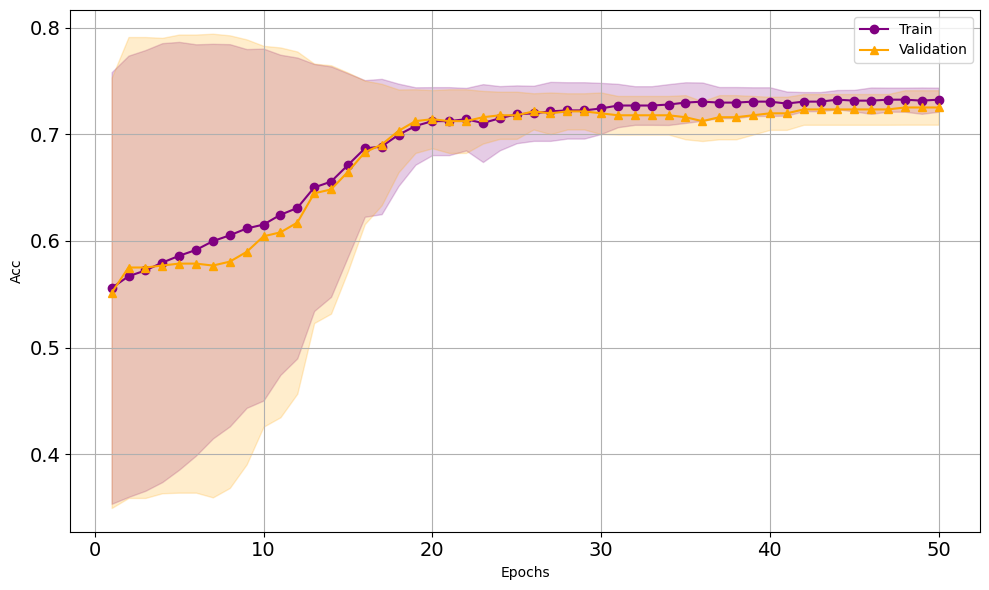

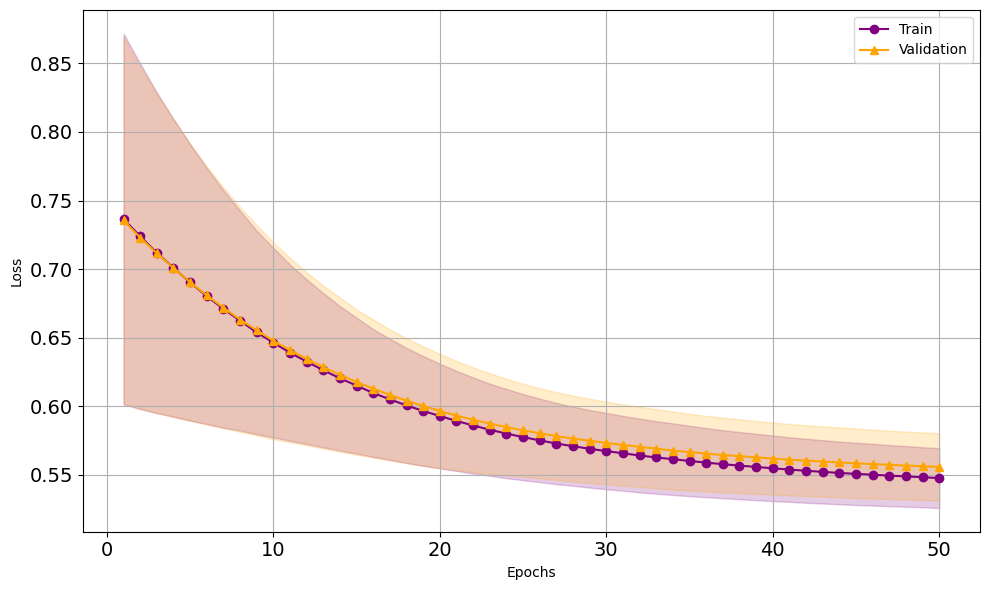

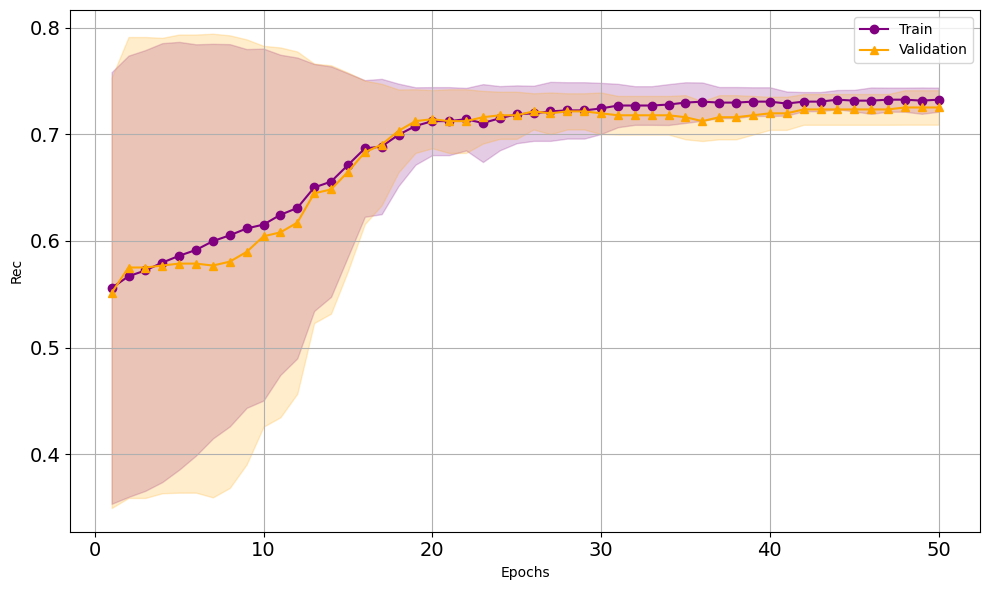

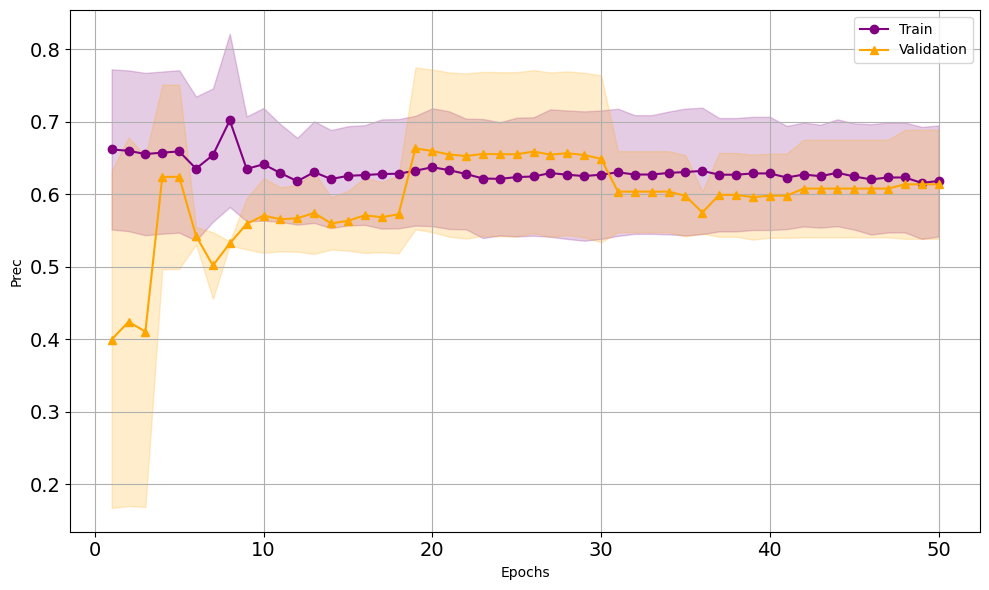

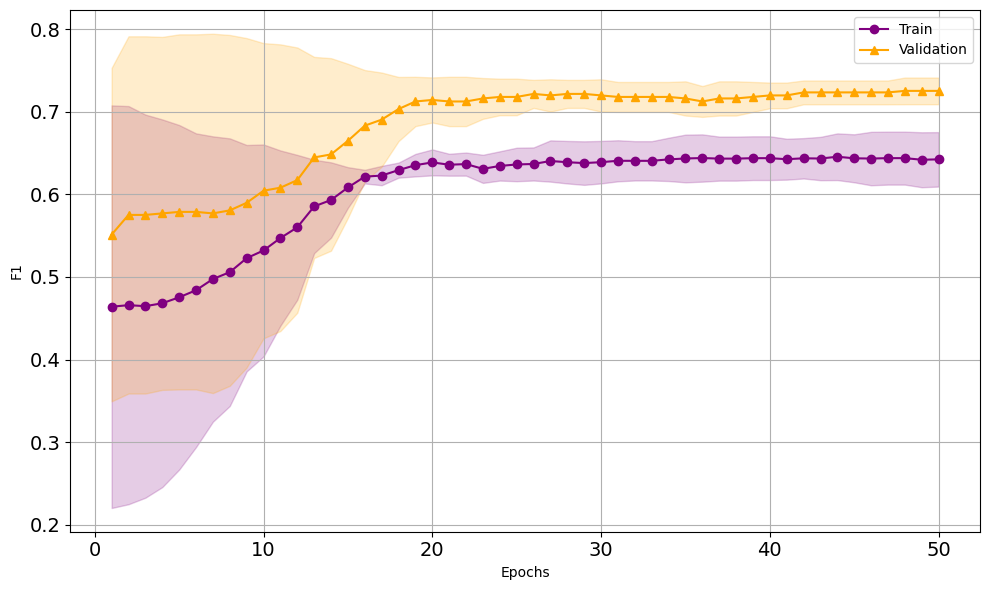

In [34]:
epochs_range = list(range(1, len(train_metrics_folds["acc"][0]) + 1))

metrics_summary = {}
import json

for metric in ["acc", "loss", "rec", "prec", "f1"]:
    summary = plot_metric_with_std(metric, train_metrics_folds, val_metrics_folds, epochs_range,  classical=False, save_name=f"{model_name}_mean_{metric}_curve")
    metrics_summary[metric] = summary

# with open(f"/home/dalopezm/quantum-studies/quantum-cv/results/{model_name}_means_stds_metrics.json", "w") as f:
with open(f"/home/dalopezm/gaussian-qnns/results/{model_name}_means_stds_metrics.json", "w") as f:
    json.dump(metrics_summary, f, indent=4)

In [29]:
device = "cpu"
test_dv_model = DVQuantumLinear(4, n_classes).to(device)

# test_dv_model.load_state_dict(torch.load(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/{model_name}_fold_{best_fold}_best.pth"))
test_dv_model.load_state_dict(torch.load(f"/home/dalopezm/gaussian-qnns/model_checkpoints/{model_name}_fold_{best_fold}_best.pth"))
test_dv_model.to(device)

test_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

test_loss, test_acc, test_prec, test_rec, test_f1, test_report, test_preds, dv_test_probs, dv_test_labels = evaluate_v2(test_dv_model, test_loader, optimizer, criterion, device)

test_metrics["acc"].append(test_acc)
test_metrics["loss"].append(test_loss)
test_metrics["rec"].append(test_rec)
test_metrics["prec"].append(test_prec)
test_metrics["f1"].append(test_f1)

print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f} | Test rec: {test_rec:.4f} | Test prec: {test_prec:.4f} | Test f1: {test_f1:.4f}")

# with open(f"/home/dalopezm/quantum-studies/quantum-cv/results/{model_name}_test_metrics.json", "w") as f:
with open(f"/home/dalopezm/gaussian-qnns/results/{model_name}_test_metrics.json", "w") as f:
    json.dump(test_metrics, f, indent=4)

Training | Epoch None: 100%|█| 5/5 [00:01<00:00,  2.90it/s, loss=0.5725, acc=0.7

Test loss: 0.5725 | Test acc: 0.7308 | Test rec: 0.7308 | Test prec: 0.6731 | Test f1: 0.7308


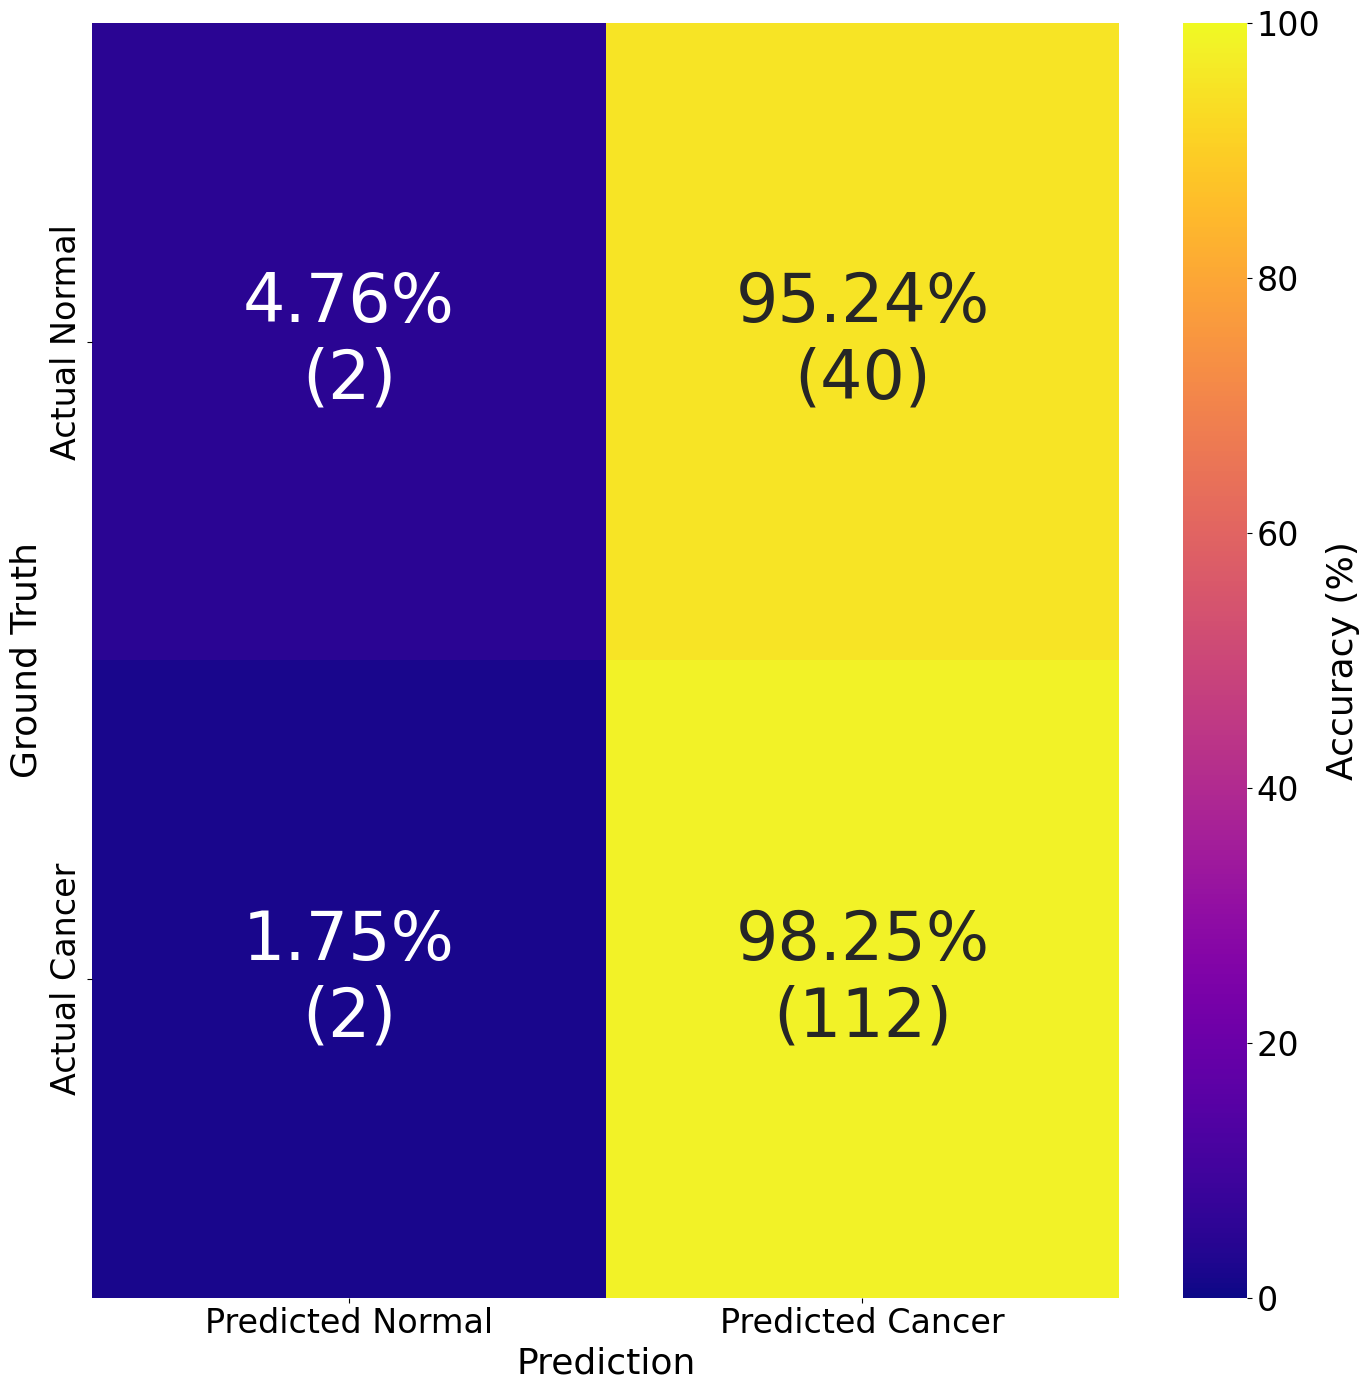

In [35]:
label_names = ["Normal", "Cancer"]

plot_confusion_matrix(test_labels, test_preds, label_names, model_name, binary=True)

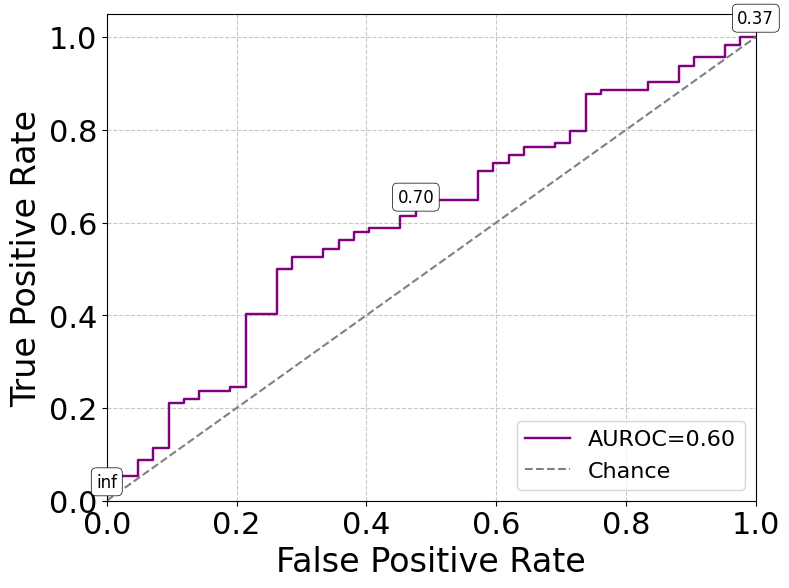

In [36]:
plot_auroc(dv_test_labels, dv_test_probs, model_name, binary=True)

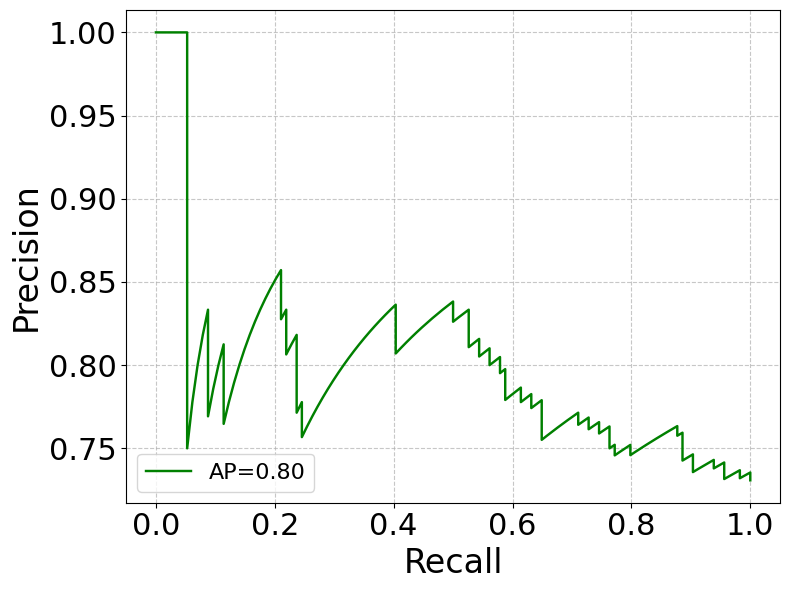

In [37]:
plot_prec(dv_test_labels, dv_test_probs, model_name, binary=True)

In [39]:
cam, outputs, predictions = gradcam_model(test_dv_model, x_test_tensor[0:16], quantum=True)
print(cam.shape)

torch.Size([16, 4])


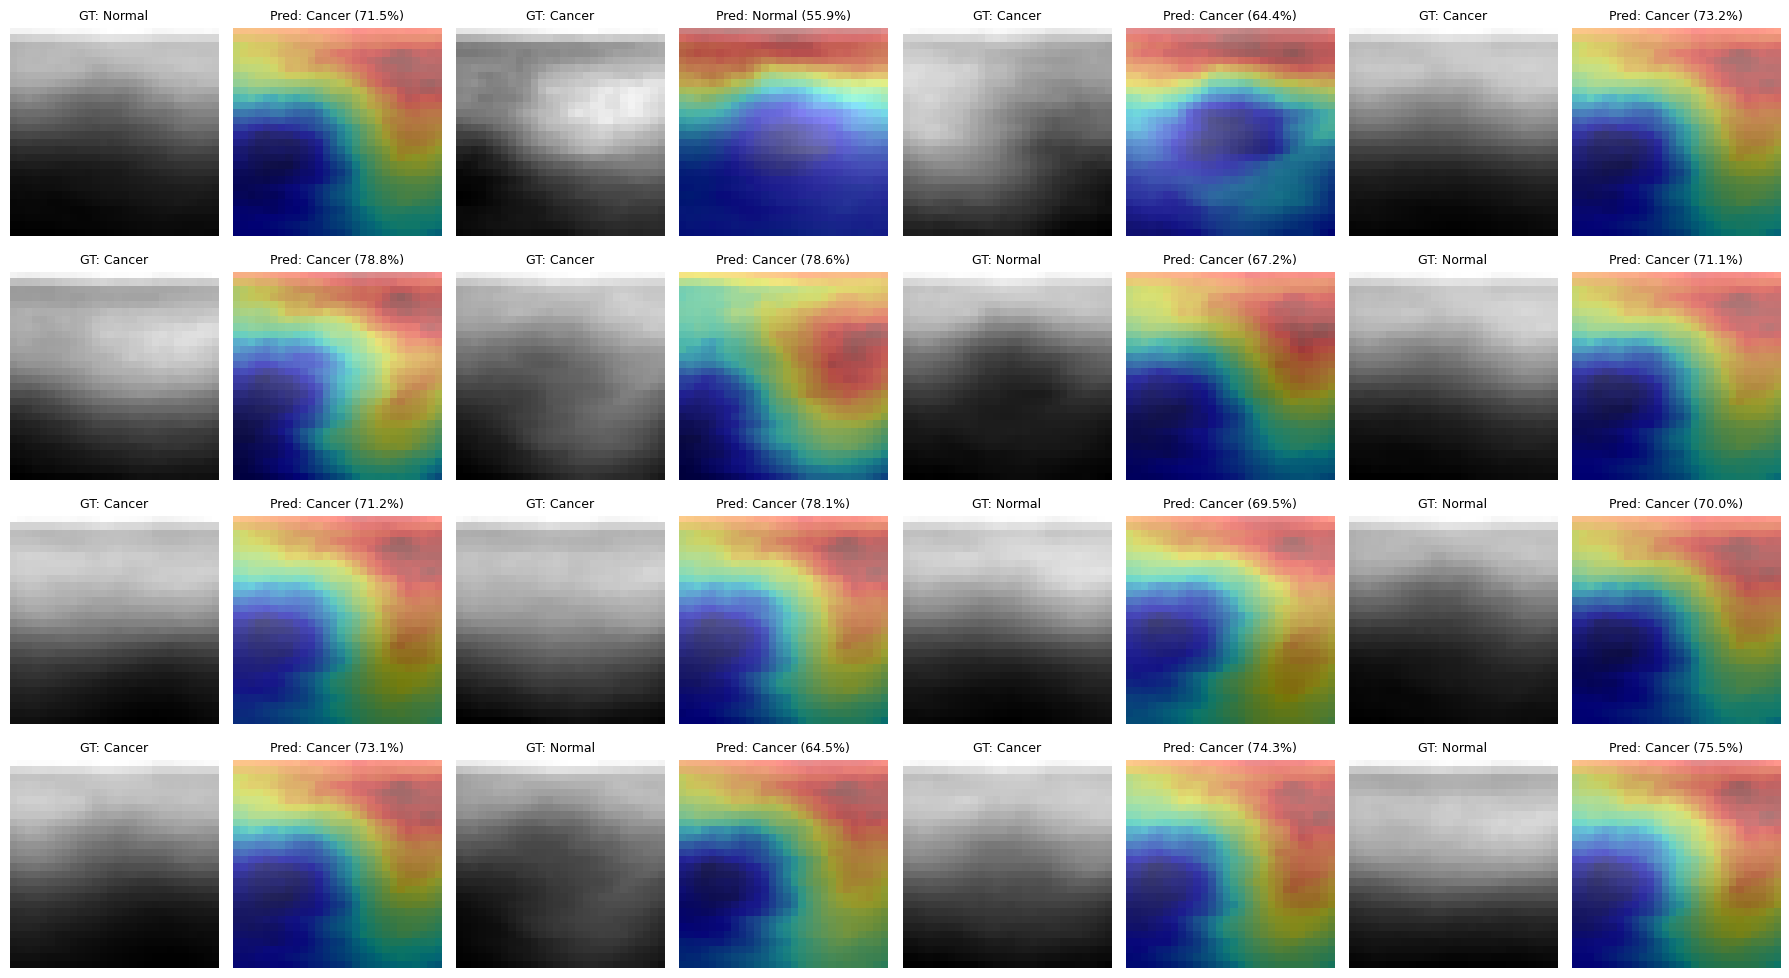

In [40]:
plot_reconstructed_heatmaps_with_predictions(
    samples = x_test_tensor[0:16].to(device),
    cam = cam,
    preds = predictions,
    probs = outputs,
    labels = y_test_tensor[0:16].to(device),
    encoder = encoder,
    class_names = label_names
)

## CLASSICAL MODEL

In [30]:
epochs = 50
device = "cpu"
model_name = "classical_breast"
classical_model = ClassicalModel()

optimizer = torch.optim.Adam(classical_model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

from torchinfo import summary
summary(classical_model)

Layer (type:depth-idx)                   Param #
ClassicalModel                           --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       20
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       10
Total params: 30
Trainable params: 30
Non-trainable params: 0

In [42]:
run_kfold_training(ClassicalModel, train_dataset, optimizer, criterion, n_classes, model_name, device=device, classical=True, k=3, num_epochs=epochs, seed=42)


 Fold 1/3


Training: 100%|█████████| 6/6 [00:00<00:00, 193.55it/s, loss=0.6892, acc=0.5385]


Train loss: 0.7032 | Train acc: 0.5137 | Train rec: 0.5137 | Train prec: 0.5213 | Train f1: 0.5175
Val loss: 0.6892 | Val acc: 0.5385 | Val rec: 0.5385 | Val prec: 0.5324 | Val f1: 0.5385


Training: 100%|█████████| 6/6 [00:00<00:00, 196.89it/s, loss=0.6730, acc=0.5879]


Train loss: 0.6828 | Train acc: 0.5797 | Train rec: 0.5797 | Train prec: 0.5327 | Train f1: 0.5540
Val loss: 0.6730 | Val acc: 0.5879 | Val rec: 0.5879 | Val prec: 0.5319 | Val f1: 0.5879


Training: 100%|█████████| 6/6 [00:00<00:00, 190.26it/s, loss=0.6581, acc=0.6484]


Train loss: 0.6662 | Train acc: 0.6264 | Train rec: 0.6264 | Train prec: 0.5322 | Train f1: 0.5725
Val loss: 0.6581 | Val acc: 0.6484 | Val rec: 0.6484 | Val prec: 0.5340 | Val f1: 0.6484


Training: 100%|█████████| 6/6 [00:00<00:00, 217.17it/s, loss=0.6451, acc=0.6868]


Train loss: 0.6511 | Train acc: 0.6703 | Train rec: 0.6703 | Train prec: 0.5335 | Train f1: 0.5905
Val loss: 0.6451 | Val acc: 0.6868 | Val rec: 0.6868 | Val prec: 0.5250 | Val f1: 0.6868


Training: 100%|█████████| 6/6 [00:00<00:00, 227.11it/s, loss=0.6345, acc=0.7198]


Train loss: 0.6373 | Train acc: 0.7033 | Train rec: 0.7033 | Train prec: 0.5285 | Train f1: 0.6035
Val loss: 0.6345 | Val acc: 0.7198 | Val rec: 0.7198 | Val prec: 0.5318 | Val f1: 0.7198


Training: 100%|█████████| 6/6 [00:00<00:00, 219.60it/s, loss=0.6250, acc=0.7308]


Train loss: 0.6263 | Train acc: 0.7143 | Train rec: 0.7143 | Train prec: 0.5307 | Train f1: 0.6090
Val loss: 0.6250 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 182.66it/s, loss=0.6164, acc=0.7308]


Train loss: 0.6165 | Train acc: 0.7225 | Train rec: 0.7225 | Train prec: 0.5324 | Train f1: 0.6131
Val loss: 0.6164 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 207.72it/s, loss=0.6095, acc=0.7308]


Train loss: 0.6076 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.6095 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 205.02it/s, loss=0.6032, acc=0.7308]


Train loss: 0.6007 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.6032 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 226.58it/s, loss=0.5983, acc=0.7308]


Train loss: 0.5938 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5983 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 207.09it/s, loss=0.5936, acc=0.7308]


Train loss: 0.5885 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5936 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 193.31it/s, loss=0.5897, acc=0.7308]


Train loss: 0.5833 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5897 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 182.05it/s, loss=0.5859, acc=0.7308]


Train loss: 0.5790 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5859 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 189.88it/s, loss=0.5829, acc=0.7308]


Train loss: 0.5745 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5829 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 187.17it/s, loss=0.5799, acc=0.7308]


Train loss: 0.5711 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5799 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 179.77it/s, loss=0.5773, acc=0.7308]


Train loss: 0.5677 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5773 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 189.86it/s, loss=0.5752, acc=0.7308]


Train loss: 0.5646 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5752 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 187.42it/s, loss=0.5736, acc=0.7308]


Train loss: 0.5618 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5736 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 192.63it/s, loss=0.5718, acc=0.7308]


Train loss: 0.5596 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5718 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 196.54it/s, loss=0.5704, acc=0.7308]


Train loss: 0.5573 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5704 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 202.44it/s, loss=0.5691, acc=0.7308]


Train loss: 0.5554 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5691 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 187.62it/s, loss=0.5680, acc=0.7308]


Train loss: 0.5536 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5680 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 207.49it/s, loss=0.5668, acc=0.7308]


Train loss: 0.5518 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5668 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 224.75it/s, loss=0.5659, acc=0.7308]


Train loss: 0.5500 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5659 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 196.96it/s, loss=0.5650, acc=0.7308]


Train loss: 0.5484 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5650 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 188.90it/s, loss=0.5641, acc=0.7308]


Train loss: 0.5470 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5641 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 190.59it/s, loss=0.5635, acc=0.7308]


Train loss: 0.5454 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5635 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 188.34it/s, loss=0.5627, acc=0.7308]


Train loss: 0.5442 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5627 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 195.26it/s, loss=0.5621, acc=0.7308]


Train loss: 0.5430 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5621 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 203.79it/s, loss=0.5615, acc=0.7308]


Train loss: 0.5418 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5615 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 204.48it/s, loss=0.5610, acc=0.7308]


Train loss: 0.5406 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5610 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 201.34it/s, loss=0.5604, acc=0.7308]


Train loss: 0.5395 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5604 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 212.31it/s, loss=0.5599, acc=0.7308]


Train loss: 0.5384 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5599 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 219.51it/s, loss=0.5592, acc=0.7308]


Train loss: 0.5373 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5592 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 189.01it/s, loss=0.5585, acc=0.7308]


Train loss: 0.5364 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5585 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 218.02it/s, loss=0.5580, acc=0.7308]


Train loss: 0.5352 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5580 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 197.68it/s, loss=0.5574, acc=0.7308]


Train loss: 0.5342 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5574 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 201.68it/s, loss=0.5569, acc=0.7308]


Train loss: 0.5332 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5569 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 189.82it/s, loss=0.5564, acc=0.7308]


Train loss: 0.5323 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5564 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 216.34it/s, loss=0.5560, acc=0.7308]


Train loss: 0.5313 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5560 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 183.88it/s, loss=0.5556, acc=0.7308]


Train loss: 0.5302 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5556 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 210.40it/s, loss=0.5550, acc=0.7308]


Train loss: 0.5293 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5550 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 208.22it/s, loss=0.5546, acc=0.7308]


Train loss: 0.5282 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5546 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 255.92it/s, loss=0.5542, acc=0.7308]


Train loss: 0.5272 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5542 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 205.02it/s, loss=0.5538, acc=0.7308]


Train loss: 0.5262 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5538 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 185.39it/s, loss=0.5535, acc=0.7308]


Train loss: 0.5255 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5535 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 198.20it/s, loss=0.5534, acc=0.7308]


Train loss: 0.5246 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5534 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 188.46it/s, loss=0.5532, acc=0.7308]


Train loss: 0.5238 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5532 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 207.66it/s, loss=0.5531, acc=0.7308]


Train loss: 0.5229 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5531 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 185.45it/s, loss=0.5530, acc=0.7308]

Train loss: 0.5223 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5530 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308

 Fold 2/3



Training: 100%|█████████| 6/6 [00:00<00:00, 199.06it/s, loss=0.6041, acc=0.7308]


Train loss: 0.6056 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.6041 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 201.40it/s, loss=0.5991, acc=0.7308]


Train loss: 0.6004 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5991 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 194.18it/s, loss=0.5941, acc=0.7308]


Train loss: 0.5957 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5941 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 198.99it/s, loss=0.5900, acc=0.7308]


Train loss: 0.5914 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5900 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 219.26it/s, loss=0.5856, acc=0.7308]


Train loss: 0.5874 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5856 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 213.58it/s, loss=0.5817, acc=0.7308]

Train loss: 0.5837 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5817 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308



Training: 100%|█████████| 6/6 [00:00<00:00, 218.83it/s, loss=0.5784, acc=0.7308]


Train loss: 0.5797 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5784 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 204.89it/s, loss=0.5747, acc=0.7308]


Train loss: 0.5764 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5747 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 195.32it/s, loss=0.5711, acc=0.7308]


Train loss: 0.5731 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5711 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 201.35it/s, loss=0.5678, acc=0.7308]


Train loss: 0.5697 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5678 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 197.52it/s, loss=0.5647, acc=0.7308]


Train loss: 0.5666 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.5340 | Train f1: 0.6171
Val loss: 0.5647 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 176.84it/s, loss=0.5617, acc=0.7308]


Train loss: 0.5631 | Train acc: 0.7335 | Train rec: 0.7335 | Train prec: 0.8047 | Train f1: 0.6235
Val loss: 0.5617 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 206.08it/s, loss=0.5588, acc=0.7308]


Train loss: 0.5604 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.6696 | Train f1: 0.6221
Val loss: 0.5588 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 250.11it/s, loss=0.5561, acc=0.7308]


Train loss: 0.5574 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.6696 | Train f1: 0.6221
Val loss: 0.5561 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 175.47it/s, loss=0.5533, acc=0.7308]


Train loss: 0.5547 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.6696 | Train f1: 0.6221
Val loss: 0.5533 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 204.49it/s, loss=0.5506, acc=0.7308]


Train loss: 0.5519 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.6696 | Train f1: 0.6221
Val loss: 0.5506 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.5340 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 193.05it/s, loss=0.5479, acc=0.7253]


Train loss: 0.5495 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.6696 | Train f1: 0.6221
Val loss: 0.5479 | Val acc: 0.7253 | Val rec: 0.7253 | Val prec: 0.5329 | Val f1: 0.7253


Training: 100%|█████████| 6/6 [00:00<00:00, 182.78it/s, loss=0.5455, acc=0.7253]


Train loss: 0.5470 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.6696 | Train f1: 0.6221
Val loss: 0.5455 | Val acc: 0.7253 | Val rec: 0.7253 | Val prec: 0.5329 | Val f1: 0.7253


Training: 100%|█████████| 6/6 [00:00<00:00, 229.61it/s, loss=0.5431, acc=0.7253]


Train loss: 0.5447 | Train acc: 0.7335 | Train rec: 0.7335 | Train prec: 0.7159 | Train f1: 0.6284
Val loss: 0.5431 | Val acc: 0.7253 | Val rec: 0.7253 | Val prec: 0.5329 | Val f1: 0.7253


Training: 100%|█████████| 6/6 [00:00<00:00, 222.13it/s, loss=0.5408, acc=0.7253]


Train loss: 0.5425 | Train acc: 0.7335 | Train rec: 0.7335 | Train prec: 0.7159 | Train f1: 0.6284
Val loss: 0.5408 | Val acc: 0.7253 | Val rec: 0.7253 | Val prec: 0.5329 | Val f1: 0.7253


Training: 100%|█████████| 6/6 [00:00<00:00, 177.35it/s, loss=0.5385, acc=0.7253]


Train loss: 0.5406 | Train acc: 0.7335 | Train rec: 0.7335 | Train prec: 0.7159 | Train f1: 0.6284
Val loss: 0.5385 | Val acc: 0.7253 | Val rec: 0.7253 | Val prec: 0.5329 | Val f1: 0.7253


Training: 100%|█████████| 6/6 [00:00<00:00, 204.16it/s, loss=0.5367, acc=0.7308]


Train loss: 0.5388 | Train acc: 0.7335 | Train rec: 0.7335 | Train prec: 0.6989 | Train f1: 0.6330
Val loss: 0.5367 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.6705 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 199.00it/s, loss=0.5346, acc=0.7308]


Train loss: 0.5371 | Train acc: 0.7335 | Train rec: 0.7335 | Train prec: 0.6989 | Train f1: 0.6330
Val loss: 0.5346 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.6705 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 201.83it/s, loss=0.5327, acc=0.7308]


Train loss: 0.5352 | Train acc: 0.7335 | Train rec: 0.7335 | Train prec: 0.6922 | Train f1: 0.6375
Val loss: 0.5327 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.6705 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 193.70it/s, loss=0.5309, acc=0.7143]


Train loss: 0.5336 | Train acc: 0.7363 | Train rec: 0.7363 | Train prec: 0.7081 | Train f1: 0.6434
Val loss: 0.5309 | Val acc: 0.7143 | Val rec: 0.7143 | Val prec: 0.5864 | Val f1: 0.7143


Training: 100%|█████████| 6/6 [00:00<00:00, 200.70it/s, loss=0.5291, acc=0.7198]


Train loss: 0.5321 | Train acc: 0.7363 | Train rec: 0.7363 | Train prec: 0.7081 | Train f1: 0.6434
Val loss: 0.5291 | Val acc: 0.7198 | Val rec: 0.7198 | Val prec: 0.6254 | Val f1: 0.7198


Training: 100%|█████████| 6/6 [00:00<00:00, 255.87it/s, loss=0.5275, acc=0.7198]


Train loss: 0.5306 | Train acc: 0.7390 | Train rec: 0.7390 | Train prec: 0.7209 | Train f1: 0.6492
Val loss: 0.5275 | Val acc: 0.7198 | Val rec: 0.7198 | Val prec: 0.6254 | Val f1: 0.7198


Training: 100%|█████████| 6/6 [00:00<00:00, 195.94it/s, loss=0.5261, acc=0.7198]


Train loss: 0.5293 | Train acc: 0.7473 | Train rec: 0.7473 | Train prec: 0.7479 | Train f1: 0.6660
Val loss: 0.5261 | Val acc: 0.7198 | Val rec: 0.7198 | Val prec: 0.6254 | Val f1: 0.7198


Training: 100%|█████████| 6/6 [00:00<00:00, 182.68it/s, loss=0.5249, acc=0.7198]


Train loss: 0.5280 | Train acc: 0.7473 | Train rec: 0.7473 | Train prec: 0.7479 | Train f1: 0.6660
Val loss: 0.5249 | Val acc: 0.7198 | Val rec: 0.7198 | Val prec: 0.6254 | Val f1: 0.7198


Training: 100%|█████████| 6/6 [00:00<00:00, 194.39it/s, loss=0.5235, acc=0.7198]


Train loss: 0.5269 | Train acc: 0.7473 | Train rec: 0.7473 | Train prec: 0.7479 | Train f1: 0.6660
Val loss: 0.5235 | Val acc: 0.7198 | Val rec: 0.7198 | Val prec: 0.6254 | Val f1: 0.7198


Training: 100%|█████████| 6/6 [00:00<00:00, 183.48it/s, loss=0.5224, acc=0.7308]


Train loss: 0.5260 | Train acc: 0.7500 | Train rec: 0.7500 | Train prec: 0.7547 | Train f1: 0.6715
Val loss: 0.5224 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.6764 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 181.24it/s, loss=0.5212, acc=0.7308]


Train loss: 0.5251 | Train acc: 0.7500 | Train rec: 0.7500 | Train prec: 0.7547 | Train f1: 0.6715
Val loss: 0.5212 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.6784 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 196.51it/s, loss=0.5203, acc=0.7308]


Train loss: 0.5240 | Train acc: 0.7527 | Train rec: 0.7527 | Train prec: 0.7607 | Train f1: 0.6769
Val loss: 0.5203 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.6784 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 200.47it/s, loss=0.5193, acc=0.7308]


Train loss: 0.5233 | Train acc: 0.7582 | Train rec: 0.7582 | Train prec: 0.7710 | Train f1: 0.6874
Val loss: 0.5193 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.6784 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 207.10it/s, loss=0.5182, acc=0.7308]


Train loss: 0.5225 | Train acc: 0.7582 | Train rec: 0.7582 | Train prec: 0.7710 | Train f1: 0.6874
Val loss: 0.5182 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.6784 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 189.55it/s, loss=0.5173, acc=0.7253]


Train loss: 0.5216 | Train acc: 0.7637 | Train rec: 0.7637 | Train prec: 0.7720 | Train f1: 0.7008
Val loss: 0.5173 | Val acc: 0.7253 | Val rec: 0.7253 | Val prec: 0.6651 | Val f1: 0.7253


Training: 100%|█████████| 6/6 [00:00<00:00, 184.91it/s, loss=0.5165, acc=0.7253]


Train loss: 0.5210 | Train acc: 0.7637 | Train rec: 0.7637 | Train prec: 0.7720 | Train f1: 0.7008
Val loss: 0.5165 | Val acc: 0.7253 | Val rec: 0.7253 | Val prec: 0.6651 | Val f1: 0.7253


Training: 100%|█████████| 6/6 [00:00<00:00, 198.80it/s, loss=0.5156, acc=0.7253]


Train loss: 0.5202 | Train acc: 0.7637 | Train rec: 0.7637 | Train prec: 0.7720 | Train f1: 0.7008
Val loss: 0.5156 | Val acc: 0.7253 | Val rec: 0.7253 | Val prec: 0.6651 | Val f1: 0.7253


Training: 100%|█████████| 6/6 [00:00<00:00, 207.57it/s, loss=0.5148, acc=0.7253]


Train loss: 0.5198 | Train acc: 0.7637 | Train rec: 0.7637 | Train prec: 0.7657 | Train f1: 0.7037
Val loss: 0.5148 | Val acc: 0.7253 | Val rec: 0.7253 | Val prec: 0.6651 | Val f1: 0.7253


Training: 100%|█████████| 6/6 [00:00<00:00, 266.43it/s, loss=0.5141, acc=0.7308]


Train loss: 0.5191 | Train acc: 0.7637 | Train rec: 0.7637 | Train prec: 0.7657 | Train f1: 0.7037
Val loss: 0.5141 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.6805 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 191.57it/s, loss=0.5131, acc=0.7363]


Train loss: 0.5186 | Train acc: 0.7637 | Train rec: 0.7637 | Train prec: 0.7657 | Train f1: 0.7037
Val loss: 0.5131 | Val acc: 0.7363 | Val rec: 0.7363 | Val prec: 0.6941 | Val f1: 0.7363


Training: 100%|█████████| 6/6 [00:00<00:00, 203.07it/s, loss=0.5126, acc=0.7363]


Train loss: 0.5181 | Train acc: 0.7637 | Train rec: 0.7637 | Train prec: 0.7657 | Train f1: 0.7037
Val loss: 0.5126 | Val acc: 0.7363 | Val rec: 0.7363 | Val prec: 0.6941 | Val f1: 0.7363


Training: 100%|█████████| 6/6 [00:00<00:00, 203.87it/s, loss=0.5118, acc=0.7418]

Train loss: 0.5178 | Train acc: 0.7637 | Train rec: 0.7637 | Train prec: 0.7657 | Train f1: 0.7037


Val loss: 0.5118 | Val acc: 0.7418 | Val rec: 0.7418 | Val prec: 0.7063 | Val f1: 0.7418


Training: 100%|█████████| 6/6 [00:00<00:00, 210.10it/s, loss=0.5113, acc=0.7418]


Train loss: 0.5174 | Train acc: 0.7637 | Train rec: 0.7637 | Train prec: 0.7657 | Train f1: 0.7037
Val loss: 0.5113 | Val acc: 0.7418 | Val rec: 0.7418 | Val prec: 0.7063 | Val f1: 0.7418


Training: 100%|█████████| 6/6 [00:00<00:00, 196.30it/s, loss=0.5106, acc=0.7418]


Train loss: 0.5171 | Train acc: 0.7637 | Train rec: 0.7637 | Train prec: 0.7657 | Train f1: 0.7037
Val loss: 0.5106 | Val acc: 0.7418 | Val rec: 0.7418 | Val prec: 0.7063 | Val f1: 0.7418


Training: 100%|█████████| 6/6 [00:00<00:00, 181.29it/s, loss=0.5102, acc=0.7418]


Train loss: 0.5166 | Train acc: 0.7637 | Train rec: 0.7637 | Train prec: 0.7657 | Train f1: 0.7037
Val loss: 0.5102 | Val acc: 0.7418 | Val rec: 0.7418 | Val prec: 0.7063 | Val f1: 0.7418


Training: 100%|█████████| 6/6 [00:00<00:00, 200.74it/s, loss=0.5097, acc=0.7473]


Train loss: 0.5162 | Train acc: 0.7637 | Train rec: 0.7637 | Train prec: 0.7657 | Train f1: 0.7037
Val loss: 0.5097 | Val acc: 0.7473 | Val rec: 0.7473 | Val prec: 0.7173 | Val f1: 0.7473


Training: 100%|█████████| 6/6 [00:00<00:00, 183.55it/s, loss=0.5094, acc=0.7473]


Train loss: 0.5161 | Train acc: 0.7610 | Train rec: 0.7610 | Train prec: 0.7522 | Train f1: 0.7045
Val loss: 0.5094 | Val acc: 0.7473 | Val rec: 0.7473 | Val prec: 0.7173 | Val f1: 0.7473


Training: 100%|█████████| 6/6 [00:00<00:00, 195.04it/s, loss=0.5090, acc=0.7473]


Train loss: 0.5158 | Train acc: 0.7582 | Train rec: 0.7582 | Train prec: 0.7442 | Train f1: 0.7025
Val loss: 0.5090 | Val acc: 0.7473 | Val rec: 0.7473 | Val prec: 0.7173 | Val f1: 0.7473


Training: 100%|█████████| 6/6 [00:00<00:00, 199.16it/s, loss=0.5088, acc=0.7473]


Train loss: 0.5155 | Train acc: 0.7582 | Train rec: 0.7582 | Train prec: 0.7442 | Train f1: 0.7025
Val loss: 0.5088 | Val acc: 0.7473 | Val rec: 0.7473 | Val prec: 0.7173 | Val f1: 0.7473

 Fold 3/3


Training: 100%|█████████| 6/6 [00:00<00:00, 194.31it/s, loss=1.0071, acc=0.2692]


Train loss: 1.0396 | Train acc: 0.2692 | Train rec: 0.2692 | Train prec: 0.0725 | Train f1: 0.1142
Val loss: 1.0071 | Val acc: 0.2692 | Val rec: 0.2692 | Val prec: 0.0725 | Val f1: 0.2692


Training: 100%|█████████| 6/6 [00:00<00:00, 244.81it/s, loss=0.9760, acc=0.2692]


Train loss: 1.0087 | Train acc: 0.2692 | Train rec: 0.2692 | Train prec: 0.0725 | Train f1: 0.1142
Val loss: 0.9760 | Val acc: 0.2692 | Val rec: 0.2692 | Val prec: 0.0725 | Val f1: 0.2692


Training: 100%|█████████| 6/6 [00:00<00:00, 179.36it/s, loss=0.9460, acc=0.2692]


Train loss: 0.9788 | Train acc: 0.2692 | Train rec: 0.2692 | Train prec: 0.0725 | Train f1: 0.1142
Val loss: 0.9460 | Val acc: 0.2692 | Val rec: 0.2692 | Val prec: 0.0725 | Val f1: 0.2692


Training: 100%|█████████| 6/6 [00:00<00:00, 209.79it/s, loss=0.9172, acc=0.2692]


Train loss: 0.9502 | Train acc: 0.2720 | Train rec: 0.2720 | Train prec: 0.8035 | Train f1: 0.1199
Val loss: 0.9172 | Val acc: 0.2692 | Val rec: 0.2692 | Val prec: 0.0725 | Val f1: 0.2692


Training: 100%|█████████| 6/6 [00:00<00:00, 191.20it/s, loss=0.8892, acc=0.2692]


Train loss: 0.9233 | Train acc: 0.2720 | Train rec: 0.2720 | Train prec: 0.8035 | Train f1: 0.1199
Val loss: 0.8892 | Val acc: 0.2692 | Val rec: 0.2692 | Val prec: 0.0725 | Val f1: 0.2692


Training: 100%|█████████| 6/6 [00:00<00:00, 192.39it/s, loss=0.8626, acc=0.2857]


Train loss: 0.8971 | Train acc: 0.2775 | Train rec: 0.2775 | Train prec: 0.8039 | Train f1: 0.1313
Val loss: 0.8626 | Val acc: 0.2857 | Val rec: 0.2857 | Val prec: 0.8045 | Val f1: 0.2857


Training: 100%|█████████| 6/6 [00:00<00:00, 204.00it/s, loss=0.8371, acc=0.3022]


Train loss: 0.8718 | Train acc: 0.2857 | Train rec: 0.2857 | Train prec: 0.8045 | Train f1: 0.1480
Val loss: 0.8371 | Val acc: 0.3022 | Val rec: 0.3022 | Val prec: 0.8057 | Val f1: 0.3022


Training: 100%|█████████| 6/6 [00:00<00:00, 202.79it/s, loss=0.8127, acc=0.3462]


Train loss: 0.8480 | Train acc: 0.2995 | Train rec: 0.2995 | Train prec: 0.8055 | Train f1: 0.1750
Val loss: 0.8127 | Val acc: 0.3462 | Val rec: 0.3462 | Val prec: 0.7629 | Val f1: 0.3462


Training: 100%|█████████| 6/6 [00:00<00:00, 175.22it/s, loss=0.7898, acc=0.3901]


Train loss: 0.8248 | Train acc: 0.3214 | Train rec: 0.3214 | Train prec: 0.7721 | Train f1: 0.2203
Val loss: 0.7898 | Val acc: 0.3901 | Val rec: 0.3901 | Val prec: 0.7329 | Val f1: 0.3901


Training: 100%|█████████| 6/6 [00:00<00:00, 201.88it/s, loss=0.7671, acc=0.4286]


Train loss: 0.8029 | Train acc: 0.3516 | Train rec: 0.3516 | Train prec: 0.7661 | Train f1: 0.2767
Val loss: 0.7671 | Val acc: 0.4286 | Val rec: 0.4286 | Val prec: 0.7199 | Val f1: 0.4286


Training: 100%|█████████| 6/6 [00:00<00:00, 194.68it/s, loss=0.7449, acc=0.4615]


Train loss: 0.7819 | Train acc: 0.3736 | Train rec: 0.3736 | Train prec: 0.7220 | Train f1: 0.3237
Val loss: 0.7449 | Val acc: 0.4615 | Val rec: 0.4615 | Val prec: 0.7232 | Val f1: 0.4615


Training: 100%|█████████| 6/6 [00:00<00:00, 189.93it/s, loss=0.7248, acc=0.4725]


Train loss: 0.7605 | Train acc: 0.4148 | Train rec: 0.4148 | Train prec: 0.7282 | Train f1: 0.3894
Val loss: 0.7248 | Val acc: 0.4725 | Val rec: 0.4725 | Val prec: 0.7060 | Val f1: 0.4725


Training: 100%|█████████| 6/6 [00:00<00:00, 188.58it/s, loss=0.7057, acc=0.5000]


Train loss: 0.7412 | Train acc: 0.4341 | Train rec: 0.4341 | Train prec: 0.7091 | Train f1: 0.4232
Val loss: 0.7057 | Val acc: 0.5000 | Val rec: 0.5000 | Val prec: 0.7004 | Val f1: 0.5000


Training: 100%|█████████| 6/6 [00:00<00:00, 181.59it/s, loss=0.6879, acc=0.5110]


Train loss: 0.7229 | Train acc: 0.4698 | Train rec: 0.4698 | Train prec: 0.7155 | Train f1: 0.4718
Val loss: 0.6879 | Val acc: 0.5110 | Val rec: 0.5110 | Val prec: 0.6972 | Val f1: 0.5110


Training: 100%|█████████| 6/6 [00:00<00:00, 208.64it/s, loss=0.6704, acc=0.5385]


Train loss: 0.7067 | Train acc: 0.5000 | Train rec: 0.5000 | Train prec: 0.7094 | Train f1: 0.5122
Val loss: 0.6704 | Val acc: 0.5385 | Val rec: 0.5385 | Val prec: 0.7020 | Val f1: 0.5385


Training: 100%|█████████| 6/6 [00:00<00:00, 205.67it/s, loss=0.6556, acc=0.5879]


Train loss: 0.6898 | Train acc: 0.5137 | Train rec: 0.5137 | Train prec: 0.7068 | Train f1: 0.5294
Val loss: 0.6556 | Val acc: 0.5879 | Val rec: 0.5879 | Val prec: 0.7234 | Val f1: 0.5879


Training: 100%|█████████| 6/6 [00:00<00:00, 200.40it/s, loss=0.6412, acc=0.6099]


Train loss: 0.6749 | Train acc: 0.5522 | Train rec: 0.5522 | Train prec: 0.7119 | Train f1: 0.5728
Val loss: 0.6412 | Val acc: 0.6099 | Val rec: 0.6099 | Val prec: 0.7326 | Val f1: 0.6099


Training: 100%|█████████| 6/6 [00:00<00:00, 195.77it/s, loss=0.6278, acc=0.6264]

Train loss: 0.6607 | Train acc: 0.5659 | Train rec: 0.5659 | Train prec: 0.7105 | Train f1: 0.5878
Val loss: 0.6278 | Val acc: 0.6264 | Val rec: 0.6264 | Val prec: 0.7329 | Val f1: 0.6264



Training: 100%|█████████| 6/6 [00:00<00:00, 241.19it/s, loss=0.6155, acc=0.6484]


Train loss: 0.6476 | Train acc: 0.5824 | Train rec: 0.5824 | Train prec: 0.7076 | Train f1: 0.6051
Val loss: 0.6155 | Val acc: 0.6484 | Val rec: 0.6484 | Val prec: 0.7362 | Val f1: 0.6484


Training: 100%|█████████| 6/6 [00:00<00:00, 186.03it/s, loss=0.6047, acc=0.6593]


Train loss: 0.6350 | Train acc: 0.5989 | Train rec: 0.5989 | Train prec: 0.7116 | Train f1: 0.6213
Val loss: 0.6047 | Val acc: 0.6593 | Val rec: 0.6593 | Val prec: 0.7297 | Val f1: 0.6593


Training: 100%|█████████| 6/6 [00:00<00:00, 214.25it/s, loss=0.5938, acc=0.6813]


Train loss: 0.6242 | Train acc: 0.6154 | Train rec: 0.6154 | Train prec: 0.7128 | Train f1: 0.6371
Val loss: 0.5938 | Val acc: 0.6813 | Val rec: 0.6813 | Val prec: 0.7400 | Val f1: 0.6813


Training: 100%|█████████| 6/6 [00:00<00:00, 202.67it/s, loss=0.5843, acc=0.6978]


Train loss: 0.6133 | Train acc: 0.6264 | Train rec: 0.6264 | Train prec: 0.7091 | Train f1: 0.6471
Val loss: 0.5843 | Val acc: 0.6978 | Val rec: 0.6978 | Val prec: 0.7479 | Val f1: 0.6978


Training: 100%|█████████| 6/6 [00:00<00:00, 181.68it/s, loss=0.5760, acc=0.6868]


Train loss: 0.6035 | Train acc: 0.6429 | Train rec: 0.6429 | Train prec: 0.7167 | Train f1: 0.6622
Val loss: 0.5760 | Val acc: 0.6868 | Val rec: 0.6868 | Val prec: 0.7326 | Val f1: 0.6868


Training: 100%|█████████| 6/6 [00:00<00:00, 198.32it/s, loss=0.5686, acc=0.6868]


Train loss: 0.5952 | Train acc: 0.6648 | Train rec: 0.6648 | Train prec: 0.7243 | Train f1: 0.6818
Val loss: 0.5686 | Val acc: 0.6868 | Val rec: 0.6868 | Val prec: 0.7326 | Val f1: 0.6868


Training: 100%|█████████| 6/6 [00:00<00:00, 199.11it/s, loss=0.5622, acc=0.6868]


Train loss: 0.5875 | Train acc: 0.6731 | Train rec: 0.6731 | Train prec: 0.7258 | Train f1: 0.6889
Val loss: 0.5622 | Val acc: 0.6868 | Val rec: 0.6868 | Val prec: 0.7278 | Val f1: 0.6868


Training: 100%|█████████| 6/6 [00:00<00:00, 204.01it/s, loss=0.5564, acc=0.6813]


Train loss: 0.5803 | Train acc: 0.6813 | Train rec: 0.6813 | Train prec: 0.7298 | Train f1: 0.6962
Val loss: 0.5564 | Val acc: 0.6813 | Val rec: 0.6813 | Val prec: 0.7156 | Val f1: 0.6813


Training: 100%|█████████| 6/6 [00:00<00:00, 207.92it/s, loss=0.5514, acc=0.6923]


Train loss: 0.5744 | Train acc: 0.6841 | Train rec: 0.6841 | Train prec: 0.7287 | Train f1: 0.6982
Val loss: 0.5514 | Val acc: 0.6923 | Val rec: 0.6923 | Val prec: 0.7171 | Val f1: 0.6923


Training: 100%|█████████| 6/6 [00:00<00:00, 257.12it/s, loss=0.5467, acc=0.7143]


Train loss: 0.5688 | Train acc: 0.6951 | Train rec: 0.6951 | Train prec: 0.7320 | Train f1: 0.7074
Val loss: 0.5467 | Val acc: 0.7143 | Val rec: 0.7143 | Val prec: 0.7297 | Val f1: 0.7143


Training: 100%|█████████| 6/6 [00:00<00:00, 192.59it/s, loss=0.5424, acc=0.7143]


Train loss: 0.5637 | Train acc: 0.7088 | Train rec: 0.7088 | Train prec: 0.7371 | Train f1: 0.7189
Val loss: 0.5424 | Val acc: 0.7143 | Val rec: 0.7143 | Val prec: 0.7257 | Val f1: 0.7143


Training: 100%|█████████| 6/6 [00:00<00:00, 167.34it/s, loss=0.5385, acc=0.7198]


Train loss: 0.5590 | Train acc: 0.7115 | Train rec: 0.7115 | Train prec: 0.7364 | Train f1: 0.7207
Val loss: 0.5385 | Val acc: 0.7198 | Val rec: 0.7198 | Val prec: 0.7216 | Val f1: 0.7198


Training: 100%|█████████| 6/6 [00:00<00:00, 199.96it/s, loss=0.5353, acc=0.7253]


Train loss: 0.5547 | Train acc: 0.7115 | Train rec: 0.7115 | Train prec: 0.7364 | Train f1: 0.7207
Val loss: 0.5353 | Val acc: 0.7253 | Val rec: 0.7253 | Val prec: 0.7253 | Val f1: 0.7253


Training: 100%|█████████| 6/6 [00:00<00:00, 224.73it/s, loss=0.5323, acc=0.7253]


Train loss: 0.5509 | Train acc: 0.7225 | Train rec: 0.7225 | Train prec: 0.7427 | Train f1: 0.7303
Val loss: 0.5323 | Val acc: 0.7253 | Val rec: 0.7253 | Val prec: 0.7253 | Val f1: 0.7253


Training: 100%|█████████| 6/6 [00:00<00:00, 207.49it/s, loss=0.5298, acc=0.7253]


Train loss: 0.5474 | Train acc: 0.7143 | Train rec: 0.7143 | Train prec: 0.7317 | Train f1: 0.7213
Val loss: 0.5298 | Val acc: 0.7253 | Val rec: 0.7253 | Val prec: 0.7218 | Val f1: 0.7253


Training: 100%|█████████| 6/6 [00:00<00:00, 194.77it/s, loss=0.5276, acc=0.7198]


Train loss: 0.5444 | Train acc: 0.7170 | Train rec: 0.7170 | Train prec: 0.7313 | Train f1: 0.7230
Val loss: 0.5276 | Val acc: 0.7198 | Val rec: 0.7198 | Val prec: 0.7145 | Val f1: 0.7198


Training: 100%|█████████| 6/6 [00:00<00:00, 175.82it/s, loss=0.5253, acc=0.7253]


Train loss: 0.5419 | Train acc: 0.7170 | Train rec: 0.7170 | Train prec: 0.7293 | Train f1: 0.7223
Val loss: 0.5253 | Val acc: 0.7253 | Val rec: 0.7253 | Val prec: 0.7184 | Val f1: 0.7253


Training: 100%|█████████| 6/6 [00:00<00:00, 223.29it/s, loss=0.5236, acc=0.7253]


Train loss: 0.5395 | Train acc: 0.7198 | Train rec: 0.7198 | Train prec: 0.7272 | Train f1: 0.7231
Val loss: 0.5236 | Val acc: 0.7253 | Val rec: 0.7253 | Val prec: 0.7150 | Val f1: 0.7253


Training: 100%|█████████| 6/6 [00:00<00:00, 186.32it/s, loss=0.5221, acc=0.7308]


Train loss: 0.5372 | Train acc: 0.7253 | Train rec: 0.7253 | Train prec: 0.7289 | Train f1: 0.7270
Val loss: 0.5221 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.7224 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 183.35it/s, loss=0.5208, acc=0.7253]


Train loss: 0.5352 | Train acc: 0.7253 | Train rec: 0.7253 | Train prec: 0.7235 | Train f1: 0.7244
Val loss: 0.5208 | Val acc: 0.7253 | Val rec: 0.7253 | Val prec: 0.7150 | Val f1: 0.7253


Training: 100%|█████████| 6/6 [00:00<00:00, 186.33it/s, loss=0.5194, acc=0.7198]


Train loss: 0.5333 | Train acc: 0.7335 | Train rec: 0.7335 | Train prec: 0.7277 | Train f1: 0.7303
Val loss: 0.5194 | Val acc: 0.7198 | Val rec: 0.7198 | Val prec: 0.7043 | Val f1: 0.7198


Training: 100%|█████████| 6/6 [00:00<00:00, 197.56it/s, loss=0.5182, acc=0.7198]


Train loss: 0.5315 | Train acc: 0.7363 | Train rec: 0.7363 | Train prec: 0.7297 | Train f1: 0.7326
Val loss: 0.5182 | Val acc: 0.7198 | Val rec: 0.7198 | Val prec: 0.7043 | Val f1: 0.7198


Training: 100%|█████████| 6/6 [00:00<00:00, 201.84it/s, loss=0.5172, acc=0.7198]


Train loss: 0.5301 | Train acc: 0.7335 | Train rec: 0.7335 | Train prec: 0.7261 | Train f1: 0.7293
Val loss: 0.5172 | Val acc: 0.7198 | Val rec: 0.7198 | Val prec: 0.7043 | Val f1: 0.7198


Training: 100%|█████████| 6/6 [00:00<00:00, 179.00it/s, loss=0.5165, acc=0.7418]

Train loss: 0.5286 | Train acc: 0.7363 | Train rec: 0.7363 | Train prec: 0.7281 | Train f1: 0.7316
Val loss: 0.5165 | Val acc: 0.7418 | Val rec: 0.7418 | Val prec: 0.7227 | Val f1: 0.7418



Training: 100%|█████████| 6/6 [00:00<00:00, 183.47it/s, loss=0.5159, acc=0.7363]


Train loss: 0.5275 | Train acc: 0.7335 | Train rec: 0.7335 | Train prec: 0.7229 | Train f1: 0.7272
Val loss: 0.5159 | Val acc: 0.7363 | Val rec: 0.7363 | Val prec: 0.7151 | Val f1: 0.7363


Training: 100%|█████████| 6/6 [00:00<00:00, 187.10it/s, loss=0.5152, acc=0.7308]


Train loss: 0.5264 | Train acc: 0.7280 | Train rec: 0.7280 | Train prec: 0.7155 | Train f1: 0.7205
Val loss: 0.5152 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.7074 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 201.95it/s, loss=0.5147, acc=0.7308]


Train loss: 0.5255 | Train acc: 0.7225 | Train rec: 0.7225 | Train prec: 0.7080 | Train f1: 0.7136
Val loss: 0.5147 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.7074 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 191.65it/s, loss=0.5142, acc=0.7363]


Train loss: 0.5248 | Train acc: 0.7198 | Train rec: 0.7198 | Train prec: 0.7026 | Train f1: 0.7089
Val loss: 0.5142 | Val acc: 0.7363 | Val rec: 0.7363 | Val prec: 0.7125 | Val f1: 0.7363


Training: 100%|█████████| 6/6 [00:00<00:00, 185.80it/s, loss=0.5138, acc=0.7308]


Train loss: 0.5238 | Train acc: 0.7225 | Train rec: 0.7225 | Train prec: 0.7032 | Train f1: 0.7098
Val loss: 0.5138 | Val acc: 0.7308 | Val rec: 0.7308 | Val prec: 0.7046 | Val f1: 0.7308


Training: 100%|█████████| 6/6 [00:00<00:00, 221.64it/s, loss=0.5136, acc=0.7253]


Train loss: 0.5232 | Train acc: 0.7225 | Train rec: 0.7225 | Train prec: 0.7016 | Train f1: 0.7085
Val loss: 0.5136 | Val acc: 0.7253 | Val rec: 0.7253 | Val prec: 0.6965 | Val f1: 0.7253


Training: 100%|█████████| 6/6 [00:00<00:00, 194.18it/s, loss=0.5132, acc=0.7253]


Train loss: 0.5227 | Train acc: 0.7253 | Train rec: 0.7253 | Train prec: 0.7025 | Train f1: 0.7092
Val loss: 0.5132 | Val acc: 0.7253 | Val rec: 0.7253 | Val prec: 0.6965 | Val f1: 0.7253


Training: 100%|█████████| 6/6 [00:00<00:00, 189.16it/s, loss=0.5129, acc=0.7253]


Train loss: 0.5219 | Train acc: 0.7308 | Train rec: 0.7308 | Train prec: 0.7074 | Train f1: 0.7136
Val loss: 0.5129 | Val acc: 0.7253 | Val rec: 0.7253 | Val prec: 0.6965 | Val f1: 0.7253


In [31]:
n_folds = 3
train_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1":[]}
val_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1": []}

for fold in range(n_folds):
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
    with open(f"/home/dalopezm/gaussian-qnns/model_checkpoints/{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    for key in train_metrics:
        train_metrics_folds[key].append(train_metrics[key])
        val_metrics_folds[key].append(val_metrics[key])

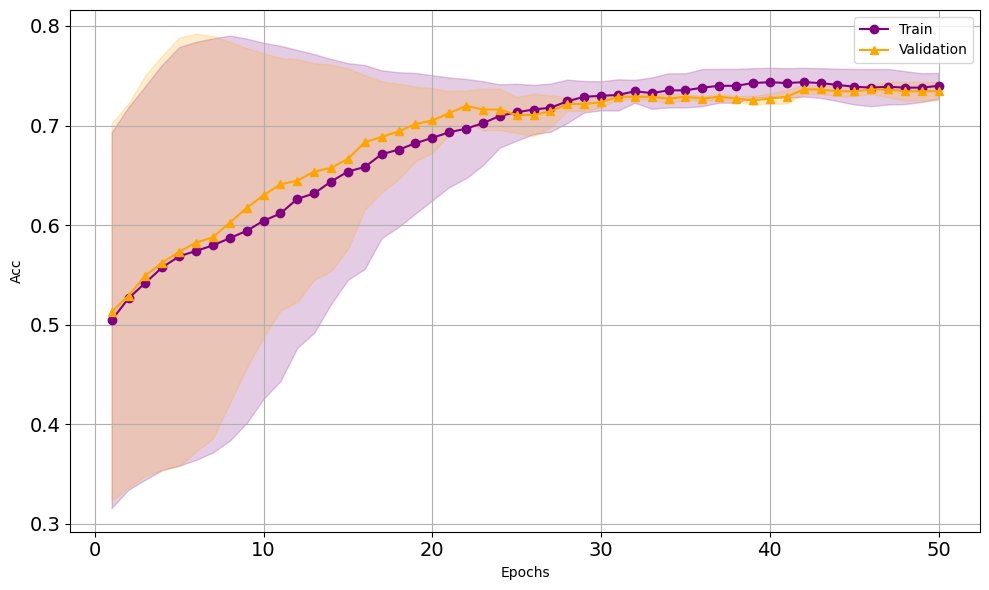

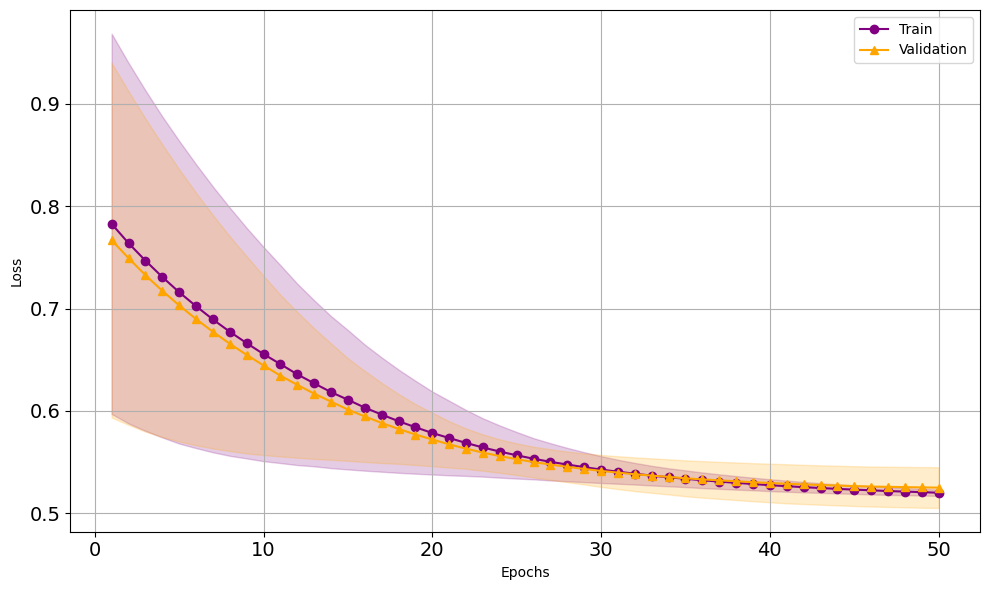

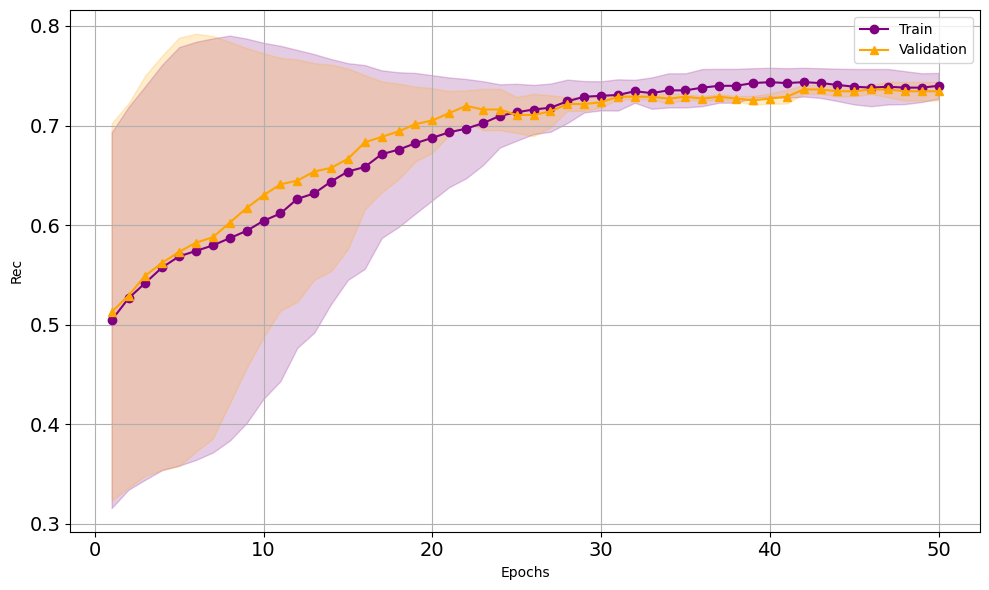

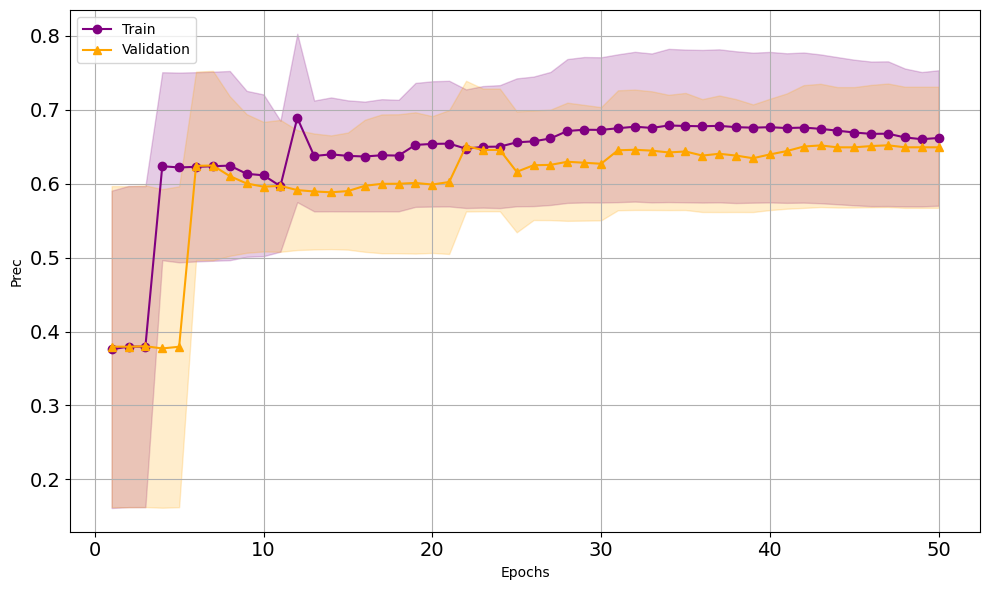

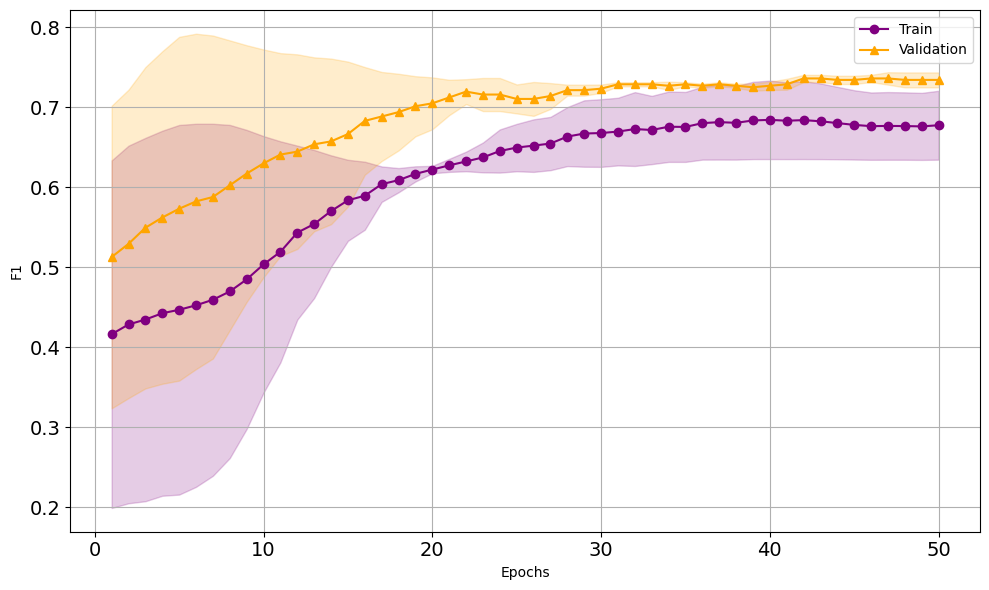

In [37]:
epochs_range = list(range(1, len(train_metrics_folds["acc"][0]) + 1))

metrics_summary = {}

for metric in ["acc", "loss", "rec", "prec", "f1"]:
    summary = plot_metric_with_std(metric, train_metrics_folds, val_metrics_folds, epochs_range, classical=True, save_name=f"{model_name}_mean_{metric}_curve")
    metrics_summary[metric] = summary

# with open(f"/home/dalopezm/quantum-studies/quantum-cv/results/{model_name}_means_stds_metrics.json", "w") as f:
with open(f"/home/dalopezm/gaussian-qnns/results/{model_name}_means_stds_metrics.json", "w") as f:
    json.dump(metrics_summary, f, indent=4)

In [32]:
best_fold = -1
best_val_f1 = -1

for fold in range(1, n_folds+1):
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/{model_name}_fold_{fold}_metrics.pkl", "rb") as f:
    with open(f"/home/dalopezm/gaussian-qnns/model_checkpoints/{model_name}_fold_{fold}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    last_val_f1 = val_metrics["f1"][-1]

    if last_val_f1 > best_val_f1:
        best_val_f1 = last_val_f1
        best_fold = fold

print(f"Best fold: {best_fold} with val_f1 = {best_val_f1:.4f}")

Best fold: 2 with val_f1 = 0.7473


In [33]:
test_classical_model = ClassicalModel()
# test_classical_model.load_state_dict(torch.load("/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_model_best.pth"))
# test_classical_model.load_state_dict(torch.load(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/{model_name}_fold_{best_fold}_best.pth"))
test_classical_model.load_state_dict(torch.load(f"/home/dalopezm/gaussian-qnns/model_checkpoints/{model_name}_fold_{best_fold}_best.pth"))
test_classical_model.to(device)

c_test_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

test_loss, test_acc, test_prec, test_rec, test_f1, test_report, test_preds, classical_test_probs, classical_test_labels = evaluate_v2(test_classical_model, test_loader, optimizer, criterion, device)

c_test_metrics["acc"].append(test_acc)
c_test_metrics["loss"].append(test_loss)
c_test_metrics["rec"].append(test_rec)
c_test_metrics["prec"].append(test_prec)
c_test_metrics["f1"].append(test_f1)

print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f} | Test rec: {test_rec:.4f} | Test prec: {test_prec:.4f} | Test f1: {test_f1:.4f}")

# with open(f"/home/dalopezm/quantum-studies/quantum-cv/results/{model_name}_test_metrics.json", "w") as f:
with open(f"/home/dalopezm/gaussian-qnns/results/{model_name}_test_metrics.json", "w") as f:
    json.dump(c_test_metrics, f, indent=4)

Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 379.19it/s, loss=0.5074, acc=0.

Test loss: 0.5074 | Test acc: 0.7628 | Test rec: 0.7628 | Test prec: 0.7662 | Test f1: 0.7628


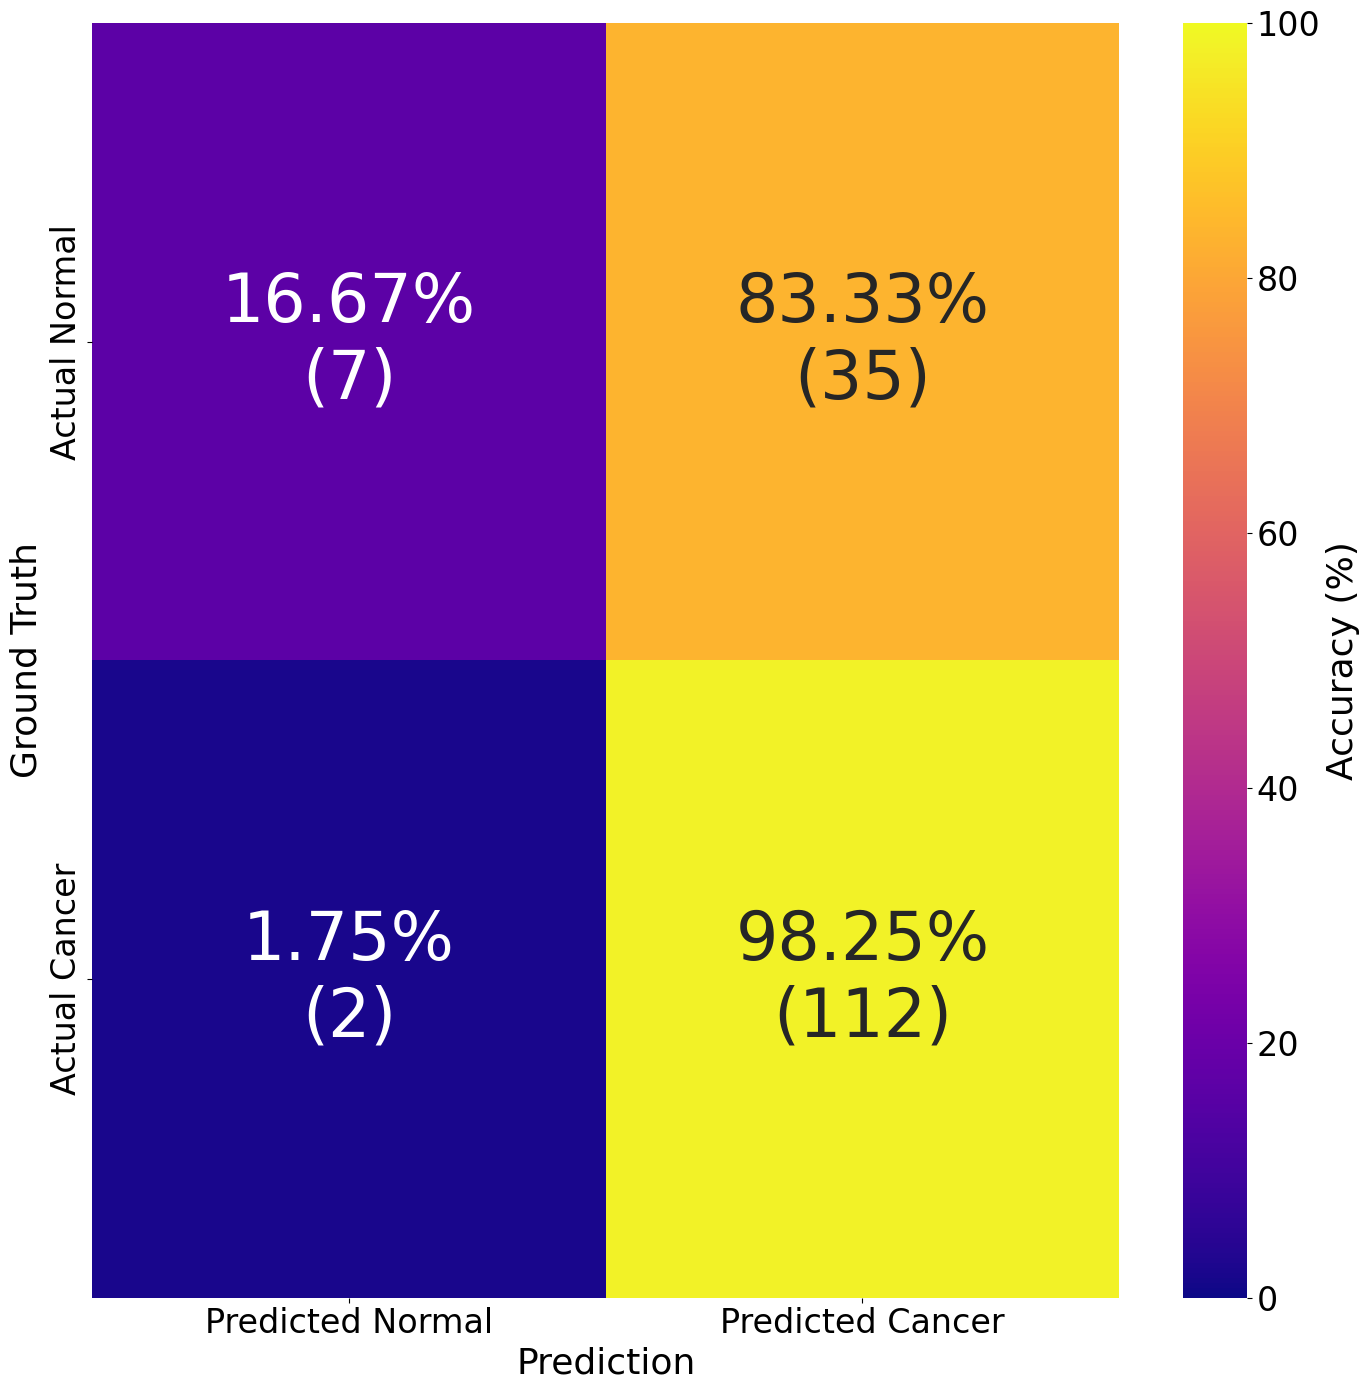

In [42]:
label_names = ["Normal", "Cancer"]

plot_confusion_matrix(classical_test_labels, test_preds, label_names, model_name, binary=True)

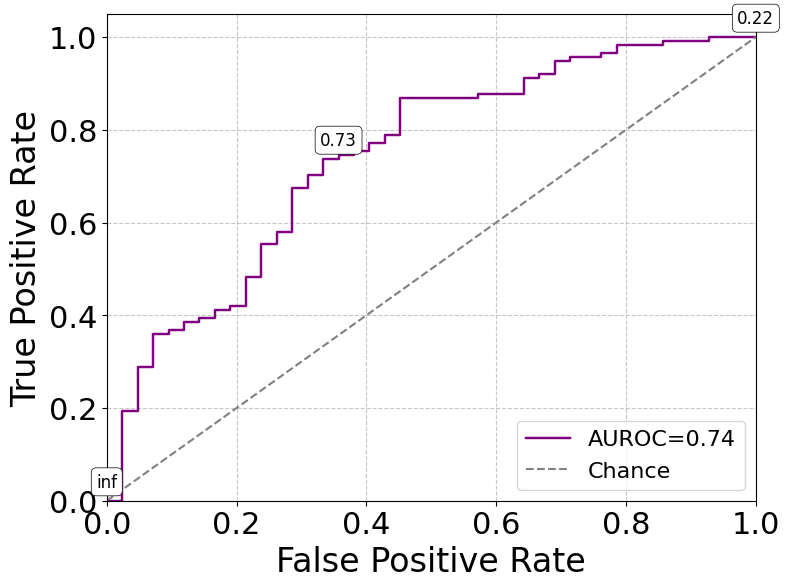

In [43]:
plot_auroc(classical_test_labels, classical_test_probs, model_name, binary=True)

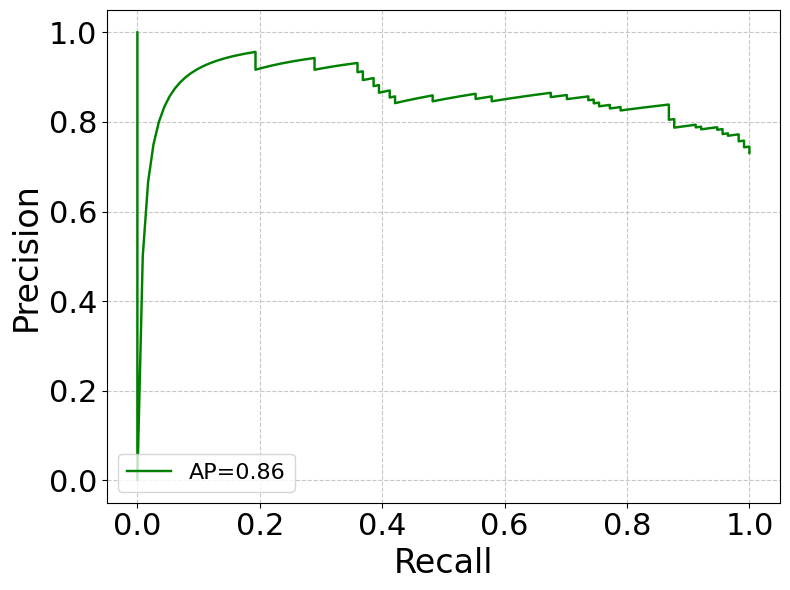

In [44]:
plot_prec(classical_test_labels, classical_test_probs, model_name, binary=True)

In [50]:
cam, outputs, predictions = gradcam_model(test_classical_model, x_test_tensor[0:16], quantum=False)

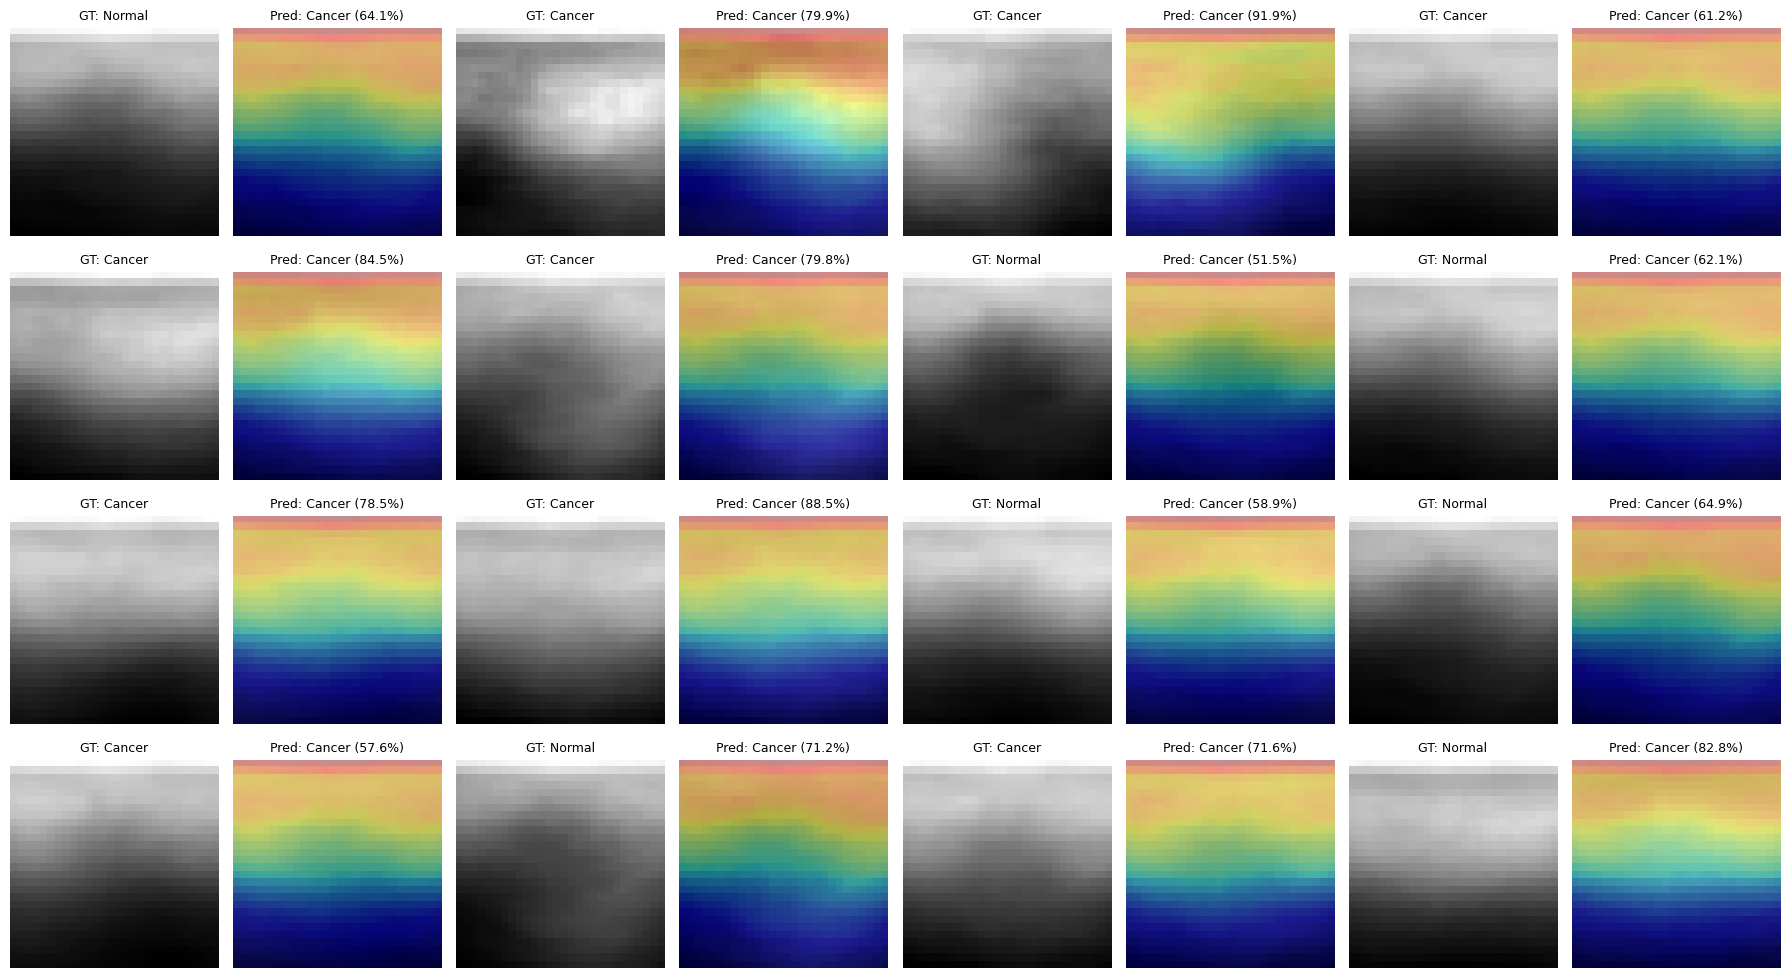

In [51]:
plot_reconstructed_heatmaps_with_predictions(
    samples = x_test_tensor[0:16].to(device),
    cam = cam,
    preds = predictions,
    probs = outputs,
    labels = y_test_tensor[0:16].to(device),
    encoder = encoder,
    class_names = label_names,
)

## MODEL COMPARISON

In [45]:
import numpy as np
noise_std = np.arange(0.1, 1.05, 0.05)

cv_noise_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

dv_noise_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

classical_noise_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

dataset_name = "breast"

cv_noise_metrics = noise_robustness_validation(test_cv_model, test_loader, noise_std, cv_noise_metrics, "cv", optimizer, criterion, device)
dv_noise_metrics = noise_robustness_validation(test_dv_model, test_loader, noise_std, dv_noise_metrics, "dv", optimizer, criterion, device)
classic_noise_metrics = noise_robustness_validation(test_classical_model, test_loader, noise_std, classical_noise_metrics, "classical", optimizer, criterion, device)

[STD: 0.10] Clean mean: 0.0502, Noisy mean: 0.0558


Training | Epoch None: 100%|█| 5/5 [00:00<00:00,  6.69it/s, loss=0.5153, acc=0.7


[STD: 0.15] Clean mean: 0.0502, Noisy mean: 0.0434


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 11.17it/s, loss=0.5135, acc=0.7


[STD: 0.20] Clean mean: 0.0502, Noisy mean: 0.0433


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 11.15it/s, loss=0.5118, acc=0.7


[STD: 0.25] Clean mean: 0.0502, Noisy mean: 0.0379


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 11.14it/s, loss=0.5179, acc=0.7


[STD: 0.30] Clean mean: 0.0502, Noisy mean: 0.0583


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 11.14it/s, loss=0.5061, acc=0.7


[STD: 0.35] Clean mean: 0.0502, Noisy mean: 0.0550


Training | Epoch None: 100%|█| 5/5 [00:00<00:00,  7.24it/s, loss=0.5258, acc=0.7


[STD: 0.40] Clean mean: 0.0502, Noisy mean: 0.0544


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 11.19it/s, loss=0.5239, acc=0.7


[STD: 0.45] Clean mean: 0.0502, Noisy mean: 0.0476


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 11.11it/s, loss=0.5347, acc=0.7


[STD: 0.50] Clean mean: 0.0502, Noisy mean: 0.0459


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 11.24it/s, loss=0.5348, acc=0.7


[STD: 0.55] Clean mean: 0.0502, Noisy mean: 0.0326


Training | Epoch None: 100%|█| 5/5 [00:00<00:00,  7.28it/s, loss=0.5246, acc=0.7


[STD: 0.60] Clean mean: 0.0502, Noisy mean: 0.0536


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 11.24it/s, loss=0.5468, acc=0.7


[STD: 0.65] Clean mean: 0.0502, Noisy mean: 0.0552


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 11.20it/s, loss=0.5289, acc=0.7


[STD: 0.70] Clean mean: 0.0502, Noisy mean: 0.0318


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 11.24it/s, loss=0.5605, acc=0.7


[STD: 0.75] Clean mean: 0.0502, Noisy mean: 0.0283


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 11.24it/s, loss=0.5436, acc=0.7


[STD: 0.80] Clean mean: 0.0502, Noisy mean: 0.0565


Training | Epoch None: 100%|█| 5/5 [00:00<00:00,  7.34it/s, loss=0.5335, acc=0.7


[STD: 0.85] Clean mean: 0.0502, Noisy mean: 0.0313


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 11.21it/s, loss=0.5616, acc=0.6


[STD: 0.90] Clean mean: 0.0502, Noisy mean: 0.0676


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 11.23it/s, loss=0.5560, acc=0.6


[STD: 0.95] Clean mean: 0.0502, Noisy mean: -0.0043


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 11.15it/s, loss=0.6137, acc=0.6


[STD: 1.00] Clean mean: 0.0502, Noisy mean: 0.0414


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 11.13it/s, loss=0.5622, acc=0.7


[STD: 0.10] Clean mean: 0.0502, Noisy mean: 0.0539


Training | Epoch None: 100%|█| 5/5 [00:01<00:00,  2.60it/s, loss=0.5723, acc=0.7


[STD: 0.15] Clean mean: 0.0502, Noisy mean: 0.0504


Training | Epoch None: 100%|█| 5/5 [00:01<00:00,  3.00it/s, loss=0.5679, acc=0.7


[STD: 0.20] Clean mean: 0.0502, Noisy mean: 0.0555


Training | Epoch None: 100%|█| 5/5 [00:01<00:00,  2.99it/s, loss=0.5736, acc=0.7


[STD: 0.25] Clean mean: 0.0502, Noisy mean: 0.0704


Training | Epoch None: 100%|█| 5/5 [00:01<00:00,  2.96it/s, loss=0.5663, acc=0.7


[STD: 0.30] Clean mean: 0.0502, Noisy mean: 0.0436


Training | Epoch None: 100%|█| 5/5 [00:01<00:00,  2.98it/s, loss=0.5788, acc=0.7


[STD: 0.35] Clean mean: 0.0502, Noisy mean: 0.0630


Training | Epoch None: 100%|█| 5/5 [00:01<00:00,  3.01it/s, loss=0.5884, acc=0.7


[STD: 0.40] Clean mean: 0.0502, Noisy mean: 0.0663


Training | Epoch None: 100%|█| 5/5 [00:01<00:00,  3.01it/s, loss=0.5742, acc=0.7


[STD: 0.45] Clean mean: 0.0502, Noisy mean: 0.0491


Training | Epoch None: 100%|█| 5/5 [00:01<00:00,  3.00it/s, loss=0.5802, acc=0.7


[STD: 0.50] Clean mean: 0.0502, Noisy mean: 0.0654


Training | Epoch None: 100%|█| 5/5 [00:01<00:00,  3.01it/s, loss=0.5645, acc=0.7


[STD: 0.55] Clean mean: 0.0502, Noisy mean: 0.0521


Training | Epoch None: 100%|█| 5/5 [00:01<00:00,  2.94it/s, loss=0.5888, acc=0.6


[STD: 0.60] Clean mean: 0.0502, Noisy mean: 0.0469


Training | Epoch None: 100%|█| 5/5 [00:01<00:00,  2.96it/s, loss=0.5792, acc=0.7


[STD: 0.65] Clean mean: 0.0502, Noisy mean: 0.0495


Training | Epoch None: 100%|█| 5/5 [00:01<00:00,  2.95it/s, loss=0.6177, acc=0.7


[STD: 0.70] Clean mean: 0.0502, Noisy mean: -0.0096


Training | Epoch None: 100%|█| 5/5 [00:01<00:00,  2.96it/s, loss=0.5890, acc=0.6


[STD: 0.75] Clean mean: 0.0502, Noisy mean: 0.0116


Training | Epoch None: 100%|█| 5/5 [00:01<00:00,  2.96it/s, loss=0.5955, acc=0.6


[STD: 0.80] Clean mean: 0.0502, Noisy mean: 0.0664


Training | Epoch None: 100%|█| 5/5 [00:01<00:00,  2.96it/s, loss=0.5799, acc=0.7


[STD: 0.85] Clean mean: 0.0502, Noisy mean: 0.0917


Training | Epoch None: 100%|█| 5/5 [00:01<00:00,  2.94it/s, loss=0.6081, acc=0.6


[STD: 0.90] Clean mean: 0.0502, Noisy mean: 0.0059


Training | Epoch None: 100%|█| 5/5 [00:01<00:00,  2.96it/s, loss=0.6372, acc=0.6


[STD: 0.95] Clean mean: 0.0502, Noisy mean: 0.0414


Training | Epoch None: 100%|█| 5/5 [00:01<00:00,  2.96it/s, loss=0.5790, acc=0.7


[STD: 1.00] Clean mean: 0.0502, Noisy mean: -0.0031


Training | Epoch None: 100%|█| 5/5 [00:01<00:00,  2.97it/s, loss=0.6236, acc=0.6


[STD: 0.10] Clean mean: 0.0502, Noisy mean: 0.0467


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 460.99it/s, loss=0.5005, acc=0.


[STD: 0.15] Clean mean: 0.0502, Noisy mean: 0.0524


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 406.91it/s, loss=0.5048, acc=0.


[STD: 0.20] Clean mean: 0.0502, Noisy mean: 0.0602


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 410.87it/s, loss=0.5074, acc=0.


[STD: 0.25] Clean mean: 0.0502, Noisy mean: 0.0425


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 558.11it/s, loss=0.5077, acc=0.


[STD: 0.30] Clean mean: 0.0502, Noisy mean: 0.0467


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 426.78it/s, loss=0.5139, acc=0.


[STD: 0.35] Clean mean: 0.0502, Noisy mean: 0.0490


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 527.02it/s, loss=0.5221, acc=0.


[STD: 0.40] Clean mean: 0.0502, Noisy mean: 0.0709


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 421.33it/s, loss=0.5172, acc=0.


[STD: 0.45] Clean mean: 0.0502, Noisy mean: 0.0372


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 428.04it/s, loss=0.5172, acc=0.


[STD: 0.50] Clean mean: 0.0502, Noisy mean: 0.0695


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 431.39it/s, loss=0.5208, acc=0.


[STD: 0.55] Clean mean: 0.0502, Noisy mean: 0.0435


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 481.88it/s, loss=0.5388, acc=0.


[STD: 0.60] Clean mean: 0.0502, Noisy mean: 0.0367


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 346.93it/s, loss=0.5316, acc=0.


[STD: 0.65] Clean mean: 0.0502, Noisy mean: -0.0033


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 397.86it/s, loss=0.5638, acc=0.


[STD: 0.70] Clean mean: 0.0502, Noisy mean: 0.0684


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 474.93it/s, loss=0.5358, acc=0.


[STD: 0.75] Clean mean: 0.0502, Noisy mean: 0.0675


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 514.03it/s, loss=0.5137, acc=0.


[STD: 0.80] Clean mean: 0.0502, Noisy mean: 0.0345


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 573.85it/s, loss=0.5146, acc=0.


[STD: 0.85] Clean mean: 0.0502, Noisy mean: 0.0701


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 468.53it/s, loss=0.5490, acc=0.


[STD: 0.90] Clean mean: 0.0502, Noisy mean: 0.0459


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 481.85it/s, loss=0.5118, acc=0.


[STD: 0.95] Clean mean: 0.0502, Noisy mean: 0.0954


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 437.83it/s, loss=0.5114, acc=0.


[STD: 1.00] Clean mean: 0.0502, Noisy mean: 0.1065


Training | Epoch None: 100%|█| 5/5 [00:00<00:00, 489.19it/s, loss=0.5141, acc=0.


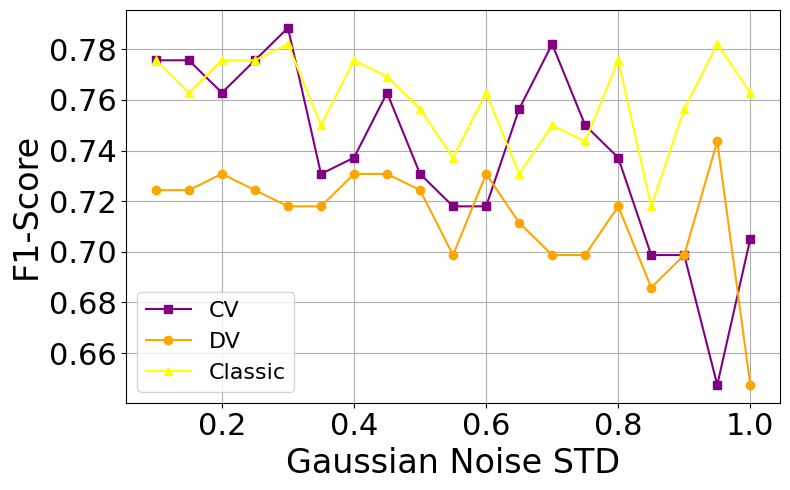

In [46]:
plot_noise_comparison(cv_noise_metrics["f1"], dv_noise_metrics["f1"], classic_noise_metrics["f1"], noise_std, "F1-Score", dataset_name)

## RELIABILITY ASSESSMENT

In [34]:
import numpy as np
import matplotlib.pyplot as plt

cv_test_probs_np = np.array(cv_test_probs)
dv_test_probs_np = np.array(dv_test_probs)
classical_test_probs_np = np.array(classical_test_probs)

In [35]:
def brier_score(y_true, y_prob):
    #binary
    if y_prob.ndim == 1 or y_prob.shape[1] == 1:
        return np.mean((y_prob - y_true)**2)

    #multiclass
    n_classes = y_prob.shape[1]
    y_true_onehot = np.eye(n_classes)[y_true]
    return np.mean(np.sum((y_prob - y_true_onehot)**2, axis=1))

def compute_ece(y_true, y_prob, n_bins=10):
    #ensure numpy arrays
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    if y_prob.ndim > 1 and y_prob.shape[1] > 1:
        confidences = np.max(y_prob, axis=1)
        preds = np.argmax(y_prob, axis=1)

    else:
        confidences = y_prob
        preds = (y_prob >= 0.5).astype(int)

    bins = np.linspace(0, 1, n_bins + 1)
    bin_ids = np.digitize(confidences, bins) - 1

    ece = 0.0
    total = len(y_true)

    for b in range(n_bins):
        idx = np.where(bin_ids == b)[0]
        if len(idx) == 0:
            continue

        acc = np.mean(y_true[idx] == preds[idx])
        conf = np.mean(confidences[idx])
        ece += (len(idx) / total) * abs(acc - conf)

    return ece

In [36]:
def reliability_diagram_multi(models_data, dataset_name, n_bins=10, save_name=None):

    """
    models_data = {
    "classical": (y_true, y_prob),
    "dv": (y_true, y_prob),
    "cv": (y_true, y_prob)
    }
    """
    
    plt.figure(figsize=(8,6))
    plt.plot([0,1], [0,1], '--', color='gray', label="Perfect Calibration")

    for name, (y_true, y_prob) in models_data.items():
        #ensure numpy arrays
        y_true = np.array(y_true)
        y_prob = np.array(y_prob)
        
        if y_prob.ndim > 1 and y_prob.shape[1] > 1:
            conf = np.max(y_prob, axis=1)
            pred = np.argmax(y_prob, axis=1)
        else:
            conf = y_prob
            pred = (y_prob >= 0.5).astype(int)

        bins = np.linspace(0, 1, n_bins + 1)
        bin_ids = np.digitize(conf, bins) - 1

        accs, confs = [], []
        for b in range(n_bins):
            idx = np.where(bin_ids == b)[0]
            if len(idx) == 0:
                continue
            accs.append((y_true[idx] == pred[idx]).mean())
            confs.append(conf[idx].mean())

        plt.plot(confs, accs, marker="o", label=name)

    plt.xlabel("Mean confidence", fontsize=26)
    plt.ylabel("Accuracy", fontsize=26)
    plt.legend(fontsize=16)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.grid(True)

    if save_name:
        # plt.savefig(f"/home/dalopezm/quantum-studies/quantum-cv/results/{save_name}_{dataset_name}", dpi=300)
        plt.savefig(f"/home/dalopezm/gaussian-qnns/results/{save_name}_{dataset_name}", dpi=300)

    plt.show()

CV brier: 0.33571682914104584
DV brier: 0.385917537416561
classical brier: 0.3317683929997237
CV ece: 0.08354187049926858
DV ece: 0.0325506153779152
classical ece 0.030323932186151155


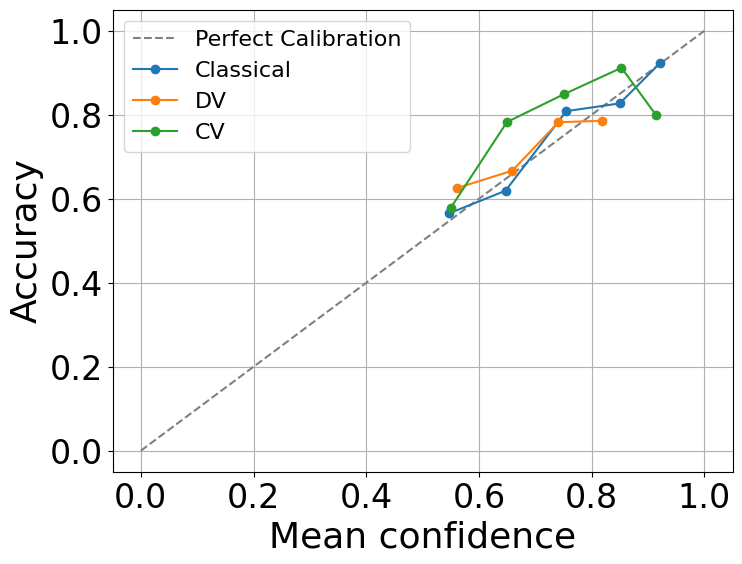

In [38]:
models_data = {
    "Classical": (classical_test_labels, classical_test_probs_np),
    "DV": (dv_test_labels, dv_test_probs_np),
    "CV": (cv_test_labels, cv_test_probs_np)
}

#brier score for pneumonia
cv_brier = brier_score(cv_test_labels, cv_test_probs_np)
dv_brier = brier_score(dv_test_labels, dv_test_probs_np)
classical_brier = brier_score(classical_test_labels, classical_test_probs_np)

#ECE value for pneumonia
cv_ece = compute_ece(cv_test_labels, cv_test_probs_np)
dv_ece = compute_ece(dv_test_labels, dv_test_probs_np)
classical_ece = compute_ece(classical_test_labels, classical_test_probs_np)

print(f"CV brier: {cv_brier}")
print(f"DV brier: {dv_brier}")
print(f"classical brier: {classical_brier}")

print(f"CV ece: {cv_ece}")
print(f"DV ece: {dv_ece}")
print(f"classical ece {classical_ece}")

reliability_diagram_multi(models_data, "breast", save_name="reliability")